## Intoduction.
We will be working mostly with the high level Keras API that comes bundled with tensorflow. The workflow is pretty straight forward:
- Load the data:
To get the most out of google colab, I recommend, uploading the dataset to your drive as a zipped file or tarball, then mounting your drive on colab and running the `unzip` command on the path to the dataset. This may seem like a lot of work, but will be worth it since when you unzip the file from colab, it saves the extracted files **temporarily** to your colab runtime and thus reduces IO overhead when running the directory iterators.
- Once the files are all setup, we then load the mobilenet_v2 and do some fine tuning for it to suit our needs.
- From there, all thats left is training the model, evaluating its metrics and iterating on said metrics until we get something desirable.

**Remember to set the runtime on colab to a GPU to get faster results**


In [ ]:
!pip install pandas numpy matplotlib tensorflow

## First, all the usual imports:

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil


from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D


## Mounting google drive

The first time running the notebook will require you to allow access to your drive from colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data
This is the aforementioned command to extract all the files.
Incase your file is in a different format, (tarball, rar.. etc.), you can search for the corresponding linux command to extract the data, but generally, for tarballs you can run:
```bash
!tar -xf some_tarball.gz
```
And for rar files you can run:
```bash
!unrar some_rarfile.rar
```

Do note that colab resets the runtime everytime you close it, so you will always have to rerun the command everytime. Reasons for this long winded approach have been explained in the introduction cell.

In [3]:
!unzip /content/drive/MyDrive/dataset/PlantVillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/52f1848f-1cfe-4e1c-a265-cb02a554805d___UF.GRC_YLCV_Lab 01944.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/5311d5a5-0331-406d-a010-7f405cf4b2ad___UF.GRC_YLCV_Lab 09557.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/53578c92-d46e-4d7d-950e-66ad61da023a___UF.GRC_YLCV_Lab 01618.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/539b2e90-30c8-4dd2-a506-7929841dbd01___YLCV_NREC 2081.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/539de84d-20c0-439b-a3b9-91a6fd3654f5___UF.GRC_YLCV_Lab 01571.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tomato_Yellow_Leaf_Curl_Virus/53b703ba-e5f3-4d9f-8f90-b1a7b7ad2345___UF.GRC_YLCV_Lab 02430.JPG  
  inflating: plantvillage dataset/grayscale/Tomato___Tom

## Setting global constants and mounting the data path
One everything is extarcted, we then set the directories for the training and validation data sets and set some global constants to be used in the rest of the notebook.

In [2]:
base_path = '/content/drive/MyDrive/PlantVillage'

train_data_dir = base_path + "/train"
val_data_dir = base_path + "/val"

os.chdir(base_path)
!dir

train  val  validation


In [3]:
img_size, batch_size, shuffle_size = 224, 32, 1000
img_shape = (img_size, img_size, 3)

In [11]:
source_dir = "/content/plantvillage dataset/color"

destination_dir = "/content/drive/MyDrive/PlantVillage"

def split_files(src_dir, dest_dir, train_ratio=0.8):
    # Create train and validation directories
    train_dir = os.path.join(dest_dir, 'train')
    validation_dir = os.path.join(dest_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    c = 0
    # Traverse the source directory
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            src_file = os.path.join(root, file)
            # Generate a random number to decide whether to put the file in train or validation set
            if random.uniform(0, 1) < train_ratio:
                dest_file = os.path.join(train_dir, os.path.relpath(src_file, src_dir))
            else:
                dest_file = os.path.join(validation_dir, os.path.relpath(src_file, src_dir))
            # Create the destination directory if it doesn't exist
            os.makedirs(os.path.dirname(dest_file), exist_ok=True)
            # Copy the file
            shutil.copy(src_file, dest_file)


split_files(source_dir, destination_dir)

## Creating the Image Data Generators
Finally, we get to the fun stuff. We create the desired generators and provide some data augmentation options to it, to get a larger dataset and then feed the generators to a directory iterator that will supply the model with the images.

The output of the following cell reveals to us how many classes were discovered.

In [12]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_generator = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 19275 images belonging to 17 classes.
Found 4889 images belonging to 17 classes.


## Saving the dataset labels
The generators has an attribute named `class_indices` that contains the data labels that have been supplied by keras.

We save this into a variable since we will require it later.

In [14]:
labels = train_generator.class_indices
print(labels)

{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0, 'Corn_(maize)___Common_rust_': 1, 'Corn_(maize)___Northern_Leaf_Blight': 2, 'Corn_(maize)___healthy': 3, 'Potato___Early_blight': 4, 'Potato___Late_blight': 5, 'Potato___healthy': 6, 'Tomato___Bacterial_spot': 7, 'Tomato___Early_blight': 8, 'Tomato___Late_blight': 9, 'Tomato___Leaf_Mold': 10, 'Tomato___Septoria_leaf_spot': 11, 'Tomato___Spider_mites Two-spotted_spider_mite': 12, 'Tomato___Target_Spot': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Tomato_mosaic_virus': 15, 'Tomato___healthy': 16}


## Preparing MobileNetV2
Keras comes packed with some models and for our case we will be using MobileNetV2, for this notebook. The first running this cell will fetch the model from the internet but afterwards the model becomes cached. Since we want the model to come with its weights, we set the value to imagenet and discrad the last 1000 layer with softmax activation for use in imagenet by setting the parameter include_top to false

In [ ]:
pdd_model = model(weights='imagenet', include_top=False, input_shape=img_shape)

## More Fine tuning to model


In [20]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(17, activation='softmax')(x)


model = Model(mobile_net.input, x)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [22]:
checkpoint = ModelCheckpoint("pdd_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [23]:
step_size = train_generator.n//train_generator.batch_size

model_history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=step_size,
    validation_data=val_generator,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/5


  1/602 [..............................] - ETA: 1:40:55 - loss: 2.8975 - acc: 0.0312

  2/602 [..............................] - ETA: 42s - loss: 2.8203 - acc: 0.0938    

  3/602 [..............................] - ETA: 42s - loss: 2.7080 - acc: 0.1667

  4/602 [..............................] - ETA: 2:01 - loss: 2.6494 - acc: 0.2031

  5/602 [..............................] - ETA: 2:44 - loss: 2.5267 - acc: 0.2375

  6/602 [..............................] - ETA: 3:10 - loss: 2.5548 - acc: 0.2188

  7/602 [..............................] - ETA: 3:30 - loss: 2.5036 - acc: 0.2366

  8/602 [..............................] - ETA: 3:43 - loss: 2.4135 - acc: 0.2656

  9/602 [..............................] - ETA: 3:51 - loss: 2.4135 - acc: 0.2604

 10/602 [..............................] - ETA: 3:59 - loss: 2.4075 - acc: 0.2562

 11/602 [..............................] - ETA: 4:04 - loss: 2.3773 - acc: 0.2614

 12/602 [..............................] - ETA: 4:09 - loss: 2.3483 - acc: 0.2734

 13/602 [..............................] - ETA: 4:13 - loss: 2.3186 - acc: 0.2812

 14/602 [..............................] - ETA: 4:14 - loss: 2.2691 - acc: 0.3013

 15/602 [..............................] - ETA: 4:18 - loss: 2.2497 - acc: 0.3063

 16/602 [..............................] - ETA: 4:26 - loss: 2.2151 - acc: 0.3242

 17/602 [..............................] - ETA: 4:38 - loss: 2.1999 - acc: 0.3327

 18/602 [..............................] - ETA: 4:50 - loss: 2.1633 - acc: 0.3472

 19/602 [..............................] - ETA: 4:59 - loss: 2.1389 - acc: 0.3586

 20/602 [..............................] - ETA: 5:08 - loss: 2.1198 - acc: 0.3719

 21/602 [>.............................] - ETA: 5:11 - loss: 2.0963 - acc: 0.3810

 22/602 [>.............................] - ETA: 5:09 - loss: 2.0787 - acc: 0.3864

 23/602 [>.............................] - ETA: 5:08 - loss: 2.0577 - acc: 0.3967

 24/602 [>.............................] - ETA: 5:07 - loss: 2.0345 - acc: 0.4036

 25/602 [>.............................] - ETA: 5:06 - loss: 2.0151 - acc: 0.4125

 26/602 [>.............................] - ETA: 5:05 - loss: 1.9954 - acc: 0.4195

 27/602 [>.............................] - ETA: 5:04 - loss: 1.9656 - acc: 0.4317

 28/602 [>.............................] - ETA: 5:03 - loss: 1.9387 - acc: 0.4420

 29/602 [>.............................] - ETA: 5:03 - loss: 1.9089 - acc: 0.4515

 30/602 [>.............................] - ETA: 5:01 - loss: 1.8895 - acc: 0.4563

 31/602 [>.............................] - ETA: 5:00 - loss: 1.8671 - acc: 0.4647

 32/602 [>.............................] - ETA: 4:59 - loss: 1.8458 - acc: 0.4707

 33/602 [>.............................] - ETA: 4:59 - loss: 1.8218 - acc: 0.4782

 34/602 [>.............................] - ETA: 4:57 - loss: 1.8014 - acc: 0.4844

 35/602 [>.............................] - ETA: 4:57 - loss: 1.7826 - acc: 0.4911

 36/602 [>.............................] - ETA: 4:56 - loss: 1.7558 - acc: 0.5009

 37/602 [>.............................] - ETA: 4:55 - loss: 1.7434 - acc: 0.5017

 38/602 [>.............................] - ETA: 4:54 - loss: 1.7301 - acc: 0.5041

 39/602 [>.............................] - ETA: 4:53 - loss: 1.7108 - acc: 0.5096

 40/602 [>.............................] - ETA: 4:52 - loss: 1.6997 - acc: 0.5133

 41/602 [=>............................] - ETA: 4:55 - loss: 1.6830 - acc: 0.5191

 42/602 [=>............................] - ETA: 5:00 - loss: 1.6661 - acc: 0.5223

 43/602 [=>............................] - ETA: 5:04 - loss: 1.6418 - acc: 0.5291

 44/602 [=>............................] - ETA: 5:09 - loss: 1.6245 - acc: 0.5348

 45/602 [=>............................] - ETA: 5:11 - loss: 1.6124 - acc: 0.5375

 46/602 [=>............................] - ETA: 5:10 - loss: 1.6018 - acc: 0.5387

 47/602 [=>............................] - ETA: 5:09 - loss: 1.5872 - acc: 0.5445

 48/602 [=>............................] - ETA: 5:07 - loss: 1.5712 - acc: 0.5508

 49/602 [=>............................] - ETA: 5:06 - loss: 1.5556 - acc: 0.5536

 50/602 [=>............................] - ETA: 5:06 - loss: 1.5489 - acc: 0.5556

 51/602 [=>............................] - ETA: 5:05 - loss: 1.5321 - acc: 0.5607

 52/602 [=>............................] - ETA: 5:04 - loss: 1.5199 - acc: 0.5637

 53/602 [=>............................] - ETA: 5:02 - loss: 1.5090 - acc: 0.5649

 54/602 [=>............................] - ETA: 5:01 - loss: 1.4927 - acc: 0.5700

 55/602 [=>............................] - ETA: 5:00 - loss: 1.4840 - acc: 0.5722

 56/602 [=>............................] - ETA: 4:59 - loss: 1.4664 - acc: 0.5787

 57/602 [=>............................] - ETA: 5:20 - loss: 1.4515 - acc: 0.5833

 58/602 [=>............................] - ETA: 5:19 - loss: 1.4382 - acc: 0.5867

 59/602 [=>............................] - ETA: 5:18 - loss: 1.4274 - acc: 0.5895

 60/602 [=>............................] - ETA: 5:16 - loss: 1.4115 - acc: 0.5938

 61/602 [==>...........................] - ETA: 5:43 - loss: 1.3994 - acc: 0.5984

 62/602 [==>...........................] - ETA: 5:46 - loss: 1.3872 - acc: 0.6013

 63/602 [==>...........................] - ETA: 5:54 - loss: 1.3758 - acc: 0.6047

 64/602 [==>...........................] - ETA: 5:57 - loss: 1.3645 - acc: 0.6074

 65/602 [==>...........................] - ETA: 6:03 - loss: 1.3546 - acc: 0.6091

 66/602 [==>...........................] - ETA: 6:06 - loss: 1.3392 - acc: 0.6141

 67/602 [==>...........................] - ETA: 6:04 - loss: 1.3277 - acc: 0.6175

 68/602 [==>...........................] - ETA: 6:02 - loss: 1.3164 - acc: 0.6204

 69/602 [==>...........................] - ETA: 6:00 - loss: 1.3078 - acc: 0.6223

 70/602 [==>...........................] - ETA: 5:58 - loss: 1.2963 - acc: 0.6250

 71/602 [==>...........................] - ETA: 5:56 - loss: 1.2896 - acc: 0.6268

 72/602 [==>...........................] - ETA: 5:54 - loss: 1.2790 - acc: 0.6302

 73/602 [==>...........................] - ETA: 5:52 - loss: 1.2682 - acc: 0.6336

 74/602 [==>...........................] - ETA: 5:53 - loss: 1.2573 - acc: 0.6360

 75/602 [==>...........................] - ETA: 5:53 - loss: 1.2508 - acc: 0.6371

 76/602 [==>...........................] - ETA: 5:53 - loss: 1.2454 - acc: 0.6386

 77/602 [==>...........................] - ETA: 5:54 - loss: 1.2373 - acc: 0.6408

 78/602 [==>...........................] - ETA: 5:54 - loss: 1.2287 - acc: 0.6430

 79/602 [==>...........................] - ETA: 5:52 - loss: 1.2232 - acc: 0.6448

 80/602 [==>...........................] - ETA: 5:50 - loss: 1.2151 - acc: 0.6461

 81/602 [===>..........................] - ETA: 5:48 - loss: 1.2058 - acc: 0.6485

 82/602 [===>..........................] - ETA: 5:47 - loss: 1.1949 - acc: 0.6521

 83/602 [===>..........................] - ETA: 5:46 - loss: 1.1858 - acc: 0.6544

 84/602 [===>..........................] - ETA: 5:44 - loss: 1.1827 - acc: 0.6548

 85/602 [===>..........................] - ETA: 5:42 - loss: 1.1767 - acc: 0.6570

 86/602 [===>..........................] - ETA: 5:41 - loss: 1.1710 - acc: 0.6577

 87/602 [===>..........................] - ETA: 5:39 - loss: 1.1630 - acc: 0.6598

 88/602 [===>..........................] - ETA: 5:37 - loss: 1.1572 - acc: 0.6609

 89/602 [===>..........................] - ETA: 5:36 - loss: 1.1497 - acc: 0.6633

 90/602 [===>..........................] - ETA: 5:34 - loss: 1.1458 - acc: 0.6632

 91/602 [===>..........................] - ETA: 5:33 - loss: 1.1390 - acc: 0.6659

 92/602 [===>..........................] - ETA: 5:31 - loss: 1.1318 - acc: 0.6681

 93/602 [===>..........................] - ETA: 5:30 - loss: 1.1248 - acc: 0.6707

 94/602 [===>..........................] - ETA: 5:28 - loss: 1.1181 - acc: 0.6729

 95/602 [===>..........................] - ETA: 5:27 - loss: 1.1126 - acc: 0.6747

 96/602 [===>..........................] - ETA: 5:25 - loss: 1.1045 - acc: 0.6768

 97/602 [===>..........................] - ETA: 5:24 - loss: 1.0951 - acc: 0.6798

 98/602 [===>..........................] - ETA: 5:24 - loss: 1.0896 - acc: 0.6811

 99/602 [===>..........................] - ETA: 5:24 - loss: 1.0844 - acc: 0.6831

100/602 [===>..........................] - ETA: 5:24 - loss: 1.0796 - acc: 0.6841

101/602 [====>.........................] - ETA: 5:25 - loss: 1.0718 - acc: 0.6863

102/602 [====>.........................] - ETA: 5:25 - loss: 1.0649 - acc: 0.6878

103/602 [====>.........................] - ETA: 5:24 - loss: 1.0584 - acc: 0.6890

104/602 [====>.........................] - ETA: 5:22 - loss: 1.0502 - acc: 0.6917

105/602 [====>.........................] - ETA: 5:21 - loss: 1.0452 - acc: 0.6932

106/602 [====>.........................] - ETA: 5:19 - loss: 1.0420 - acc: 0.6940

107/602 [====>.........................] - ETA: 5:18 - loss: 1.0377 - acc: 0.6939

108/602 [====>.........................] - ETA: 5:17 - loss: 1.0335 - acc: 0.6947

109/602 [====>.........................] - ETA: 5:15 - loss: 1.0290 - acc: 0.6961

110/602 [====>.........................] - ETA: 5:14 - loss: 1.0252 - acc: 0.6969

111/602 [====>.........................] - ETA: 5:13 - loss: 1.0200 - acc: 0.6985

112/602 [====>.........................] - ETA: 5:12 - loss: 1.0155 - acc: 0.6995

113/602 [====>.........................] - ETA: 5:10 - loss: 1.0094 - acc: 0.7013

114/602 [====>.........................] - ETA: 5:09 - loss: 1.0034 - acc: 0.7034

115/602 [====>.........................] - ETA: 5:08 - loss: 1.0000 - acc: 0.7046

116/602 [====>.........................] - ETA: 5:07 - loss: 0.9956 - acc: 0.7058

117/602 [====>.........................] - ETA: 5:05 - loss: 0.9896 - acc: 0.7078

118/602 [====>.........................] - ETA: 5:04 - loss: 0.9872 - acc: 0.7082

119/602 [====>.........................] - ETA: 5:03 - loss: 0.9840 - acc: 0.7085

120/602 [====>.........................] - ETA: 5:02 - loss: 0.9793 - acc: 0.7099

121/602 [=====>........................] - ETA: 5:05 - loss: 0.9780 - acc: 0.7105

122/602 [=====>........................] - ETA: 5:02 - loss: 0.9720 - acc: 0.7123

123/602 [=====>........................] - ETA: 5:01 - loss: 0.9696 - acc: 0.7121

124/602 [=====>........................] - ETA: 5:01 - loss: 0.9634 - acc: 0.7140

125/602 [=====>........................] - ETA: 5:01 - loss: 0.9591 - acc: 0.7155

126/602 [=====>........................] - ETA: 5:01 - loss: 0.9560 - acc: 0.7158

127/602 [=====>........................] - ETA: 5:01 - loss: 0.9519 - acc: 0.7168

128/602 [=====>........................] - ETA: 4:59 - loss: 0.9483 - acc: 0.7180

129/602 [=====>........................] - ETA: 4:58 - loss: 0.9450 - acc: 0.7188

130/602 [=====>........................] - ETA: 4:57 - loss: 0.9411 - acc: 0.7202

131/602 [=====>........................] - ETA: 4:56 - loss: 0.9375 - acc: 0.7214

132/602 [=====>........................] - ETA: 4:55 - loss: 0.9342 - acc: 0.7219

133/602 [=====>........................] - ETA: 4:54 - loss: 0.9299 - acc: 0.7228

134/602 [=====>........................] - ETA: 4:53 - loss: 0.9281 - acc: 0.7228

135/602 [=====>........................] - ETA: 4:52 - loss: 0.9248 - acc: 0.7234

136/602 [=====>........................] - ETA: 4:51 - loss: 0.9216 - acc: 0.7236

137/602 [=====>........................] - ETA: 4:50 - loss: 0.9182 - acc: 0.7245

138/602 [=====>........................] - ETA: 4:49 - loss: 0.9143 - acc: 0.7256

139/602 [=====>........................] - ETA: 4:48 - loss: 0.9106 - acc: 0.7267

140/602 [=====>........................] - ETA: 4:47 - loss: 0.9077 - acc: 0.7268

141/602 [======>.......................] - ETA: 4:46 - loss: 0.9030 - acc: 0.7283

142/602 [======>.......................] - ETA: 4:45 - loss: 0.8995 - acc: 0.7294

143/602 [======>.......................] - ETA: 4:44 - loss: 0.8949 - acc: 0.7306

144/602 [======>.......................] - ETA: 4:43 - loss: 0.8930 - acc: 0.7310

145/602 [======>.......................] - ETA: 4:42 - loss: 0.8885 - acc: 0.7320

146/602 [======>.......................] - ETA: 4:41 - loss: 0.8858 - acc: 0.7327

147/602 [======>.......................] - ETA: 4:41 - loss: 0.8862 - acc: 0.7326

148/602 [======>.......................] - ETA: 4:40 - loss: 0.8850 - acc: 0.7326

149/602 [======>.......................] - ETA: 4:41 - loss: 0.8824 - acc: 0.7335

150/602 [======>.......................] - ETA: 4:41 - loss: 0.8786 - acc: 0.7345

151/602 [======>.......................] - ETA: 4:41 - loss: 0.8758 - acc: 0.7352

152/602 [======>.......................] - ETA: 4:40 - loss: 0.8760 - acc: 0.7347

153/602 [======>.......................] - ETA: 4:39 - loss: 0.8722 - acc: 0.7358

154/602 [======>.......................] - ETA: 4:38 - loss: 0.8694 - acc: 0.7361

155/602 [======>.......................] - ETA: 4:37 - loss: 0.8668 - acc: 0.7366

156/602 [======>.......................] - ETA: 4:36 - loss: 0.8638 - acc: 0.7375

157/602 [======>.......................] - ETA: 4:34 - loss: 0.8606 - acc: 0.7384

158/602 [======>.......................] - ETA: 4:33 - loss: 0.8571 - acc: 0.7394

159/602 [======>.......................] - ETA: 4:32 - loss: 0.8552 - acc: 0.7397

160/602 [======>.......................] - ETA: 4:31 - loss: 0.8524 - acc: 0.7405

161/602 [=======>......................] - ETA: 4:30 - loss: 0.8495 - acc: 0.7410

162/602 [=======>......................] - ETA: 4:30 - loss: 0.8465 - acc: 0.7422

163/602 [=======>......................] - ETA: 4:29 - loss: 0.8454 - acc: 0.7423

164/602 [=======>......................] - ETA: 4:28 - loss: 0.8416 - acc: 0.7434

165/602 [=======>......................] - ETA: 4:27 - loss: 0.8380 - acc: 0.7448

166/602 [=======>......................] - ETA: 4:26 - loss: 0.8357 - acc: 0.7456

167/602 [=======>......................] - ETA: 4:25 - loss: 0.8327 - acc: 0.7468

168/602 [=======>......................] - ETA: 4:24 - loss: 0.8308 - acc: 0.7475

169/602 [=======>......................] - ETA: 4:23 - loss: 0.8290 - acc: 0.7479

170/602 [=======>......................] - ETA: 4:22 - loss: 0.8278 - acc: 0.7483

171/602 [=======>......................] - ETA: 4:21 - loss: 0.8254 - acc: 0.7487

172/602 [=======>......................] - ETA: 4:21 - loss: 0.8237 - acc: 0.7490

173/602 [=======>......................] - ETA: 4:21 - loss: 0.8203 - acc: 0.7501

174/602 [=======>......................] - ETA: 4:21 - loss: 0.8177 - acc: 0.7507

175/602 [=======>......................] - ETA: 4:21 - loss: 0.8154 - acc: 0.7512

176/602 [=======>......................] - ETA: 4:21 - loss: 0.8126 - acc: 0.7523

177/602 [=======>......................] - ETA: 4:20 - loss: 0.8111 - acc: 0.7526

178/602 [=======>......................] - ETA: 4:19 - loss: 0.8097 - acc: 0.7528

179/602 [=======>......................] - ETA: 4:18 - loss: 0.8082 - acc: 0.7531

180/602 [=======>......................] - ETA: 4:17 - loss: 0.8056 - acc: 0.7540

181/602 [========>.....................] - ETA: 4:16 - loss: 0.8032 - acc: 0.7548

182/602 [========>.....................] - ETA: 4:15 - loss: 0.8002 - acc: 0.7555

183/602 [========>.....................] - ETA: 4:15 - loss: 0.7977 - acc: 0.7561

184/602 [========>.....................] - ETA: 4:14 - loss: 0.7957 - acc: 0.7568

185/602 [========>.....................] - ETA: 4:13 - loss: 0.7952 - acc: 0.7567

186/602 [========>.....................] - ETA: 4:12 - loss: 0.7934 - acc: 0.7567

187/602 [========>.....................] - ETA: 4:11 - loss: 0.7909 - acc: 0.7573

188/602 [========>.....................] - ETA: 4:10 - loss: 0.7880 - acc: 0.7581

189/602 [========>.....................] - ETA: 4:09 - loss: 0.7857 - acc: 0.7589

190/602 [========>.....................] - ETA: 4:09 - loss: 0.7831 - acc: 0.7597

191/602 [========>.....................] - ETA: 4:08 - loss: 0.7807 - acc: 0.7606

192/602 [========>.....................] - ETA: 4:07 - loss: 0.7784 - acc: 0.7616

193/602 [========>.....................] - ETA: 4:06 - loss: 0.7763 - acc: 0.7625

194/602 [========>.....................] - ETA: 4:05 - loss: 0.7737 - acc: 0.7634

195/602 [========>.....................] - ETA: 4:04 - loss: 0.7730 - acc: 0.7639

196/602 [========>.....................] - ETA: 4:04 - loss: 0.7711 - acc: 0.7645

197/602 [========>.....................] - ETA: 4:03 - loss: 0.7697 - acc: 0.7649

198/602 [========>.....................] - ETA: 4:03 - loss: 0.7671 - acc: 0.7656

199/602 [========>.....................] - ETA: 4:03 - loss: 0.7651 - acc: 0.7663

200/602 [========>.....................] - ETA: 4:03 - loss: 0.7635 - acc: 0.7669

201/602 [=========>....................] - ETA: 4:03 - loss: 0.7622 - acc: 0.7670

202/602 [=========>....................] - ETA: 4:02 - loss: 0.7602 - acc: 0.7678

203/602 [=========>....................] - ETA: 4:01 - loss: 0.7571 - acc: 0.7688

204/602 [=========>....................] - ETA: 4:00 - loss: 0.7549 - acc: 0.7698

205/602 [=========>....................] - ETA: 3:59 - loss: 0.7541 - acc: 0.7698

206/602 [=========>....................] - ETA: 3:58 - loss: 0.7520 - acc: 0.7705

207/602 [=========>....................] - ETA: 3:57 - loss: 0.7497 - acc: 0.7712

208/602 [=========>....................] - ETA: 3:57 - loss: 0.7469 - acc: 0.7718

209/602 [=========>....................] - ETA: 3:56 - loss: 0.7458 - acc: 0.7725

210/602 [=========>....................] - ETA: 3:55 - loss: 0.7450 - acc: 0.7728

211/602 [=========>....................] - ETA: 3:55 - loss: 0.7431 - acc: 0.7730

212/602 [=========>....................] - ETA: 3:54 - loss: 0.7411 - acc: 0.7735

213/602 [=========>....................] - ETA: 3:54 - loss: 0.7397 - acc: 0.7741

214/602 [=========>....................] - ETA: 3:53 - loss: 0.7371 - acc: 0.7749

215/602 [=========>....................] - ETA: 3:52 - loss: 0.7360 - acc: 0.7753

216/602 [=========>....................] - ETA: 3:52 - loss: 0.7339 - acc: 0.7758

217/602 [=========>....................] - ETA: 3:51 - loss: 0.7322 - acc: 0.7763

218/602 [=========>....................] - ETA: 3:50 - loss: 0.7302 - acc: 0.7766

219/602 [=========>....................] - ETA: 3:49 - loss: 0.7277 - acc: 0.7772

220/602 [=========>....................] - ETA: 3:49 - loss: 0.7256 - acc: 0.7775

221/602 [==========>...................] - ETA: 3:48 - loss: 0.7236 - acc: 0.7780

222/602 [==========>...................] - ETA: 3:48 - loss: 0.7211 - acc: 0.7789

223/602 [==========>...................] - ETA: 3:48 - loss: 0.7196 - acc: 0.7792

224/602 [==========>...................] - ETA: 3:48 - loss: 0.7171 - acc: 0.7800

225/602 [==========>...................] - ETA: 3:47 - loss: 0.7154 - acc: 0.7805

226/602 [==========>...................] - ETA: 3:46 - loss: 0.7127 - acc: 0.7814

227/602 [==========>...................] - ETA: 3:46 - loss: 0.7109 - acc: 0.7819

228/602 [==========>...................] - ETA: 3:45 - loss: 0.7102 - acc: 0.7823

229/602 [==========>...................] - ETA: 3:44 - loss: 0.7095 - acc: 0.7825

230/602 [==========>...................] - ETA: 3:43 - loss: 0.7072 - acc: 0.7831

231/602 [==========>...................] - ETA: 3:43 - loss: 0.7052 - acc: 0.7837

232/602 [==========>...................] - ETA: 3:42 - loss: 0.7041 - acc: 0.7841

233/602 [==========>...................] - ETA: 3:41 - loss: 0.7021 - acc: 0.7847

234/602 [==========>...................] - ETA: 3:40 - loss: 0.7004 - acc: 0.7852

235/602 [==========>...................] - ETA: 3:40 - loss: 0.6989 - acc: 0.7857

236/602 [==========>...................] - ETA: 3:39 - loss: 0.6966 - acc: 0.7865

237/602 [==========>...................] - ETA: 3:38 - loss: 0.6953 - acc: 0.7867

238/602 [==========>...................] - ETA: 3:37 - loss: 0.6939 - acc: 0.7870

239/602 [==========>...................] - ETA: 3:36 - loss: 0.6916 - acc: 0.7876

240/602 [==========>...................] - ETA: 3:36 - loss: 0.6911 - acc: 0.7874

241/602 [===========>..................] - ETA: 3:35 - loss: 0.6899 - acc: 0.7877

242/602 [===========>..................] - ETA: 3:34 - loss: 0.6892 - acc: 0.7874

243/602 [===========>..................] - ETA: 3:34 - loss: 0.6879 - acc: 0.7877

244/602 [===========>..................] - ETA: 3:33 - loss: 0.6866 - acc: 0.7885

245/602 [===========>..................] - ETA: 3:32 - loss: 0.6847 - acc: 0.7890

246/602 [===========>..................] - ETA: 3:32 - loss: 0.6827 - acc: 0.7897

247/602 [===========>..................] - ETA: 3:32 - loss: 0.6809 - acc: 0.7903

248/602 [===========>..................] - ETA: 3:32 - loss: 0.6788 - acc: 0.7910

249/602 [===========>..................] - ETA: 3:31 - loss: 0.6767 - acc: 0.7917

250/602 [===========>..................] - ETA: 3:31 - loss: 0.6753 - acc: 0.7921

251/602 [===========>..................] - ETA: 3:30 - loss: 0.6746 - acc: 0.7924

252/602 [===========>..................] - ETA: 3:29 - loss: 0.6738 - acc: 0.7926

253/602 [===========>..................] - ETA: 3:28 - loss: 0.6715 - acc: 0.7934

254/602 [===========>..................] - ETA: 3:28 - loss: 0.6693 - acc: 0.7940

255/602 [===========>..................] - ETA: 3:27 - loss: 0.6677 - acc: 0.7946

256/602 [===========>..................] - ETA: 3:26 - loss: 0.6669 - acc: 0.7948

257/602 [===========>..................] - ETA: 3:26 - loss: 0.6651 - acc: 0.7952

258/602 [===========>..................] - ETA: 3:25 - loss: 0.6628 - acc: 0.7960

259/602 [===========>..................] - ETA: 3:24 - loss: 0.6608 - acc: 0.7967

260/602 [===========>..................] - ETA: 3:24 - loss: 0.6594 - acc: 0.7971

261/602 [============>.................] - ETA: 3:23 - loss: 0.6580 - acc: 0.7975

262/602 [============>.................] - ETA: 3:22 - loss: 0.6569 - acc: 0.7978

263/602 [============>.................] - ETA: 3:21 - loss: 0.6554 - acc: 0.7981

264/602 [============>.................] - ETA: 3:21 - loss: 0.6540 - acc: 0.7985

265/602 [============>.................] - ETA: 3:20 - loss: 0.6536 - acc: 0.7987

266/602 [============>.................] - ETA: 3:19 - loss: 0.6518 - acc: 0.7993

267/602 [============>.................] - ETA: 3:18 - loss: 0.6503 - acc: 0.7995

268/602 [============>.................] - ETA: 3:18 - loss: 0.6499 - acc: 0.7998

269/602 [============>.................] - ETA: 3:17 - loss: 0.6483 - acc: 0.8003

270/602 [============>.................] - ETA: 3:17 - loss: 0.6473 - acc: 0.8008

271/602 [============>.................] - ETA: 3:16 - loss: 0.6457 - acc: 0.8012

272/602 [============>.................] - ETA: 3:16 - loss: 0.6452 - acc: 0.8013

273/602 [============>.................] - ETA: 3:16 - loss: 0.6441 - acc: 0.8016

274/602 [============>.................] - ETA: 3:15 - loss: 0.6429 - acc: 0.8020

275/602 [============>.................] - ETA: 3:15 - loss: 0.6418 - acc: 0.8023

276/602 [============>.................] - ETA: 3:14 - loss: 0.6400 - acc: 0.8027

277/602 [============>.................] - ETA: 3:13 - loss: 0.6388 - acc: 0.8032

278/602 [============>.................] - ETA: 3:13 - loss: 0.6377 - acc: 0.8033

279/602 [============>.................] - ETA: 3:12 - loss: 0.6360 - acc: 0.8036

280/602 [============>.................] - ETA: 3:11 - loss: 0.6345 - acc: 0.8041

281/602 [=============>................] - ETA: 3:11 - loss: 0.6334 - acc: 0.8043

282/602 [=============>................] - ETA: 3:10 - loss: 0.6320 - acc: 0.8045

283/602 [=============>................] - ETA: 3:09 - loss: 0.6302 - acc: 0.8051

284/602 [=============>................] - ETA: 3:08 - loss: 0.6296 - acc: 0.8051

285/602 [=============>................] - ETA: 3:08 - loss: 0.6284 - acc: 0.8054

286/602 [=============>................] - ETA: 3:07 - loss: 0.6268 - acc: 0.8058

287/602 [=============>................] - ETA: 3:06 - loss: 0.6263 - acc: 0.8058

288/602 [=============>................] - ETA: 3:06 - loss: 0.6257 - acc: 0.8061

289/602 [=============>................] - ETA: 3:05 - loss: 0.6246 - acc: 0.8061

290/602 [=============>................] - ETA: 3:04 - loss: 0.6234 - acc: 0.8065

291/602 [=============>................] - ETA: 3:04 - loss: 0.6215 - acc: 0.8070

292/602 [=============>................] - ETA: 3:03 - loss: 0.6200 - acc: 0.8074

293/602 [=============>................] - ETA: 3:02 - loss: 0.6184 - acc: 0.8078

294/602 [=============>................] - ETA: 3:02 - loss: 0.6171 - acc: 0.8080

295/602 [=============>................] - ETA: 3:01 - loss: 0.6156 - acc: 0.8085

296/602 [=============>................] - ETA: 3:01 - loss: 0.6144 - acc: 0.8089

297/602 [=============>................] - ETA: 3:00 - loss: 0.6136 - acc: 0.8090

298/602 [=============>................] - ETA: 3:00 - loss: 0.6130 - acc: 0.8089

299/602 [=============>................] - ETA: 2:59 - loss: 0.6117 - acc: 0.8093

300/602 [=============>................] - ETA: 2:59 - loss: 0.6114 - acc: 0.8091

301/602 [==============>...............] - ETA: 2:58 - loss: 0.6105 - acc: 0.8093

302/602 [==============>...............] - ETA: 2:57 - loss: 0.6090 - acc: 0.8097

303/602 [==============>...............] - ETA: 2:57 - loss: 0.6076 - acc: 0.8101

304/602 [==============>...............] - ETA: 2:56 - loss: 0.6061 - acc: 0.8105

305/602 [==============>...............] - ETA: 2:55 - loss: 0.6051 - acc: 0.8109

306/602 [==============>...............] - ETA: 2:55 - loss: 0.6040 - acc: 0.8111

307/602 [==============>...............] - ETA: 2:54 - loss: 0.6032 - acc: 0.8112

308/602 [==============>...............] - ETA: 2:54 - loss: 0.6032 - acc: 0.8113

309/602 [==============>...............] - ETA: 2:53 - loss: 0.6022 - acc: 0.8115

310/602 [==============>...............] - ETA: 2:52 - loss: 0.6008 - acc: 0.8119

311/602 [==============>...............] - ETA: 2:51 - loss: 0.5998 - acc: 0.8121

312/602 [==============>...............] - ETA: 2:51 - loss: 0.5985 - acc: 0.8125

313/602 [==============>...............] - ETA: 2:50 - loss: 0.5972 - acc: 0.8129

314/602 [==============>...............] - ETA: 2:49 - loss: 0.5970 - acc: 0.8131

315/602 [==============>...............] - ETA: 2:49 - loss: 0.5954 - acc: 0.8137

316/602 [==============>...............] - ETA: 2:48 - loss: 0.5947 - acc: 0.8140

317/602 [==============>...............] - ETA: 2:47 - loss: 0.5935 - acc: 0.8145

318/602 [==============>...............] - ETA: 2:47 - loss: 0.5927 - acc: 0.8146

319/602 [==============>...............] - ETA: 2:46 - loss: 0.5928 - acc: 0.8147

320/602 [==============>...............] - ETA: 2:46 - loss: 0.5918 - acc: 0.8151

321/602 [==============>...............] - ETA: 2:46 - loss: 0.5905 - acc: 0.8155

322/602 [===============>..............] - ETA: 2:45 - loss: 0.5899 - acc: 0.8159

323/602 [===============>..............] - ETA: 2:45 - loss: 0.5887 - acc: 0.8164

324/602 [===============>..............] - ETA: 2:44 - loss: 0.5879 - acc: 0.8167

325/602 [===============>..............] - ETA: 2:43 - loss: 0.5867 - acc: 0.8170

326/602 [===============>..............] - ETA: 2:43 - loss: 0.5851 - acc: 0.8176

327/602 [===============>..............] - ETA: 2:42 - loss: 0.5845 - acc: 0.8175

328/602 [===============>..............] - ETA: 2:41 - loss: 0.5843 - acc: 0.8175

329/602 [===============>..............] - ETA: 2:41 - loss: 0.5833 - acc: 0.8178

330/602 [===============>..............] - ETA: 2:40 - loss: 0.5822 - acc: 0.8182

331/602 [===============>..............] - ETA: 2:39 - loss: 0.5819 - acc: 0.8181

332/602 [===============>..............] - ETA: 2:39 - loss: 0.5807 - acc: 0.8184

333/602 [===============>..............] - ETA: 2:38 - loss: 0.5796 - acc: 0.8188

334/602 [===============>..............] - ETA: 2:38 - loss: 0.5785 - acc: 0.8193

335/602 [===============>..............] - ETA: 2:37 - loss: 0.5777 - acc: 0.8194

336/602 [===============>..............] - ETA: 2:36 - loss: 0.5766 - acc: 0.8197

337/602 [===============>..............] - ETA: 2:36 - loss: 0.5762 - acc: 0.8197

338/602 [===============>..............] - ETA: 2:35 - loss: 0.5752 - acc: 0.8199

339/602 [===============>..............] - ETA: 2:34 - loss: 0.5747 - acc: 0.8200

340/602 [===============>..............] - ETA: 2:34 - loss: 0.5738 - acc: 0.8202

341/602 [===============>..............] - ETA: 2:33 - loss: 0.5730 - acc: 0.8205

342/602 [================>.............] - ETA: 2:32 - loss: 0.5722 - acc: 0.8206

343/602 [================>.............] - ETA: 2:32 - loss: 0.5718 - acc: 0.8206

344/602 [================>.............] - ETA: 2:31 - loss: 0.5706 - acc: 0.8211

345/602 [================>.............] - ETA: 2:31 - loss: 0.5692 - acc: 0.8215

346/602 [================>.............] - ETA: 2:31 - loss: 0.5687 - acc: 0.8215

347/602 [================>.............] - ETA: 2:30 - loss: 0.5681 - acc: 0.8216

348/602 [================>.............] - ETA: 2:30 - loss: 0.5671 - acc: 0.8220

349/602 [================>.............] - ETA: 2:29 - loss: 0.5665 - acc: 0.8222

350/602 [================>.............] - ETA: 2:28 - loss: 0.5655 - acc: 0.8225

351/602 [================>.............] - ETA: 2:28 - loss: 0.5647 - acc: 0.8227

352/602 [================>.............] - ETA: 2:27 - loss: 0.5635 - acc: 0.8230

353/602 [================>.............] - ETA: 2:26 - loss: 0.5630 - acc: 0.8233

354/602 [================>.............] - ETA: 2:26 - loss: 0.5616 - acc: 0.8237

355/602 [================>.............] - ETA: 2:25 - loss: 0.5605 - acc: 0.8241

356/602 [================>.............] - ETA: 2:24 - loss: 0.5592 - acc: 0.8246

357/602 [================>.............] - ETA: 2:24 - loss: 0.5585 - acc: 0.8249

358/602 [================>.............] - ETA: 2:23 - loss: 0.5574 - acc: 0.8253

359/602 [================>.............] - ETA: 2:23 - loss: 0.5569 - acc: 0.8252

360/602 [================>.............] - ETA: 2:22 - loss: 0.5560 - acc: 0.8256

361/602 [================>.............] - ETA: 2:21 - loss: 0.5550 - acc: 0.8258

362/602 [=================>............] - ETA: 2:21 - loss: 0.5546 - acc: 0.8258

363/602 [=================>............] - ETA: 2:20 - loss: 0.5539 - acc: 0.8260

364/602 [=================>............] - ETA: 2:19 - loss: 0.5528 - acc: 0.8264

365/602 [=================>............] - ETA: 2:19 - loss: 0.5523 - acc: 0.8267

366/602 [=================>............] - ETA: 2:18 - loss: 0.5515 - acc: 0.8270

367/602 [=================>............] - ETA: 2:17 - loss: 0.5507 - acc: 0.8272

368/602 [=================>............] - ETA: 2:17 - loss: 0.5501 - acc: 0.8273

369/602 [=================>............] - ETA: 2:17 - loss: 0.5491 - acc: 0.8276

370/602 [=================>............] - ETA: 2:16 - loss: 0.5482 - acc: 0.8279

371/602 [=================>............] - ETA: 2:16 - loss: 0.5474 - acc: 0.8282

372/602 [=================>............] - ETA: 2:15 - loss: 0.5469 - acc: 0.8284

373/602 [=================>............] - ETA: 2:15 - loss: 0.5464 - acc: 0.8285

374/602 [=================>............] - ETA: 2:14 - loss: 0.5453 - acc: 0.8289

375/602 [=================>............] - ETA: 2:13 - loss: 0.5445 - acc: 0.8292

376/602 [=================>............] - ETA: 2:13 - loss: 0.5433 - acc: 0.8297

377/602 [=================>............] - ETA: 2:12 - loss: 0.5425 - acc: 0.8299

378/602 [=================>............] - ETA: 2:11 - loss: 0.5428 - acc: 0.8298

379/602 [=================>............] - ETA: 2:11 - loss: 0.5421 - acc: 0.8301

380/602 [=================>............] - ETA: 2:10 - loss: 0.5417 - acc: 0.8302

381/602 [=================>............] - ETA: 2:09 - loss: 0.5409 - acc: 0.8305

382/602 [==================>...........] - ETA: 2:09 - loss: 0.5403 - acc: 0.8305

383/602 [==================>...........] - ETA: 2:08 - loss: 0.5396 - acc: 0.8307

384/602 [==================>...........] - ETA: 2:08 - loss: 0.5388 - acc: 0.8309

385/602 [==================>...........] - ETA: 2:07 - loss: 0.5377 - acc: 0.8313

386/602 [==================>...........] - ETA: 2:06 - loss: 0.5369 - acc: 0.8316

387/602 [==================>...........] - ETA: 2:06 - loss: 0.5366 - acc: 0.8318

388/602 [==================>...........] - ETA: 2:05 - loss: 0.5365 - acc: 0.8319

389/602 [==================>...........] - ETA: 2:04 - loss: 0.5354 - acc: 0.8322

390/602 [==================>...........] - ETA: 2:04 - loss: 0.5343 - acc: 0.8326

391/602 [==================>...........] - ETA: 2:03 - loss: 0.5339 - acc: 0.8327

392/602 [==================>...........] - ETA: 2:03 - loss: 0.5335 - acc: 0.8327

393/602 [==================>...........] - ETA: 2:02 - loss: 0.5330 - acc: 0.8329

394/602 [==================>...........] - ETA: 2:02 - loss: 0.5327 - acc: 0.8331

395/602 [==================>...........] - ETA: 2:01 - loss: 0.5319 - acc: 0.8333

396/602 [==================>...........] - ETA: 2:01 - loss: 0.5320 - acc: 0.8335

397/602 [==================>...........] - ETA: 2:00 - loss: 0.5316 - acc: 0.8336

398/602 [==================>...........] - ETA: 2:00 - loss: 0.5315 - acc: 0.8335

399/602 [==================>...........] - ETA: 1:59 - loss: 0.5310 - acc: 0.8337

400/602 [==================>...........] - ETA: 1:58 - loss: 0.5300 - acc: 0.8339

401/602 [==================>...........] - ETA: 1:58 - loss: 0.5292 - acc: 0.8342

402/602 [===================>..........] - ETA: 1:57 - loss: 0.5282 - acc: 0.8345

403/602 [===================>..........] - ETA: 1:56 - loss: 0.5274 - acc: 0.8347

404/602 [===================>..........] - ETA: 1:56 - loss: 0.5274 - acc: 0.8346

405/602 [===================>..........] - ETA: 1:55 - loss: 0.5265 - acc: 0.8348

406/602 [===================>..........] - ETA: 1:55 - loss: 0.5264 - acc: 0.8349

407/602 [===================>..........] - ETA: 1:54 - loss: 0.5258 - acc: 0.8350

408/602 [===================>..........] - ETA: 1:53 - loss: 0.5252 - acc: 0.8351

409/602 [===================>..........] - ETA: 1:53 - loss: 0.5246 - acc: 0.8353

410/602 [===================>..........] - ETA: 1:52 - loss: 0.5242 - acc: 0.8354

411/602 [===================>..........] - ETA: 1:52 - loss: 0.5233 - acc: 0.8356

412/602 [===================>..........] - ETA: 1:51 - loss: 0.5228 - acc: 0.8358

413/602 [===================>..........] - ETA: 1:50 - loss: 0.5222 - acc: 0.8362

414/602 [===================>..........] - ETA: 1:50 - loss: 0.5212 - acc: 0.8365

415/602 [===================>..........] - ETA: 1:49 - loss: 0.5206 - acc: 0.8366

416/602 [===================>..........] - ETA: 1:49 - loss: 0.5198 - acc: 0.8370

417/602 [===================>..........] - ETA: 1:48 - loss: 0.5191 - acc: 0.8371

418/602 [===================>..........] - ETA: 1:48 - loss: 0.5186 - acc: 0.8373

419/602 [===================>..........] - ETA: 1:47 - loss: 0.5181 - acc: 0.8374

420/602 [===================>..........] - ETA: 1:47 - loss: 0.5174 - acc: 0.8376

421/602 [===================>..........] - ETA: 1:46 - loss: 0.5173 - acc: 0.8377

422/602 [====================>.........] - ETA: 1:45 - loss: 0.5161 - acc: 0.8381

423/602 [====================>.........] - ETA: 1:45 - loss: 0.5157 - acc: 0.8382

424/602 [====================>.........] - ETA: 1:44 - loss: 0.5154 - acc: 0.8382

425/602 [====================>.........] - ETA: 1:44 - loss: 0.5151 - acc: 0.8383

426/602 [====================>.........] - ETA: 1:43 - loss: 0.5141 - acc: 0.8385

427/602 [====================>.........] - ETA: 1:42 - loss: 0.5131 - acc: 0.8388

428/602 [====================>.........] - ETA: 1:42 - loss: 0.5124 - acc: 0.8390

429/602 [====================>.........] - ETA: 1:41 - loss: 0.5126 - acc: 0.8391

430/602 [====================>.........] - ETA: 1:40 - loss: 0.5117 - acc: 0.8394

431/602 [====================>.........] - ETA: 1:40 - loss: 0.5110 - acc: 0.8397

432/602 [====================>.........] - ETA: 1:39 - loss: 0.5103 - acc: 0.8399

433/602 [====================>.........] - ETA: 1:39 - loss: 0.5093 - acc: 0.8403

434/602 [====================>.........] - ETA: 1:38 - loss: 0.5085 - acc: 0.8405

435/602 [====================>.........] - ETA: 1:37 - loss: 0.5081 - acc: 0.8407

436/602 [====================>.........] - ETA: 1:37 - loss: 0.5080 - acc: 0.8408

437/602 [====================>.........] - ETA: 1:36 - loss: 0.5072 - acc: 0.8411

438/602 [====================>.........] - ETA: 1:36 - loss: 0.5066 - acc: 0.8412

439/602 [====================>.........] - ETA: 1:35 - loss: 0.5061 - acc: 0.8412

440/602 [====================>.........] - ETA: 1:35 - loss: 0.5059 - acc: 0.8412

441/602 [====================>.........] - ETA: 1:34 - loss: 0.5053 - acc: 0.8412

442/602 [=====================>........] - ETA: 1:34 - loss: 0.5052 - acc: 0.8411

443/602 [=====================>........] - ETA: 1:33 - loss: 0.5047 - acc: 0.8411

444/602 [=====================>........] - ETA: 1:33 - loss: 0.5040 - acc: 0.8413

445/602 [=====================>........] - ETA: 1:32 - loss: 0.5033 - acc: 0.8414

446/602 [=====================>........] - ETA: 1:31 - loss: 0.5026 - acc: 0.8416

447/602 [=====================>........] - ETA: 1:31 - loss: 0.5020 - acc: 0.8417

448/602 [=====================>........] - ETA: 1:30 - loss: 0.5015 - acc: 0.8418

449/602 [=====================>........] - ETA: 1:29 - loss: 0.5010 - acc: 0.8419

450/602 [=====================>........] - ETA: 1:29 - loss: 0.5003 - acc: 0.8421

451/602 [=====================>........] - ETA: 1:28 - loss: 0.4994 - acc: 0.8424

452/602 [=====================>........] - ETA: 1:28 - loss: 0.4993 - acc: 0.8423

453/602 [=====================>........] - ETA: 1:27 - loss: 0.4989 - acc: 0.8426

454/602 [=====================>........] - ETA: 1:26 - loss: 0.4986 - acc: 0.8426

455/602 [=====================>........] - ETA: 1:26 - loss: 0.4982 - acc: 0.8428

456/602 [=====================>........] - ETA: 1:25 - loss: 0.4976 - acc: 0.8430

457/602 [=====================>........] - ETA: 1:25 - loss: 0.4970 - acc: 0.8431

458/602 [=====================>........] - ETA: 1:24 - loss: 0.4969 - acc: 0.8431

459/602 [=====================>........] - ETA: 1:23 - loss: 0.4965 - acc: 0.8432

460/602 [=====================>........] - ETA: 1:23 - loss: 0.4959 - acc: 0.8433

461/602 [=====================>........] - ETA: 1:22 - loss: 0.4955 - acc: 0.8435

462/602 [======================>.......] - ETA: 1:22 - loss: 0.4949 - acc: 0.8437

463/602 [======================>.......] - ETA: 1:21 - loss: 0.4941 - acc: 0.8439

464/602 [======================>.......] - ETA: 1:20 - loss: 0.4935 - acc: 0.8441

465/602 [======================>.......] - ETA: 1:20 - loss: 0.4930 - acc: 0.8443

466/602 [======================>.......] - ETA: 1:19 - loss: 0.4923 - acc: 0.8444

467/602 [======================>.......] - ETA: 1:19 - loss: 0.4919 - acc: 0.8445

468/602 [======================>.......] - ETA: 1:18 - loss: 0.4916 - acc: 0.8445

469/602 [======================>.......] - ETA: 1:18 - loss: 0.4907 - acc: 0.8449

470/602 [======================>.......] - ETA: 1:17 - loss: 0.4902 - acc: 0.8451

471/602 [======================>.......] - ETA: 1:16 - loss: 0.4895 - acc: 0.8453

472/602 [======================>.......] - ETA: 1:16 - loss: 0.4888 - acc: 0.8455

473/602 [======================>.......] - ETA: 1:15 - loss: 0.4881 - acc: 0.8456

474/602 [======================>.......] - ETA: 1:15 - loss: 0.4879 - acc: 0.8456

475/602 [======================>.......] - ETA: 1:14 - loss: 0.4873 - acc: 0.8456

476/602 [======================>.......] - ETA: 1:13 - loss: 0.4868 - acc: 0.8458

477/602 [======================>.......] - ETA: 1:13 - loss: 0.4867 - acc: 0.8459

478/602 [======================>.......] - ETA: 1:12 - loss: 0.4863 - acc: 0.8460

479/602 [======================>.......] - ETA: 1:12 - loss: 0.4858 - acc: 0.8460

480/602 [======================>.......] - ETA: 1:11 - loss: 0.4853 - acc: 0.8461

481/602 [======================>.......] - ETA: 1:10 - loss: 0.4847 - acc: 0.8463

482/602 [=======================>......] - ETA: 1:10 - loss: 0.4842 - acc: 0.8465

483/602 [=======================>......] - ETA: 1:09 - loss: 0.4835 - acc: 0.8467

484/602 [=======================>......] - ETA: 1:09 - loss: 0.4831 - acc: 0.8469

485/602 [=======================>......] - ETA: 1:08 - loss: 0.4828 - acc: 0.8470

486/602 [=======================>......] - ETA: 1:07 - loss: 0.4823 - acc: 0.8471

487/602 [=======================>......] - ETA: 1:07 - loss: 0.4819 - acc: 0.8473

488/602 [=======================>......] - ETA: 1:06 - loss: 0.4811 - acc: 0.8475

489/602 [=======================>......] - ETA: 1:06 - loss: 0.4807 - acc: 0.8476

490/602 [=======================>......] - ETA: 1:05 - loss: 0.4801 - acc: 0.8479

491/602 [=======================>......] - ETA: 1:05 - loss: 0.4796 - acc: 0.8481

492/602 [=======================>......] - ETA: 1:04 - loss: 0.4787 - acc: 0.8484

493/602 [=======================>......] - ETA: 1:03 - loss: 0.4780 - acc: 0.8487

494/602 [=======================>......] - ETA: 1:03 - loss: 0.4772 - acc: 0.8489

495/602 [=======================>......] - ETA: 1:02 - loss: 0.4766 - acc: 0.8491

496/602 [=======================>......] - ETA: 1:02 - loss: 0.4761 - acc: 0.8492

497/602 [=======================>......] - ETA: 1:01 - loss: 0.4756 - acc: 0.8494

498/602 [=======================>......] - ETA: 1:00 - loss: 0.4748 - acc: 0.8496

499/602 [=======================>......] - ETA: 1:00 - loss: 0.4741 - acc: 0.8499

500/602 [=======================>......] - ETA: 59s - loss: 0.4735 - acc: 0.8500 

501/602 [=======================>......] - ETA: 59s - loss: 0.4734 - acc: 0.8500

502/602 [========================>.....] - ETA: 58s - loss: 0.4737 - acc: 0.8500

503/602 [========================>.....] - ETA: 57s - loss: 0.4733 - acc: 0.8500

504/602 [========================>.....] - ETA: 57s - loss: 0.4726 - acc: 0.8503

505/602 [========================>.....] - ETA: 56s - loss: 0.4721 - acc: 0.8504

506/602 [========================>.....] - ETA: 56s - loss: 0.4716 - acc: 0.8505

507/602 [========================>.....] - ETA: 55s - loss: 0.4716 - acc: 0.8504

508/602 [========================>.....] - ETA: 54s - loss: 0.4717 - acc: 0.8504

509/602 [========================>.....] - ETA: 54s - loss: 0.4711 - acc: 0.8506

510/602 [========================>.....] - ETA: 53s - loss: 0.4709 - acc: 0.8506

511/602 [========================>.....] - ETA: 53s - loss: 0.4704 - acc: 0.8508

512/602 [========================>.....] - ETA: 52s - loss: 0.4701 - acc: 0.8509

513/602 [========================>.....] - ETA: 52s - loss: 0.4695 - acc: 0.8511

514/602 [========================>.....] - ETA: 51s - loss: 0.4694 - acc: 0.8512

515/602 [========================>.....] - ETA: 50s - loss: 0.4691 - acc: 0.8513

516/602 [========================>.....] - ETA: 50s - loss: 0.4690 - acc: 0.8513

517/602 [========================>.....] - ETA: 49s - loss: 0.4687 - acc: 0.8513

518/602 [========================>.....] - ETA: 49s - loss: 0.4682 - acc: 0.8515

519/602 [========================>.....] - ETA: 48s - loss: 0.4676 - acc: 0.8516

520/602 [========================>.....] - ETA: 48s - loss: 0.4672 - acc: 0.8517

521/602 [========================>.....] - ETA: 47s - loss: 0.4668 - acc: 0.8518

522/602 [=========================>....] - ETA: 46s - loss: 0.4665 - acc: 0.8518

523/602 [=========================>....] - ETA: 46s - loss: 0.4662 - acc: 0.8519

524/602 [=========================>....] - ETA: 45s - loss: 0.4661 - acc: 0.8519

525/602 [=========================>....] - ETA: 45s - loss: 0.4656 - acc: 0.8520

526/602 [=========================>....] - ETA: 44s - loss: 0.4649 - acc: 0.8523

527/602 [=========================>....] - ETA: 43s - loss: 0.4645 - acc: 0.8525

528/602 [=========================>....] - ETA: 43s - loss: 0.4641 - acc: 0.8526

529/602 [=========================>....] - ETA: 42s - loss: 0.4636 - acc: 0.8528

530/602 [=========================>....] - ETA: 42s - loss: 0.4629 - acc: 0.8531

531/602 [=========================>....] - ETA: 41s - loss: 0.4626 - acc: 0.8533

532/602 [=========================>....] - ETA: 40s - loss: 0.4619 - acc: 0.8535

533/602 [=========================>....] - ETA: 40s - loss: 0.4616 - acc: 0.8536

534/602 [=========================>....] - ETA: 39s - loss: 0.4609 - acc: 0.8538

535/602 [=========================>....] - ETA: 39s - loss: 0.4602 - acc: 0.8541

536/602 [=========================>....] - ETA: 38s - loss: 0.4595 - acc: 0.8544

537/602 [=========================>....] - ETA: 37s - loss: 0.4596 - acc: 0.8543

538/602 [=========================>....] - ETA: 37s - loss: 0.4593 - acc: 0.8543

539/602 [=========================>....] - ETA: 36s - loss: 0.4587 - acc: 0.8545

540/602 [=========================>....] - ETA: 36s - loss: 0.4584 - acc: 0.8545

541/602 [=========================>....] - ETA: 35s - loss: 0.4579 - acc: 0.8547

542/602 [==========================>...] - ETA: 35s - loss: 0.4577 - acc: 0.8548

543/602 [==========================>...] - ETA: 34s - loss: 0.4575 - acc: 0.8549

544/602 [==========================>...] - ETA: 33s - loss: 0.4571 - acc: 0.8551

545/602 [==========================>...] - ETA: 33s - loss: 0.4571 - acc: 0.8552

546/602 [==========================>...] - ETA: 32s - loss: 0.4566 - acc: 0.8553

547/602 [==========================>...] - ETA: 32s - loss: 0.4559 - acc: 0.8555

548/602 [==========================>...] - ETA: 31s - loss: 0.4557 - acc: 0.8556

549/602 [==========================>...] - ETA: 30s - loss: 0.4554 - acc: 0.8556

550/602 [==========================>...] - ETA: 30s - loss: 0.4551 - acc: 0.8557

551/602 [==========================>...] - ETA: 29s - loss: 0.4546 - acc: 0.8559

552/602 [==========================>...] - ETA: 29s - loss: 0.4544 - acc: 0.8559

553/602 [==========================>...] - ETA: 28s - loss: 0.4540 - acc: 0.8561

554/602 [==========================>...] - ETA: 28s - loss: 0.4534 - acc: 0.8563

555/602 [==========================>...] - ETA: 27s - loss: 0.4526 - acc: 0.8565

556/602 [==========================>...] - ETA: 26s - loss: 0.4522 - acc: 0.8566

557/602 [==========================>...] - ETA: 26s - loss: 0.4517 - acc: 0.8567

558/602 [==========================>...] - ETA: 25s - loss: 0.4517 - acc: 0.8567

559/602 [==========================>...] - ETA: 25s - loss: 0.4515 - acc: 0.8568

560/602 [==========================>...] - ETA: 24s - loss: 0.4510 - acc: 0.8569

561/602 [==========================>...] - ETA: 23s - loss: 0.4506 - acc: 0.8571

562/602 [===========================>..] - ETA: 23s - loss: 0.4500 - acc: 0.8573

563/602 [===========================>..] - ETA: 22s - loss: 0.4494 - acc: 0.8575

564/602 [===========================>..] - ETA: 22s - loss: 0.4490 - acc: 0.8575

565/602 [===========================>..] - ETA: 21s - loss: 0.4483 - acc: 0.8578

566/602 [===========================>..] - ETA: 21s - loss: 0.4479 - acc: 0.8578

567/602 [===========================>..] - ETA: 20s - loss: 0.4474 - acc: 0.8580

568/602 [===========================>..] - ETA: 19s - loss: 0.4472 - acc: 0.8581

569/602 [===========================>..] - ETA: 19s - loss: 0.4466 - acc: 0.8582

570/602 [===========================>..] - ETA: 18s - loss: 0.4462 - acc: 0.8583

571/602 [===========================>..] - ETA: 18s - loss: 0.4459 - acc: 0.8585

572/602 [===========================>..] - ETA: 17s - loss: 0.4454 - acc: 0.8586

573/602 [===========================>..] - ETA: 16s - loss: 0.4448 - acc: 0.8588

574/602 [===========================>..] - ETA: 16s - loss: 0.4447 - acc: 0.8588

575/602 [===========================>..] - ETA: 15s - loss: 0.4446 - acc: 0.8588

576/602 [===========================>..] - ETA: 15s - loss: 0.4444 - acc: 0.8587

577/602 [===========================>..] - ETA: 14s - loss: 0.4440 - acc: 0.8589

578/602 [===========================>..] - ETA: 14s - loss: 0.4438 - acc: 0.8589

579/602 [===========================>..] - ETA: 13s - loss: 0.4435 - acc: 0.8590

580/602 [===========================>..] - ETA: 12s - loss: 0.4431 - acc: 0.8591

581/602 [===========================>..] - ETA: 12s - loss: 0.4427 - acc: 0.8591

582/602 [============================>.] - ETA: 11s - loss: 0.4427 - acc: 0.8592

583/602 [============================>.] - ETA: 11s - loss: 0.4421 - acc: 0.8594

584/602 [============================>.] - ETA: 10s - loss: 0.4414 - acc: 0.8596

585/602 [============================>.] - ETA: 9s - loss: 0.4410 - acc: 0.8598 

586/602 [============================>.] - ETA: 9s - loss: 0.4407 - acc: 0.8600

587/602 [============================>.] - ETA: 8s - loss: 0.4403 - acc: 0.8600

588/602 [============================>.] - ETA: 8s - loss: 0.4399 - acc: 0.8602

589/602 [============================>.] - ETA: 7s - loss: 0.4395 - acc: 0.8604

590/602 [============================>.] - ETA: 7s - loss: 0.4395 - acc: 0.8604

591/602 [============================>.] - ETA: 6s - loss: 0.4393 - acc: 0.8605

592/602 [============================>.] - ETA: 5s - loss: 0.4389 - acc: 0.8606

593/602 [============================>.] - ETA: 5s - loss: 0.4385 - acc: 0.8607

594/602 [============================>.] - ETA: 4s - loss: 0.4380 - acc: 0.8608

595/602 [============================>.] - ETA: 4s - loss: 0.4379 - acc: 0.8609

596/602 [============================>.] - ETA: 3s - loss: 0.4375 - acc: 0.8610

597/602 [============================>.] - ETA: 2s - loss: 0.4375 - acc: 0.8610

598/602 [============================>.] - ETA: 2s - loss: 0.4371 - acc: 0.8611

599/602 [============================>.] - ETA: 1s - loss: 0.4369 - acc: 0.8611

600/602 [============================>.] - ETA: 1s - loss: 0.4366 - acc: 0.8613

601/602 [============================>.] - ETA: 0s - loss: 0.4359 - acc: 0.8615

602/602 [==============================] - 383s 620ms/step - loss: 0.4355 - acc: 0.8617 - val_loss: 0.8405 - val_acc: 0.7487
Epoch 2/5


  1/602 [..............................] - ETA: 5:13 - loss: 0.1251 - acc: 0.9688

  2/602 [..............................] - ETA: 4:56 - loss: 0.1281 - acc: 0.9531

  3/602 [..............................] - ETA: 4:50 - loss: 0.1186 - acc: 0.9583

  4/602 [..............................] - ETA: 4:50 - loss: 0.1310 - acc: 0.9453

  5/602 [..............................] - ETA: 4:54 - loss: 0.1415 - acc: 0.9500

  6/602 [..............................] - ETA: 4:54 - loss: 0.2101 - acc: 0.9323

  7/602 [..............................] - ETA: 4:51 - loss: 0.1951 - acc: 0.9375

  8/602 [..............................] - ETA: 5:01 - loss: 0.2186 - acc: 0.9258

  9/602 [..............................] - ETA: 5:22 - loss: 0.2406 - acc: 0.9201

 10/602 [..............................] - ETA: 5:42 - loss: 0.2424 - acc: 0.9156

 11/602 [..............................] - ETA: 5:56 - loss: 0.2479 - acc: 0.9148

 12/602 [..............................] - ETA: 6:08 - loss: 0.2420 - acc: 0.9167

 13/602 [..............................] - ETA: 6:08 - loss: 0.2374 - acc: 0.9183

 14/602 [..............................] - ETA: 6:02 - loss: 0.2255 - acc: 0.9241

 15/602 [..............................] - ETA: 5:57 - loss: 0.2215 - acc: 0.9250

 16/602 [..............................] - ETA: 5:52 - loss: 0.2109 - acc: 0.9297

 17/602 [..............................] - ETA: 5:49 - loss: 0.2076 - acc: 0.9320

 18/602 [..............................] - ETA: 5:47 - loss: 0.2009 - acc: 0.9340

 19/602 [..............................] - ETA: 5:45 - loss: 0.1968 - acc: 0.9359

 20/602 [..............................] - ETA: 5:42 - loss: 0.1985 - acc: 0.9359

 21/602 [>.............................] - ETA: 5:39 - loss: 0.1942 - acc: 0.9375

 22/602 [>.............................] - ETA: 5:35 - loss: 0.1951 - acc: 0.9389

 23/602 [>.............................] - ETA: 5:33 - loss: 0.1904 - acc: 0.9402

 24/602 [>.............................] - ETA: 5:33 - loss: 0.1869 - acc: 0.9414

 25/602 [>.............................] - ETA: 5:31 - loss: 0.1848 - acc: 0.9413

 26/602 [>.............................] - ETA: 5:28 - loss: 0.1870 - acc: 0.9411

 27/602 [>.............................] - ETA: 5:26 - loss: 0.1853 - acc: 0.9421

 28/602 [>.............................] - ETA: 5:24 - loss: 0.1856 - acc: 0.9420

 29/602 [>.............................] - ETA: 5:22 - loss: 0.1847 - acc: 0.9418

 30/602 [>.............................] - ETA: 5:24 - loss: 0.1846 - acc: 0.9406

 31/602 [>.............................] - ETA: 5:22 - loss: 0.1872 - acc: 0.9395

 32/602 [>.............................] - ETA: 5:24 - loss: 0.1836 - acc: 0.9404

 33/602 [>.............................] - ETA: 5:28 - loss: 0.1859 - acc: 0.9413

 34/602 [>.............................] - ETA: 5:32 - loss: 0.1881 - acc: 0.9412

 35/602 [>.............................] - ETA: 5:35 - loss: 0.1876 - acc: 0.9420

 36/602 [>.............................] - ETA: 5:38 - loss: 0.1857 - acc: 0.9427

 37/602 [>.............................] - ETA: 5:37 - loss: 0.1873 - acc: 0.9426

 38/602 [>.............................] - ETA: 5:35 - loss: 0.1869 - acc: 0.9424

 39/602 [>.............................] - ETA: 5:33 - loss: 0.1868 - acc: 0.9423

 40/602 [>.............................] - ETA: 5:31 - loss: 0.1841 - acc: 0.9438

 41/602 [=>............................] - ETA: 5:30 - loss: 0.1859 - acc: 0.9421

 42/602 [=>............................] - ETA: 5:27 - loss: 0.1844 - acc: 0.9435

 43/602 [=>............................] - ETA: 5:26 - loss: 0.1847 - acc: 0.9426

 44/602 [=>............................] - ETA: 5:24 - loss: 0.1856 - acc: 0.9432

 45/602 [=>............................] - ETA: 5:23 - loss: 0.1855 - acc: 0.9424

 46/602 [=>............................] - ETA: 5:22 - loss: 0.1875 - acc: 0.9416

 47/602 [=>............................] - ETA: 5:21 - loss: 0.1867 - acc: 0.9408

 48/602 [=>............................] - ETA: 5:19 - loss: 0.1842 - acc: 0.9414

 49/602 [=>............................] - ETA: 5:18 - loss: 0.1817 - acc: 0.9426

 50/602 [=>............................] - ETA: 5:16 - loss: 0.1801 - acc: 0.9425

 51/602 [=>............................] - ETA: 5:15 - loss: 0.1784 - acc: 0.9430

 52/602 [=>............................] - ETA: 5:14 - loss: 0.1790 - acc: 0.9435

 53/602 [=>............................] - ETA: 5:13 - loss: 0.1794 - acc: 0.9434

 54/602 [=>............................] - ETA: 5:11 - loss: 0.1794 - acc: 0.9427

 55/602 [=>............................] - ETA: 5:10 - loss: 0.1806 - acc: 0.9426

 56/602 [=>............................] - ETA: 5:10 - loss: 0.1784 - acc: 0.9436

 57/602 [=>............................] - ETA: 5:12 - loss: 0.1775 - acc: 0.9435

 58/602 [=>............................] - ETA: 5:13 - loss: 0.1773 - acc: 0.9434

 59/602 [=>............................] - ETA: 5:16 - loss: 0.1769 - acc: 0.9433

 60/602 [=>............................] - ETA: 5:17 - loss: 0.1755 - acc: 0.9438

 61/602 [==>...........................] - ETA: 5:17 - loss: 0.1761 - acc: 0.9431

 62/602 [==>...........................] - ETA: 5:16 - loss: 0.1763 - acc: 0.9435

 63/602 [==>...........................] - ETA: 5:14 - loss: 0.1749 - acc: 0.9439

 64/602 [==>...........................] - ETA: 5:13 - loss: 0.1744 - acc: 0.9438

 65/602 [==>...........................] - ETA: 5:12 - loss: 0.1780 - acc: 0.9428

 66/602 [==>...........................] - ETA: 5:11 - loss: 0.1759 - acc: 0.9437

 67/602 [==>...........................] - ETA: 5:09 - loss: 0.1751 - acc: 0.9436

 68/602 [==>...........................] - ETA: 5:08 - loss: 0.1767 - acc: 0.9430

 69/602 [==>...........................] - ETA: 5:07 - loss: 0.1758 - acc: 0.9429

 70/602 [==>...........................] - ETA: 5:06 - loss: 0.1773 - acc: 0.9424

 71/602 [==>...........................] - ETA: 5:05 - loss: 0.1792 - acc: 0.9406

 72/602 [==>...........................] - ETA: 5:04 - loss: 0.1782 - acc: 0.9410

 73/602 [==>...........................] - ETA: 5:02 - loss: 0.1788 - acc: 0.9405

 74/602 [==>...........................] - ETA: 5:01 - loss: 0.1860 - acc: 0.9375

 75/602 [==>...........................] - ETA: 5:00 - loss: 0.1864 - acc: 0.9371

 76/602 [==>...........................] - ETA: 4:59 - loss: 0.1858 - acc: 0.9371

 77/602 [==>...........................] - ETA: 4:59 - loss: 0.1899 - acc: 0.9359

 78/602 [==>...........................] - ETA: 4:58 - loss: 0.1891 - acc: 0.9359

 79/602 [==>...........................] - ETA: 4:57 - loss: 0.1872 - acc: 0.9367

 80/602 [==>...........................] - ETA: 4:57 - loss: 0.1872 - acc: 0.9367

 81/602 [===>..........................] - ETA: 4:58 - loss: 0.1859 - acc: 0.9371

 82/602 [===>..........................] - ETA: 4:59 - loss: 0.1855 - acc: 0.9371

 83/602 [===>..........................] - ETA: 4:59 - loss: 0.1845 - acc: 0.9371

 84/602 [===>..........................] - ETA: 5:00 - loss: 0.1842 - acc: 0.9371

 85/602 [===>..........................] - ETA: 5:01 - loss: 0.1846 - acc: 0.9371

 86/602 [===>..........................] - ETA: 5:00 - loss: 0.1841 - acc: 0.9368

 87/602 [===>..........................] - ETA: 4:58 - loss: 0.1825 - acc: 0.9375

 88/602 [===>..........................] - ETA: 4:58 - loss: 0.1815 - acc: 0.9379

 89/602 [===>..........................] - ETA: 4:56 - loss: 0.1804 - acc: 0.9382

 90/602 [===>..........................] - ETA: 4:56 - loss: 0.1816 - acc: 0.9382

 91/602 [===>..........................] - ETA: 4:54 - loss: 0.1813 - acc: 0.9382

 92/602 [===>..........................] - ETA: 4:53 - loss: 0.1824 - acc: 0.9375

 93/602 [===>..........................] - ETA: 4:52 - loss: 0.1827 - acc: 0.9372

 94/602 [===>..........................] - ETA: 4:51 - loss: 0.1816 - acc: 0.9375

 95/602 [===>..........................] - ETA: 4:51 - loss: 0.1840 - acc: 0.9365

 96/602 [===>..........................] - ETA: 4:50 - loss: 0.1841 - acc: 0.9368

 97/602 [===>..........................] - ETA: 4:49 - loss: 0.1833 - acc: 0.9372

 98/602 [===>..........................] - ETA: 4:46 - loss: 0.1834 - acc: 0.9371

 99/602 [===>..........................] - ETA: 4:45 - loss: 0.1849 - acc: 0.9371

100/602 [===>..........................] - ETA: 4:45 - loss: 0.1848 - acc: 0.9371

101/602 [====>.........................] - ETA: 4:44 - loss: 0.1871 - acc: 0.9362

102/602 [====>.........................] - ETA: 4:43 - loss: 0.1873 - acc: 0.9362

103/602 [====>.........................] - ETA: 4:42 - loss: 0.1864 - acc: 0.9365

104/602 [====>.........................] - ETA: 4:41 - loss: 0.1850 - acc: 0.9371

105/602 [====>.........................] - ETA: 4:40 - loss: 0.1861 - acc: 0.9359

106/602 [====>.........................] - ETA: 4:41 - loss: 0.1856 - acc: 0.9362

107/602 [====>.........................] - ETA: 4:41 - loss: 0.1861 - acc: 0.9354

108/602 [====>.........................] - ETA: 4:42 - loss: 0.1853 - acc: 0.9357

109/602 [====>.........................] - ETA: 4:43 - loss: 0.1873 - acc: 0.9354

110/602 [====>.........................] - ETA: 4:43 - loss: 0.1860 - acc: 0.9360

111/602 [====>.........................] - ETA: 4:42 - loss: 0.1846 - acc: 0.9366

112/602 [====>.........................] - ETA: 4:41 - loss: 0.1848 - acc: 0.9363

113/602 [====>.........................] - ETA: 4:41 - loss: 0.1845 - acc: 0.9366

114/602 [====>.........................] - ETA: 4:40 - loss: 0.1848 - acc: 0.9366

115/602 [====>.........................] - ETA: 4:39 - loss: 0.1842 - acc: 0.9369

116/602 [====>.........................] - ETA: 4:39 - loss: 0.1836 - acc: 0.9369

117/602 [====>.........................] - ETA: 4:38 - loss: 0.1834 - acc: 0.9369

118/602 [====>.........................] - ETA: 4:37 - loss: 0.1842 - acc: 0.9369

119/602 [====>.........................] - ETA: 4:36 - loss: 0.1837 - acc: 0.9369

120/602 [====>.........................] - ETA: 4:36 - loss: 0.1835 - acc: 0.9369

121/602 [=====>........................] - ETA: 4:35 - loss: 0.1830 - acc: 0.9372

122/602 [=====>........................] - ETA: 4:34 - loss: 0.1852 - acc: 0.9359

123/602 [=====>........................] - ETA: 4:33 - loss: 0.1845 - acc: 0.9364

124/602 [=====>........................] - ETA: 4:32 - loss: 0.1845 - acc: 0.9367

125/602 [=====>........................] - ETA: 4:32 - loss: 0.1852 - acc: 0.9367

126/602 [=====>........................] - ETA: 4:31 - loss: 0.1850 - acc: 0.9369

127/602 [=====>........................] - ETA: 4:30 - loss: 0.1848 - acc: 0.9369

128/602 [=====>........................] - ETA: 4:29 - loss: 0.1842 - acc: 0.9369

129/602 [=====>........................] - ETA: 4:29 - loss: 0.1838 - acc: 0.9372

130/602 [=====>........................] - ETA: 4:29 - loss: 0.1836 - acc: 0.9372

131/602 [=====>........................] - ETA: 4:30 - loss: 0.1840 - acc: 0.9372

132/602 [=====>........................] - ETA: 4:30 - loss: 0.1833 - acc: 0.9372

133/602 [=====>........................] - ETA: 4:31 - loss: 0.1823 - acc: 0.9374

134/602 [=====>........................] - ETA: 4:31 - loss: 0.1823 - acc: 0.9372

135/602 [=====>........................] - ETA: 4:30 - loss: 0.1818 - acc: 0.9372

136/602 [=====>........................] - ETA: 4:29 - loss: 0.1815 - acc: 0.9374

137/602 [=====>........................] - ETA: 4:28 - loss: 0.1816 - acc: 0.9372

138/602 [=====>........................] - ETA: 4:27 - loss: 0.1811 - acc: 0.9374

139/602 [=====>........................] - ETA: 4:26 - loss: 0.1813 - acc: 0.9377

140/602 [=====>........................] - ETA: 4:26 - loss: 0.1806 - acc: 0.9379

141/602 [======>.......................] - ETA: 4:25 - loss: 0.1797 - acc: 0.9381

142/602 [======>.......................] - ETA: 4:24 - loss: 0.1790 - acc: 0.9385

143/602 [======>.......................] - ETA: 4:23 - loss: 0.1784 - acc: 0.9387

144/602 [======>.......................] - ETA: 4:22 - loss: 0.1796 - acc: 0.9381

145/602 [======>.......................] - ETA: 4:21 - loss: 0.1787 - acc: 0.9385

146/602 [======>.......................] - ETA: 4:21 - loss: 0.1779 - acc: 0.9387

147/602 [======>.......................] - ETA: 4:20 - loss: 0.1770 - acc: 0.9389

148/602 [======>.......................] - ETA: 4:19 - loss: 0.1780 - acc: 0.9385

149/602 [======>.......................] - ETA: 4:18 - loss: 0.1772 - acc: 0.9389

150/602 [======>.......................] - ETA: 4:17 - loss: 0.1770 - acc: 0.9391

151/602 [======>.......................] - ETA: 4:17 - loss: 0.1774 - acc: 0.9391

152/602 [======>.......................] - ETA: 4:16 - loss: 0.1777 - acc: 0.9387

153/602 [======>.......................] - ETA: 4:15 - loss: 0.1777 - acc: 0.9385

154/602 [======>.......................] - ETA: 4:15 - loss: 0.1775 - acc: 0.9385

155/602 [======>.......................] - ETA: 4:15 - loss: 0.1769 - acc: 0.9387

156/602 [======>.......................] - ETA: 4:15 - loss: 0.1765 - acc: 0.9386

157/602 [======>.......................] - ETA: 4:16 - loss: 0.1770 - acc: 0.9382

158/602 [======>.......................] - ETA: 4:16 - loss: 0.1777 - acc: 0.9380

159/602 [======>.......................] - ETA: 4:15 - loss: 0.1768 - acc: 0.9384

160/602 [======>.......................] - ETA: 4:14 - loss: 0.1774 - acc: 0.9380

161/602 [=======>......................] - ETA: 4:14 - loss: 0.1765 - acc: 0.9382

162/602 [=======>......................] - ETA: 4:13 - loss: 0.1761 - acc: 0.9384

163/602 [=======>......................] - ETA: 4:12 - loss: 0.1760 - acc: 0.9384

164/602 [=======>......................] - ETA: 4:11 - loss: 0.1760 - acc: 0.9382

165/602 [=======>......................] - ETA: 4:11 - loss: 0.1767 - acc: 0.9378

166/602 [=======>......................] - ETA: 4:10 - loss: 0.1768 - acc: 0.9378

167/602 [=======>......................] - ETA: 4:09 - loss: 0.1766 - acc: 0.9378

168/602 [=======>......................] - ETA: 4:09 - loss: 0.1765 - acc: 0.9376

169/602 [=======>......................] - ETA: 4:08 - loss: 0.1762 - acc: 0.9378

170/602 [=======>......................] - ETA: 4:07 - loss: 0.1761 - acc: 0.9380

171/602 [=======>......................] - ETA: 4:06 - loss: 0.1760 - acc: 0.9380

172/602 [=======>......................] - ETA: 4:06 - loss: 0.1762 - acc: 0.9378

173/602 [=======>......................] - ETA: 4:05 - loss: 0.1759 - acc: 0.9378

174/602 [=======>......................] - ETA: 4:04 - loss: 0.1771 - acc: 0.9373

175/602 [=======>......................] - ETA: 4:04 - loss: 0.1768 - acc: 0.9373

176/602 [=======>......................] - ETA: 4:03 - loss: 0.1764 - acc: 0.9373

177/602 [=======>......................] - ETA: 4:02 - loss: 0.1767 - acc: 0.9369

178/602 [=======>......................] - ETA: 4:02 - loss: 0.1763 - acc: 0.9371

179/602 [=======>......................] - ETA: 4:02 - loss: 0.1772 - acc: 0.9371

180/602 [=======>......................] - ETA: 4:02 - loss: 0.1770 - acc: 0.9373

181/602 [========>.....................] - ETA: 4:02 - loss: 0.1774 - acc: 0.9373

182/602 [========>.....................] - ETA: 4:02 - loss: 0.1789 - acc: 0.9369

183/602 [========>.....................] - ETA: 4:02 - loss: 0.1784 - acc: 0.9371

184/602 [========>.....................] - ETA: 4:01 - loss: 0.1788 - acc: 0.9368

185/602 [========>.....................] - ETA: 4:00 - loss: 0.1783 - acc: 0.9369

186/602 [========>.....................] - ETA: 4:00 - loss: 0.1778 - acc: 0.9373

187/602 [========>.....................] - ETA: 3:59 - loss: 0.1772 - acc: 0.9374

188/602 [========>.....................] - ETA: 3:59 - loss: 0.1784 - acc: 0.9371

189/602 [========>.....................] - ETA: 3:58 - loss: 0.1782 - acc: 0.9373

190/602 [========>.....................] - ETA: 3:57 - loss: 0.1782 - acc: 0.9373

191/602 [========>.....................] - ETA: 3:56 - loss: 0.1787 - acc: 0.9371

192/602 [========>.....................] - ETA: 3:56 - loss: 0.1783 - acc: 0.9371

193/602 [========>.....................] - ETA: 3:55 - loss: 0.1791 - acc: 0.9370

194/602 [========>.....................] - ETA: 3:54 - loss: 0.1798 - acc: 0.9370

195/602 [========>.....................] - ETA: 3:54 - loss: 0.1812 - acc: 0.9363

196/602 [========>.....................] - ETA: 3:53 - loss: 0.1806 - acc: 0.9367

197/602 [========>.....................] - ETA: 3:52 - loss: 0.1815 - acc: 0.9363

198/602 [========>.....................] - ETA: 3:51 - loss: 0.1809 - acc: 0.9365

199/602 [========>.....................] - ETA: 3:51 - loss: 0.1812 - acc: 0.9363

200/602 [========>.....................] - ETA: 3:50 - loss: 0.1819 - acc: 0.9364

201/602 [=========>....................] - ETA: 3:49 - loss: 0.1816 - acc: 0.9365

202/602 [=========>....................] - ETA: 3:49 - loss: 0.1828 - acc: 0.9362

203/602 [=========>....................] - ETA: 3:49 - loss: 0.1823 - acc: 0.9364

204/602 [=========>....................] - ETA: 3:49 - loss: 0.1816 - acc: 0.9367

205/602 [=========>....................] - ETA: 3:49 - loss: 0.1815 - acc: 0.9365

206/602 [=========>....................] - ETA: 3:49 - loss: 0.1821 - acc: 0.9365

207/602 [=========>....................] - ETA: 3:48 - loss: 0.1825 - acc: 0.9365

208/602 [=========>....................] - ETA: 3:48 - loss: 0.1824 - acc: 0.9364

209/602 [=========>....................] - ETA: 3:47 - loss: 0.1839 - acc: 0.9360

210/602 [=========>....................] - ETA: 3:46 - loss: 0.1842 - acc: 0.9360

211/602 [=========>....................] - ETA: 3:45 - loss: 0.1847 - acc: 0.9358

212/602 [=========>....................] - ETA: 3:45 - loss: 0.1854 - acc: 0.9355

213/602 [=========>....................] - ETA: 3:44 - loss: 0.1867 - acc: 0.9350

214/602 [=========>....................] - ETA: 3:43 - loss: 0.1877 - acc: 0.9347

215/602 [=========>....................] - ETA: 3:43 - loss: 0.1875 - acc: 0.9348

216/602 [=========>....................] - ETA: 3:42 - loss: 0.1882 - acc: 0.9346

217/602 [=========>....................] - ETA: 3:41 - loss: 0.1875 - acc: 0.9349

218/602 [=========>....................] - ETA: 3:40 - loss: 0.1870 - acc: 0.9350

219/602 [=========>....................] - ETA: 3:40 - loss: 0.1879 - acc: 0.9347

220/602 [=========>....................] - ETA: 3:39 - loss: 0.1879 - acc: 0.9349

221/602 [==========>...................] - ETA: 3:38 - loss: 0.1881 - acc: 0.9348

222/602 [==========>...................] - ETA: 3:38 - loss: 0.1874 - acc: 0.9351

223/602 [==========>...................] - ETA: 3:37 - loss: 0.1869 - acc: 0.9353

224/602 [==========>...................] - ETA: 3:36 - loss: 0.1865 - acc: 0.9355

225/602 [==========>...................] - ETA: 3:36 - loss: 0.1872 - acc: 0.9354

226/602 [==========>...................] - ETA: 3:35 - loss: 0.1868 - acc: 0.9355

227/602 [==========>...................] - ETA: 3:35 - loss: 0.1866 - acc: 0.9355

228/602 [==========>...................] - ETA: 3:35 - loss: 0.1866 - acc: 0.9354

229/602 [==========>...................] - ETA: 3:35 - loss: 0.1864 - acc: 0.9354

230/602 [==========>...................] - ETA: 3:35 - loss: 0.1862 - acc: 0.9355

231/602 [==========>...................] - ETA: 3:34 - loss: 0.1861 - acc: 0.9356

232/602 [==========>...................] - ETA: 3:34 - loss: 0.1861 - acc: 0.9357

233/602 [==========>...................] - ETA: 3:33 - loss: 0.1864 - acc: 0.9356

234/602 [==========>...................] - ETA: 3:32 - loss: 0.1863 - acc: 0.9354

235/602 [==========>...................] - ETA: 3:32 - loss: 0.1862 - acc: 0.9356

236/602 [==========>...................] - ETA: 3:31 - loss: 0.1858 - acc: 0.9357

237/602 [==========>...................] - ETA: 3:31 - loss: 0.1855 - acc: 0.9359

238/602 [==========>...................] - ETA: 3:30 - loss: 0.1850 - acc: 0.9361

239/602 [==========>...................] - ETA: 3:29 - loss: 0.1867 - acc: 0.9359

240/602 [==========>...................] - ETA: 3:29 - loss: 0.1864 - acc: 0.9359

241/602 [===========>..................] - ETA: 3:28 - loss: 0.1859 - acc: 0.9362

242/602 [===========>..................] - ETA: 3:27 - loss: 0.1868 - acc: 0.9358

243/602 [===========>..................] - ETA: 3:26 - loss: 0.1872 - acc: 0.9355

244/602 [===========>..................] - ETA: 3:26 - loss: 0.1871 - acc: 0.9354

245/602 [===========>..................] - ETA: 3:25 - loss: 0.1870 - acc: 0.9353

246/602 [===========>..................] - ETA: 3:25 - loss: 0.1866 - acc: 0.9355

247/602 [===========>..................] - ETA: 3:24 - loss: 0.1865 - acc: 0.9356

248/602 [===========>..................] - ETA: 3:23 - loss: 0.1871 - acc: 0.9353

249/602 [===========>..................] - ETA: 3:22 - loss: 0.1871 - acc: 0.9353

250/602 [===========>..................] - ETA: 3:22 - loss: 0.1873 - acc: 0.9352

251/602 [===========>..................] - ETA: 3:22 - loss: 0.1866 - acc: 0.9355

252/602 [===========>..................] - ETA: 3:21 - loss: 0.1862 - acc: 0.9356

253/602 [===========>..................] - ETA: 3:21 - loss: 0.1869 - acc: 0.9352

254/602 [===========>..................] - ETA: 3:21 - loss: 0.1867 - acc: 0.9354

255/602 [===========>..................] - ETA: 3:21 - loss: 0.1864 - acc: 0.9355

256/602 [===========>..................] - ETA: 3:20 - loss: 0.1862 - acc: 0.9356

257/602 [===========>..................] - ETA: 3:19 - loss: 0.1863 - acc: 0.9353

258/602 [===========>..................] - ETA: 3:19 - loss: 0.1859 - acc: 0.9355

259/602 [===========>..................] - ETA: 3:18 - loss: 0.1867 - acc: 0.9354

260/602 [===========>..................] - ETA: 3:17 - loss: 0.1868 - acc: 0.9352

261/602 [============>.................] - ETA: 3:17 - loss: 0.1864 - acc: 0.9352

262/602 [============>.................] - ETA: 3:16 - loss: 0.1866 - acc: 0.9351

263/602 [============>.................] - ETA: 3:16 - loss: 0.1866 - acc: 0.9350

264/602 [============>.................] - ETA: 3:15 - loss: 0.1866 - acc: 0.9347

265/602 [============>.................] - ETA: 3:14 - loss: 0.1865 - acc: 0.9346

266/602 [============>.................] - ETA: 3:13 - loss: 0.1865 - acc: 0.9346

267/602 [============>.................] - ETA: 3:13 - loss: 0.1862 - acc: 0.9346

268/602 [============>.................] - ETA: 3:12 - loss: 0.1860 - acc: 0.9348

269/602 [============>.................] - ETA: 3:12 - loss: 0.1867 - acc: 0.9343

270/602 [============>.................] - ETA: 3:11 - loss: 0.1866 - acc: 0.9343

271/602 [============>.................] - ETA: 3:10 - loss: 0.1866 - acc: 0.9345

272/602 [============>.................] - ETA: 3:10 - loss: 0.1862 - acc: 0.9346

273/602 [============>.................] - ETA: 3:09 - loss: 0.1861 - acc: 0.9346

274/602 [============>.................] - ETA: 3:08 - loss: 0.1865 - acc: 0.9346

275/602 [============>.................] - ETA: 3:08 - loss: 0.1862 - acc: 0.9346

276/602 [============>.................] - ETA: 3:08 - loss: 0.1860 - acc: 0.9347

277/602 [============>.................] - ETA: 3:07 - loss: 0.1857 - acc: 0.9348

278/602 [============>.................] - ETA: 3:07 - loss: 0.1854 - acc: 0.9349

279/602 [============>.................] - ETA: 3:07 - loss: 0.1851 - acc: 0.9350

280/602 [============>.................] - ETA: 3:06 - loss: 0.1851 - acc: 0.9350

281/602 [=============>................] - ETA: 3:05 - loss: 0.1847 - acc: 0.9351

282/602 [=============>................] - ETA: 3:05 - loss: 0.1848 - acc: 0.9350

283/602 [=============>................] - ETA: 3:04 - loss: 0.1843 - acc: 0.9353

284/602 [=============>................] - ETA: 3:03 - loss: 0.1844 - acc: 0.9351

285/602 [=============>................] - ETA: 3:03 - loss: 0.1864 - acc: 0.9346

286/602 [=============>................] - ETA: 3:02 - loss: 0.1859 - acc: 0.9348

287/602 [=============>................] - ETA: 3:02 - loss: 0.1856 - acc: 0.9348

288/602 [=============>................] - ETA: 3:01 - loss: 0.1855 - acc: 0.9350

289/602 [=============>................] - ETA: 3:00 - loss: 0.1859 - acc: 0.9348

290/602 [=============>................] - ETA: 3:00 - loss: 0.1857 - acc: 0.9348

291/602 [=============>................] - ETA: 2:59 - loss: 0.1860 - acc: 0.9347

292/602 [=============>................] - ETA: 2:58 - loss: 0.1863 - acc: 0.9345

293/602 [=============>................] - ETA: 2:58 - loss: 0.1858 - acc: 0.9347

294/602 [=============>................] - ETA: 2:57 - loss: 0.1858 - acc: 0.9346

295/602 [=============>................] - ETA: 2:56 - loss: 0.1853 - acc: 0.9348

296/602 [=============>................] - ETA: 2:56 - loss: 0.1851 - acc: 0.9349

297/602 [=============>................] - ETA: 2:55 - loss: 0.1848 - acc: 0.9350

298/602 [=============>................] - ETA: 2:54 - loss: 0.1845 - acc: 0.9350

299/602 [=============>................] - ETA: 2:54 - loss: 0.1843 - acc: 0.9352

300/602 [=============>................] - ETA: 2:54 - loss: 0.1838 - acc: 0.9353

301/602 [==============>...............] - ETA: 2:53 - loss: 0.1842 - acc: 0.9352

302/602 [==============>...............] - ETA: 2:53 - loss: 0.1842 - acc: 0.9350

303/602 [==============>...............] - ETA: 2:53 - loss: 0.1845 - acc: 0.9348

304/602 [==============>...............] - ETA: 2:52 - loss: 0.1842 - acc: 0.9349

305/602 [==============>...............] - ETA: 2:51 - loss: 0.1838 - acc: 0.9351

306/602 [==============>...............] - ETA: 2:51 - loss: 0.1834 - acc: 0.9353

307/602 [==============>...............] - ETA: 2:50 - loss: 0.1834 - acc: 0.9353

308/602 [==============>...............] - ETA: 2:49 - loss: 0.1831 - acc: 0.9354

309/602 [==============>...............] - ETA: 2:49 - loss: 0.1829 - acc: 0.9354

310/602 [==============>...............] - ETA: 2:48 - loss: 0.1833 - acc: 0.9350

311/602 [==============>...............] - ETA: 2:48 - loss: 0.1827 - acc: 0.9353

312/602 [==============>...............] - ETA: 2:47 - loss: 0.1827 - acc: 0.9353

313/602 [==============>...............] - ETA: 2:46 - loss: 0.1839 - acc: 0.9350

314/602 [==============>...............] - ETA: 2:46 - loss: 0.1835 - acc: 0.9352

315/602 [==============>...............] - ETA: 2:45 - loss: 0.1835 - acc: 0.9352

316/602 [==============>...............] - ETA: 2:44 - loss: 0.1834 - acc: 0.9352

317/602 [==============>...............] - ETA: 2:44 - loss: 0.1834 - acc: 0.9351

318/602 [==============>...............] - ETA: 2:43 - loss: 0.1830 - acc: 0.9352

319/602 [==============>...............] - ETA: 2:42 - loss: 0.1827 - acc: 0.9353

320/602 [==============>...............] - ETA: 2:42 - loss: 0.1827 - acc: 0.9353

321/602 [==============>...............] - ETA: 2:41 - loss: 0.1822 - acc: 0.9355

322/602 [===============>..............] - ETA: 2:41 - loss: 0.1820 - acc: 0.9356

323/602 [===============>..............] - ETA: 2:40 - loss: 0.1817 - acc: 0.9356

324/602 [===============>..............] - ETA: 2:40 - loss: 0.1816 - acc: 0.9357

325/602 [===============>..............] - ETA: 2:40 - loss: 0.1814 - acc: 0.9356

326/602 [===============>..............] - ETA: 2:39 - loss: 0.1811 - acc: 0.9358

327/602 [===============>..............] - ETA: 2:39 - loss: 0.1811 - acc: 0.9357

328/602 [===============>..............] - ETA: 2:38 - loss: 0.1812 - acc: 0.9357

329/602 [===============>..............] - ETA: 2:38 - loss: 0.1810 - acc: 0.9357

330/602 [===============>..............] - ETA: 2:37 - loss: 0.1810 - acc: 0.9355

331/602 [===============>..............] - ETA: 2:36 - loss: 0.1809 - acc: 0.9354

332/602 [===============>..............] - ETA: 2:36 - loss: 0.1819 - acc: 0.9352

333/602 [===============>..............] - ETA: 2:35 - loss: 0.1820 - acc: 0.9352

334/602 [===============>..............] - ETA: 2:34 - loss: 0.1819 - acc: 0.9353

335/602 [===============>..............] - ETA: 2:34 - loss: 0.1818 - acc: 0.9354

336/602 [===============>..............] - ETA: 2:33 - loss: 0.1821 - acc: 0.9354

337/602 [===============>..............] - ETA: 2:33 - loss: 0.1821 - acc: 0.9353

338/602 [===============>..............] - ETA: 2:32 - loss: 0.1823 - acc: 0.9352

339/602 [===============>..............] - ETA: 2:31 - loss: 0.1819 - acc: 0.9353

340/602 [===============>..............] - ETA: 2:31 - loss: 0.1822 - acc: 0.9353

341/602 [===============>..............] - ETA: 2:30 - loss: 0.1824 - acc: 0.9353

342/602 [================>.............] - ETA: 2:30 - loss: 0.1820 - acc: 0.9355

343/602 [================>.............] - ETA: 2:29 - loss: 0.1817 - acc: 0.9356

344/602 [================>.............] - ETA: 2:28 - loss: 0.1817 - acc: 0.9356

345/602 [================>.............] - ETA: 2:28 - loss: 0.1813 - acc: 0.9357

346/602 [================>.............] - ETA: 2:27 - loss: 0.1816 - acc: 0.9356

347/602 [================>.............] - ETA: 2:27 - loss: 0.1817 - acc: 0.9356

348/602 [================>.............] - ETA: 2:26 - loss: 0.1816 - acc: 0.9356

349/602 [================>.............] - ETA: 2:26 - loss: 0.1816 - acc: 0.9357

350/602 [================>.............] - ETA: 2:25 - loss: 0.1817 - acc: 0.9355

351/602 [================>.............] - ETA: 2:25 - loss: 0.1814 - acc: 0.9356

352/602 [================>.............] - ETA: 2:24 - loss: 0.1816 - acc: 0.9356

353/602 [================>.............] - ETA: 2:24 - loss: 0.1815 - acc: 0.9355

354/602 [================>.............] - ETA: 2:23 - loss: 0.1816 - acc: 0.9355

355/602 [================>.............] - ETA: 2:22 - loss: 0.1821 - acc: 0.9354

356/602 [================>.............] - ETA: 2:22 - loss: 0.1826 - acc: 0.9353

357/602 [================>.............] - ETA: 2:21 - loss: 0.1833 - acc: 0.9349

358/602 [================>.............] - ETA: 2:21 - loss: 0.1832 - acc: 0.9349

359/602 [================>.............] - ETA: 2:20 - loss: 0.1833 - acc: 0.9350

360/602 [================>.............] - ETA: 2:19 - loss: 0.1834 - acc: 0.9350

361/602 [================>.............] - ETA: 2:19 - loss: 0.1838 - acc: 0.9349

362/602 [=================>............] - ETA: 2:18 - loss: 0.1837 - acc: 0.9349

363/602 [=================>............] - ETA: 2:18 - loss: 0.1837 - acc: 0.9349

364/602 [=================>............] - ETA: 2:17 - loss: 0.1835 - acc: 0.9350

365/602 [=================>............] - ETA: 2:16 - loss: 0.1832 - acc: 0.9352

366/602 [=================>............] - ETA: 2:16 - loss: 0.1830 - acc: 0.9353

367/602 [=================>............] - ETA: 2:15 - loss: 0.1829 - acc: 0.9355

368/602 [=================>............] - ETA: 2:15 - loss: 0.1831 - acc: 0.9355

369/602 [=================>............] - ETA: 2:14 - loss: 0.1831 - acc: 0.9354

370/602 [=================>............] - ETA: 2:13 - loss: 0.1832 - acc: 0.9353

371/602 [=================>............] - ETA: 2:13 - loss: 0.1835 - acc: 0.9353

372/602 [=================>............] - ETA: 2:13 - loss: 0.1835 - acc: 0.9352

373/602 [=================>............] - ETA: 2:12 - loss: 0.1835 - acc: 0.9353

374/602 [=================>............] - ETA: 2:12 - loss: 0.1833 - acc: 0.9354

375/602 [=================>............] - ETA: 2:11 - loss: 0.1830 - acc: 0.9354

376/602 [=================>............] - ETA: 2:11 - loss: 0.1828 - acc: 0.9355

377/602 [=================>............] - ETA: 2:10 - loss: 0.1826 - acc: 0.9355

378/602 [=================>............] - ETA: 2:09 - loss: 0.1826 - acc: 0.9355

379/602 [=================>............] - ETA: 2:09 - loss: 0.1827 - acc: 0.9355

380/602 [=================>............] - ETA: 2:08 - loss: 0.1824 - acc: 0.9356

381/602 [=================>............] - ETA: 2:07 - loss: 0.1822 - acc: 0.9357

382/602 [==================>...........] - ETA: 2:07 - loss: 0.1819 - acc: 0.9358

383/602 [==================>...........] - ETA: 2:06 - loss: 0.1817 - acc: 0.9359

384/602 [==================>...........] - ETA: 2:06 - loss: 0.1813 - acc: 0.9360

385/602 [==================>...........] - ETA: 2:05 - loss: 0.1813 - acc: 0.9360

386/602 [==================>...........] - ETA: 2:04 - loss: 0.1812 - acc: 0.9361

387/602 [==================>...........] - ETA: 2:04 - loss: 0.1810 - acc: 0.9362

388/602 [==================>...........] - ETA: 2:03 - loss: 0.1809 - acc: 0.9361

389/602 [==================>...........] - ETA: 2:03 - loss: 0.1807 - acc: 0.9362

390/602 [==================>...........] - ETA: 2:02 - loss: 0.1805 - acc: 0.9363

391/602 [==================>...........] - ETA: 2:01 - loss: 0.1808 - acc: 0.9362

392/602 [==================>...........] - ETA: 2:01 - loss: 0.1805 - acc: 0.9363

393/602 [==================>...........] - ETA: 2:00 - loss: 0.1804 - acc: 0.9364

394/602 [==================>...........] - ETA: 2:00 - loss: 0.1809 - acc: 0.9364

395/602 [==================>...........] - ETA: 1:59 - loss: 0.1806 - acc: 0.9364

396/602 [==================>...........] - ETA: 1:59 - loss: 0.1805 - acc: 0.9364

397/602 [==================>...........] - ETA: 1:58 - loss: 0.1803 - acc: 0.9365

398/602 [==================>...........] - ETA: 1:58 - loss: 0.1802 - acc: 0.9365

399/602 [==================>...........] - ETA: 1:57 - loss: 0.1804 - acc: 0.9364

400/602 [==================>...........] - ETA: 1:57 - loss: 0.1803 - acc: 0.9365

401/602 [==================>...........] - ETA: 1:56 - loss: 0.1806 - acc: 0.9363

402/602 [===================>..........] - ETA: 1:56 - loss: 0.1806 - acc: 0.9364

403/602 [===================>..........] - ETA: 1:55 - loss: 0.1805 - acc: 0.9364

404/602 [===================>..........] - ETA: 1:54 - loss: 0.1803 - acc: 0.9365

405/602 [===================>..........] - ETA: 1:54 - loss: 0.1801 - acc: 0.9365

406/602 [===================>..........] - ETA: 1:53 - loss: 0.1804 - acc: 0.9363

407/602 [===================>..........] - ETA: 1:52 - loss: 0.1808 - acc: 0.9362

408/602 [===================>..........] - ETA: 1:52 - loss: 0.1809 - acc: 0.9362

409/602 [===================>..........] - ETA: 1:51 - loss: 0.1810 - acc: 0.9362

410/602 [===================>..........] - ETA: 1:51 - loss: 0.1808 - acc: 0.9363

411/602 [===================>..........] - ETA: 1:50 - loss: 0.1807 - acc: 0.9364

412/602 [===================>..........] - ETA: 1:49 - loss: 0.1810 - acc: 0.9363

413/602 [===================>..........] - ETA: 1:49 - loss: 0.1811 - acc: 0.9363

414/602 [===================>..........] - ETA: 1:48 - loss: 0.1811 - acc: 0.9364

415/602 [===================>..........] - ETA: 1:48 - loss: 0.1812 - acc: 0.9364

416/602 [===================>..........] - ETA: 1:47 - loss: 0.1810 - acc: 0.9365

417/602 [===================>..........] - ETA: 1:46 - loss: 0.1811 - acc: 0.9364

418/602 [===================>..........] - ETA: 1:46 - loss: 0.1810 - acc: 0.9364

419/602 [===================>..........] - ETA: 1:45 - loss: 0.1810 - acc: 0.9364

420/602 [===================>..........] - ETA: 1:45 - loss: 0.1810 - acc: 0.9365

421/602 [===================>..........] - ETA: 1:44 - loss: 0.1813 - acc: 0.9364

422/602 [====================>.........] - ETA: 1:44 - loss: 0.1813 - acc: 0.9364

423/602 [====================>.........] - ETA: 1:43 - loss: 0.1811 - acc: 0.9364

424/602 [====================>.........] - ETA: 1:43 - loss: 0.1810 - acc: 0.9365

425/602 [====================>.........] - ETA: 1:42 - loss: 0.1811 - acc: 0.9365

426/602 [====================>.........] - ETA: 1:42 - loss: 0.1809 - acc: 0.9366

427/602 [====================>.........] - ETA: 1:41 - loss: 0.1812 - acc: 0.9365

428/602 [====================>.........] - ETA: 1:40 - loss: 0.1812 - acc: 0.9364

429/602 [====================>.........] - ETA: 1:40 - loss: 0.1808 - acc: 0.9365

430/602 [====================>.........] - ETA: 1:39 - loss: 0.1809 - acc: 0.9365

431/602 [====================>.........] - ETA: 1:39 - loss: 0.1807 - acc: 0.9366

432/602 [====================>.........] - ETA: 1:38 - loss: 0.1807 - acc: 0.9365

433/602 [====================>.........] - ETA: 1:37 - loss: 0.1806 - acc: 0.9365

434/602 [====================>.........] - ETA: 1:37 - loss: 0.1809 - acc: 0.9365

435/602 [====================>.........] - ETA: 1:36 - loss: 0.1807 - acc: 0.9365

436/602 [====================>.........] - ETA: 1:36 - loss: 0.1804 - acc: 0.9366

437/602 [====================>.........] - ETA: 1:35 - loss: 0.1802 - acc: 0.9366

438/602 [====================>.........] - ETA: 1:34 - loss: 0.1801 - acc: 0.9367

439/602 [====================>.........] - ETA: 1:34 - loss: 0.1798 - acc: 0.9368

440/602 [====================>.........] - ETA: 1:33 - loss: 0.1801 - acc: 0.9367

441/602 [====================>.........] - ETA: 1:33 - loss: 0.1798 - acc: 0.9368

442/602 [=====================>........] - ETA: 1:32 - loss: 0.1796 - acc: 0.9369

443/602 [=====================>........] - ETA: 1:32 - loss: 0.1795 - acc: 0.9369

444/602 [=====================>........] - ETA: 1:31 - loss: 0.1793 - acc: 0.9370

445/602 [=====================>........] - ETA: 1:31 - loss: 0.1794 - acc: 0.9370

446/602 [=====================>........] - ETA: 1:30 - loss: 0.1795 - acc: 0.9371

447/602 [=====================>........] - ETA: 1:30 - loss: 0.1795 - acc: 0.9370

448/602 [=====================>........] - ETA: 1:29 - loss: 0.1793 - acc: 0.9371

449/602 [=====================>........] - ETA: 1:28 - loss: 0.1791 - acc: 0.9372

450/602 [=====================>........] - ETA: 1:28 - loss: 0.1789 - acc: 0.9373

451/602 [=====================>........] - ETA: 1:27 - loss: 0.1787 - acc: 0.9373

452/602 [=====================>........] - ETA: 1:27 - loss: 0.1791 - acc: 0.9371

453/602 [=====================>........] - ETA: 1:26 - loss: 0.1790 - acc: 0.9371

454/602 [=====================>........] - ETA: 1:25 - loss: 0.1789 - acc: 0.9371

455/602 [=====================>........] - ETA: 1:25 - loss: 0.1789 - acc: 0.9369

456/602 [=====================>........] - ETA: 1:24 - loss: 0.1787 - acc: 0.9370

457/602 [=====================>........] - ETA: 1:24 - loss: 0.1784 - acc: 0.9371

458/602 [=====================>........] - ETA: 1:23 - loss: 0.1781 - acc: 0.9373

459/602 [=====================>........] - ETA: 1:22 - loss: 0.1783 - acc: 0.9372

460/602 [=====================>........] - ETA: 1:22 - loss: 0.1783 - acc: 0.9373

461/602 [=====================>........] - ETA: 1:21 - loss: 0.1781 - acc: 0.9373

462/602 [======================>.......] - ETA: 1:21 - loss: 0.1780 - acc: 0.9373

463/602 [======================>.......] - ETA: 1:20 - loss: 0.1778 - acc: 0.9374

464/602 [======================>.......] - ETA: 1:19 - loss: 0.1778 - acc: 0.9373

465/602 [======================>.......] - ETA: 1:19 - loss: 0.1786 - acc: 0.9371

466/602 [======================>.......] - ETA: 1:18 - loss: 0.1785 - acc: 0.9371

467/602 [======================>.......] - ETA: 1:18 - loss: 0.1790 - acc: 0.9369

468/602 [======================>.......] - ETA: 1:17 - loss: 0.1789 - acc: 0.9369

469/602 [======================>.......] - ETA: 1:17 - loss: 0.1787 - acc: 0.9369

470/602 [======================>.......] - ETA: 1:16 - loss: 0.1786 - acc: 0.9369

471/602 [======================>.......] - ETA: 1:16 - loss: 0.1784 - acc: 0.9370

472/602 [======================>.......] - ETA: 1:15 - loss: 0.1784 - acc: 0.9370

473/602 [======================>.......] - ETA: 1:14 - loss: 0.1785 - acc: 0.9368

474/602 [======================>.......] - ETA: 1:14 - loss: 0.1783 - acc: 0.9369

475/602 [======================>.......] - ETA: 1:13 - loss: 0.1781 - acc: 0.9369

476/602 [======================>.......] - ETA: 1:13 - loss: 0.1781 - acc: 0.9369

477/602 [======================>.......] - ETA: 1:12 - loss: 0.1778 - acc: 0.9370

478/602 [======================>.......] - ETA: 1:11 - loss: 0.1776 - acc: 0.9371

479/602 [======================>.......] - ETA: 1:11 - loss: 0.1775 - acc: 0.9371

480/602 [======================>.......] - ETA: 1:10 - loss: 0.1773 - acc: 0.9372

481/602 [======================>.......] - ETA: 1:10 - loss: 0.1772 - acc: 0.9372

482/602 [=======================>......] - ETA: 1:09 - loss: 0.1772 - acc: 0.9372

483/602 [=======================>......] - ETA: 1:09 - loss: 0.1777 - acc: 0.9370

484/602 [=======================>......] - ETA: 1:08 - loss: 0.1780 - acc: 0.9368

485/602 [=======================>......] - ETA: 1:07 - loss: 0.1779 - acc: 0.9369

486/602 [=======================>......] - ETA: 1:07 - loss: 0.1778 - acc: 0.9370

487/602 [=======================>......] - ETA: 1:06 - loss: 0.1777 - acc: 0.9370

488/602 [=======================>......] - ETA: 1:06 - loss: 0.1779 - acc: 0.9369

489/602 [=======================>......] - ETA: 1:05 - loss: 0.1783 - acc: 0.9370

490/602 [=======================>......] - ETA: 1:04 - loss: 0.1785 - acc: 0.9369

491/602 [=======================>......] - ETA: 1:04 - loss: 0.1786 - acc: 0.9368

492/602 [=======================>......] - ETA: 1:03 - loss: 0.1785 - acc: 0.9369

493/602 [=======================>......] - ETA: 1:03 - loss: 0.1782 - acc: 0.9370

494/602 [=======================>......] - ETA: 1:02 - loss: 0.1783 - acc: 0.9370

495/602 [=======================>......] - ETA: 1:02 - loss: 0.1782 - acc: 0.9370

496/602 [=======================>......] - ETA: 1:01 - loss: 0.1781 - acc: 0.9370

497/602 [=======================>......] - ETA: 1:01 - loss: 0.1778 - acc: 0.9371

498/602 [=======================>......] - ETA: 1:00 - loss: 0.1776 - acc: 0.9372

499/602 [=======================>......] - ETA: 59s - loss: 0.1774 - acc: 0.9372 

500/602 [=======================>......] - ETA: 59s - loss: 0.1773 - acc: 0.9372

501/602 [=======================>......] - ETA: 58s - loss: 0.1774 - acc: 0.9372

502/602 [========================>.....] - ETA: 58s - loss: 0.1775 - acc: 0.9372

503/602 [========================>.....] - ETA: 57s - loss: 0.1777 - acc: 0.9371

504/602 [========================>.....] - ETA: 56s - loss: 0.1779 - acc: 0.9370

505/602 [========================>.....] - ETA: 56s - loss: 0.1776 - acc: 0.9372

506/602 [========================>.....] - ETA: 55s - loss: 0.1777 - acc: 0.9371

507/602 [========================>.....] - ETA: 55s - loss: 0.1775 - acc: 0.9372

508/602 [========================>.....] - ETA: 54s - loss: 0.1774 - acc: 0.9372

509/602 [========================>.....] - ETA: 53s - loss: 0.1772 - acc: 0.9373

510/602 [========================>.....] - ETA: 53s - loss: 0.1769 - acc: 0.9374

511/602 [========================>.....] - ETA: 52s - loss: 0.1767 - acc: 0.9374

512/602 [========================>.....] - ETA: 52s - loss: 0.1765 - acc: 0.9375

513/602 [========================>.....] - ETA: 51s - loss: 0.1767 - acc: 0.9374

514/602 [========================>.....] - ETA: 51s - loss: 0.1764 - acc: 0.9375

515/602 [========================>.....] - ETA: 50s - loss: 0.1763 - acc: 0.9375

516/602 [========================>.....] - ETA: 49s - loss: 0.1764 - acc: 0.9375

517/602 [========================>.....] - ETA: 49s - loss: 0.1762 - acc: 0.9376

518/602 [========================>.....] - ETA: 48s - loss: 0.1761 - acc: 0.9377

519/602 [========================>.....] - ETA: 48s - loss: 0.1760 - acc: 0.9377

520/602 [========================>.....] - ETA: 47s - loss: 0.1763 - acc: 0.9375

521/602 [========================>.....] - ETA: 47s - loss: 0.1763 - acc: 0.9375

522/602 [=========================>....] - ETA: 46s - loss: 0.1763 - acc: 0.9375

523/602 [=========================>....] - ETA: 45s - loss: 0.1764 - acc: 0.9375

524/602 [=========================>....] - ETA: 45s - loss: 0.1764 - acc: 0.9375

525/602 [=========================>....] - ETA: 44s - loss: 0.1763 - acc: 0.9375

526/602 [=========================>....] - ETA: 44s - loss: 0.1763 - acc: 0.9376

527/602 [=========================>....] - ETA: 43s - loss: 0.1765 - acc: 0.9376

528/602 [=========================>....] - ETA: 43s - loss: 0.1764 - acc: 0.9376

529/602 [=========================>....] - ETA: 42s - loss: 0.1763 - acc: 0.9377

530/602 [=========================>....] - ETA: 41s - loss: 0.1766 - acc: 0.9376

531/602 [=========================>....] - ETA: 41s - loss: 0.1764 - acc: 0.9377

532/602 [=========================>....] - ETA: 40s - loss: 0.1765 - acc: 0.9377

533/602 [=========================>....] - ETA: 40s - loss: 0.1765 - acc: 0.9377

534/602 [=========================>....] - ETA: 39s - loss: 0.1765 - acc: 0.9377

535/602 [=========================>....] - ETA: 38s - loss: 0.1771 - acc: 0.9375

536/602 [=========================>....] - ETA: 38s - loss: 0.1771 - acc: 0.9376

537/602 [=========================>....] - ETA: 37s - loss: 0.1770 - acc: 0.9376

538/602 [=========================>....] - ETA: 37s - loss: 0.1769 - acc: 0.9376

539/602 [=========================>....] - ETA: 36s - loss: 0.1768 - acc: 0.9377

540/602 [=========================>....] - ETA: 36s - loss: 0.1766 - acc: 0.9377

541/602 [=========================>....] - ETA: 35s - loss: 0.1767 - acc: 0.9377

542/602 [==========================>...] - ETA: 34s - loss: 0.1768 - acc: 0.9377

543/602 [==========================>...] - ETA: 34s - loss: 0.1771 - acc: 0.9375

544/602 [==========================>...] - ETA: 33s - loss: 0.1769 - acc: 0.9377

545/602 [==========================>...] - ETA: 33s - loss: 0.1770 - acc: 0.9377

546/602 [==========================>...] - ETA: 32s - loss: 0.1768 - acc: 0.9377

547/602 [==========================>...] - ETA: 32s - loss: 0.1770 - acc: 0.9377

548/602 [==========================>...] - ETA: 31s - loss: 0.1772 - acc: 0.9376

549/602 [==========================>...] - ETA: 30s - loss: 0.1772 - acc: 0.9376

550/602 [==========================>...] - ETA: 30s - loss: 0.1772 - acc: 0.9375

551/602 [==========================>...] - ETA: 29s - loss: 0.1775 - acc: 0.9373

552/602 [==========================>...] - ETA: 29s - loss: 0.1774 - acc: 0.9373

553/602 [==========================>...] - ETA: 28s - loss: 0.1773 - acc: 0.9373

554/602 [==========================>...] - ETA: 27s - loss: 0.1774 - acc: 0.9373

555/602 [==========================>...] - ETA: 27s - loss: 0.1776 - acc: 0.9370

556/602 [==========================>...] - ETA: 26s - loss: 0.1774 - acc: 0.9371

557/602 [==========================>...] - ETA: 26s - loss: 0.1772 - acc: 0.9371

558/602 [==========================>...] - ETA: 25s - loss: 0.1770 - acc: 0.9373

559/602 [==========================>...] - ETA: 24s - loss: 0.1768 - acc: 0.9374

560/602 [==========================>...] - ETA: 24s - loss: 0.1767 - acc: 0.9374

561/602 [==========================>...] - ETA: 23s - loss: 0.1769 - acc: 0.9374

562/602 [===========================>..] - ETA: 23s - loss: 0.1769 - acc: 0.9374

563/602 [===========================>..] - ETA: 22s - loss: 0.1766 - acc: 0.9375

564/602 [===========================>..] - ETA: 22s - loss: 0.1766 - acc: 0.9375

565/602 [===========================>..] - ETA: 21s - loss: 0.1765 - acc: 0.9375

566/602 [===========================>..] - ETA: 20s - loss: 0.1765 - acc: 0.9374

567/602 [===========================>..] - ETA: 20s - loss: 0.1766 - acc: 0.9374

568/602 [===========================>..] - ETA: 19s - loss: 0.1763 - acc: 0.9375

569/602 [===========================>..] - ETA: 19s - loss: 0.1764 - acc: 0.9375

570/602 [===========================>..] - ETA: 18s - loss: 0.1763 - acc: 0.9375

571/602 [===========================>..] - ETA: 18s - loss: 0.1763 - acc: 0.9376

572/602 [===========================>..] - ETA: 17s - loss: 0.1763 - acc: 0.9376

573/602 [===========================>..] - ETA: 16s - loss: 0.1761 - acc: 0.9376

574/602 [===========================>..] - ETA: 16s - loss: 0.1760 - acc: 0.9377

575/602 [===========================>..] - ETA: 15s - loss: 0.1762 - acc: 0.9376

576/602 [===========================>..] - ETA: 15s - loss: 0.1763 - acc: 0.9376

577/602 [===========================>..] - ETA: 14s - loss: 0.1761 - acc: 0.9376

578/602 [===========================>..] - ETA: 13s - loss: 0.1760 - acc: 0.9377

579/602 [===========================>..] - ETA: 13s - loss: 0.1760 - acc: 0.9378

580/602 [===========================>..] - ETA: 12s - loss: 0.1758 - acc: 0.9378

581/602 [===========================>..] - ETA: 12s - loss: 0.1760 - acc: 0.9378

582/602 [============================>.] - ETA: 11s - loss: 0.1761 - acc: 0.9378

583/602 [============================>.] - ETA: 11s - loss: 0.1759 - acc: 0.9379

584/602 [============================>.] - ETA: 10s - loss: 0.1758 - acc: 0.9380

585/602 [============================>.] - ETA: 9s - loss: 0.1755 - acc: 0.9381 

586/602 [============================>.] - ETA: 9s - loss: 0.1755 - acc: 0.9381

587/602 [============================>.] - ETA: 8s - loss: 0.1755 - acc: 0.9381

588/602 [============================>.] - ETA: 8s - loss: 0.1754 - acc: 0.9381

589/602 [============================>.] - ETA: 7s - loss: 0.1754 - acc: 0.9381

590/602 [============================>.] - ETA: 6s - loss: 0.1752 - acc: 0.9382

591/602 [============================>.] - ETA: 6s - loss: 0.1751 - acc: 0.9383

592/602 [============================>.] - ETA: 5s - loss: 0.1751 - acc: 0.9382

593/602 [============================>.] - ETA: 5s - loss: 0.1751 - acc: 0.9382

594/602 [============================>.] - ETA: 4s - loss: 0.1750 - acc: 0.9382

595/602 [============================>.] - ETA: 4s - loss: 0.1749 - acc: 0.9382

596/602 [============================>.] - ETA: 3s - loss: 0.1746 - acc: 0.9383

597/602 [============================>.] - ETA: 2s - loss: 0.1745 - acc: 0.9384

598/602 [============================>.] - ETA: 2s - loss: 0.1743 - acc: 0.9385

599/602 [============================>.] - ETA: 1s - loss: 0.1741 - acc: 0.9386

600/602 [============================>.] - ETA: 1s - loss: 0.1740 - acc: 0.9386

601/602 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9387

602/602 [==============================] - 370s 616ms/step - loss: 0.1744 - acc: 0.9386 - val_loss: 0.5859 - val_acc: 0.8375
Epoch 3/5


  1/602 [..............................] - ETA: 5:56 - loss: 0.0954 - acc: 0.9688

  2/602 [..............................] - ETA: 5:17 - loss: 0.1419 - acc: 0.9531

  3/602 [..............................] - ETA: 5:23 - loss: 0.1105 - acc: 0.9583

  4/602 [..............................] - ETA: 5:12 - loss: 0.1018 - acc: 0.9609

  5/602 [..............................] - ETA: 5:15 - loss: 0.0933 - acc: 0.9625

  6/602 [..............................] - ETA: 5:16 - loss: 0.0965 - acc: 0.9583

  7/602 [..............................] - ETA: 5:24 - loss: 0.0930 - acc: 0.9643

  8/602 [..............................] - ETA: 5:24 - loss: 0.1031 - acc: 0.9531

  9/602 [..............................] - ETA: 5:24 - loss: 0.1033 - acc: 0.9479

 10/602 [..............................] - ETA: 5:21 - loss: 0.0943 - acc: 0.9531

 11/602 [..............................] - ETA: 5:21 - loss: 0.0996 - acc: 0.9517

 12/602 [..............................] - ETA: 5:18 - loss: 0.0957 - acc: 0.9557

 13/602 [..............................] - ETA: 5:18 - loss: 0.0983 - acc: 0.9567

 14/602 [..............................] - ETA: 5:19 - loss: 0.0927 - acc: 0.9598

 15/602 [..............................] - ETA: 5:17 - loss: 0.0910 - acc: 0.9604

 16/602 [..............................] - ETA: 5:16 - loss: 0.1036 - acc: 0.9512

 17/602 [..............................] - ETA: 5:14 - loss: 0.0989 - acc: 0.9540

 18/602 [..............................] - ETA: 5:13 - loss: 0.0978 - acc: 0.9531

 19/602 [..............................] - ETA: 5:15 - loss: 0.0984 - acc: 0.9523

 20/602 [..............................] - ETA: 5:26 - loss: 0.0959 - acc: 0.9531

 21/602 [>.............................] - ETA: 5:33 - loss: 0.0973 - acc: 0.9539

 22/602 [>.............................] - ETA: 5:41 - loss: 0.0945 - acc: 0.9560

 23/602 [>.............................] - ETA: 5:46 - loss: 0.0937 - acc: 0.9565

 24/602 [>.............................] - ETA: 5:47 - loss: 0.0947 - acc: 0.9557

 25/602 [>.............................] - ETA: 5:43 - loss: 0.0933 - acc: 0.9563

 26/602 [>.............................] - ETA: 5:41 - loss: 0.0981 - acc: 0.9543

 27/602 [>.............................] - ETA: 5:39 - loss: 0.1010 - acc: 0.9525

 28/602 [>.............................] - ETA: 5:37 - loss: 0.1010 - acc: 0.9531

 29/602 [>.............................] - ETA: 5:35 - loss: 0.1018 - acc: 0.9526

 30/602 [>.............................] - ETA: 5:33 - loss: 0.1003 - acc: 0.9542

 31/602 [>.............................] - ETA: 5:31 - loss: 0.1029 - acc: 0.9536

 32/602 [>.............................] - ETA: 5:30 - loss: 0.1013 - acc: 0.9551

 33/602 [>.............................] - ETA: 5:29 - loss: 0.1017 - acc: 0.9555

 34/602 [>.............................] - ETA: 5:26 - loss: 0.0997 - acc: 0.9568

 35/602 [>.............................] - ETA: 5:26 - loss: 0.1005 - acc: 0.9571

 36/602 [>.............................] - ETA: 5:24 - loss: 0.0987 - acc: 0.9583

 37/602 [>.............................] - ETA: 5:22 - loss: 0.0967 - acc: 0.9595

 38/602 [>.............................] - ETA: 5:20 - loss: 0.0997 - acc: 0.9589

 39/602 [>.............................] - ETA: 5:19 - loss: 0.0991 - acc: 0.9591

 40/602 [>.............................] - ETA: 5:18 - loss: 0.0977 - acc: 0.9602

 41/602 [=>............................] - ETA: 5:17 - loss: 0.0994 - acc: 0.9604

 42/602 [=>............................] - ETA: 5:15 - loss: 0.1009 - acc: 0.9583

 43/602 [=>............................] - ETA: 5:17 - loss: 0.1025 - acc: 0.9586

 44/602 [=>............................] - ETA: 5:20 - loss: 0.1089 - acc: 0.9567

 45/602 [=>............................] - ETA: 5:25 - loss: 0.1094 - acc: 0.9563

 46/602 [=>............................] - ETA: 5:27 - loss: 0.1115 - acc: 0.9565

 47/602 [=>............................] - ETA: 5:30 - loss: 0.1114 - acc: 0.9561

 48/602 [=>............................] - ETA: 5:29 - loss: 0.1124 - acc: 0.9557

 49/602 [=>............................] - ETA: 5:28 - loss: 0.1128 - acc: 0.9554

 50/602 [=>............................] - ETA: 5:26 - loss: 0.1157 - acc: 0.9550

 51/602 [=>............................] - ETA: 5:25 - loss: 0.1175 - acc: 0.9547

 52/602 [=>............................] - ETA: 5:24 - loss: 0.1201 - acc: 0.9531

 53/602 [=>............................] - ETA: 5:22 - loss: 0.1214 - acc: 0.9522

 54/602 [=>............................] - ETA: 5:21 - loss: 0.1199 - acc: 0.9531

 55/602 [=>............................] - ETA: 5:20 - loss: 0.1185 - acc: 0.9540

 56/602 [=>............................] - ETA: 5:19 - loss: 0.1184 - acc: 0.9548

 57/602 [=>............................] - ETA: 5:18 - loss: 0.1190 - acc: 0.9545

 58/602 [=>............................] - ETA: 5:17 - loss: 0.1199 - acc: 0.9537

 59/602 [=>............................] - ETA: 5:15 - loss: 0.1190 - acc: 0.9534

 60/602 [=>............................] - ETA: 5:14 - loss: 0.1198 - acc: 0.9536

 61/602 [==>...........................] - ETA: 5:13 - loss: 0.1200 - acc: 0.9534

 62/602 [==>...........................] - ETA: 5:12 - loss: 0.1185 - acc: 0.9541

 63/602 [==>...........................] - ETA: 5:11 - loss: 0.1193 - acc: 0.9539

 64/602 [==>...........................] - ETA: 5:10 - loss: 0.1259 - acc: 0.9536

 65/602 [==>...........................] - ETA: 5:09 - loss: 0.1244 - acc: 0.9543

 66/602 [==>...........................] - ETA: 5:08 - loss: 0.1247 - acc: 0.9541

 67/602 [==>...........................] - ETA: 5:09 - loss: 0.1268 - acc: 0.9534

 68/602 [==>...........................] - ETA: 5:10 - loss: 0.1255 - acc: 0.9540

 69/602 [==>...........................] - ETA: 5:12 - loss: 0.1245 - acc: 0.9543

 70/602 [==>...........................] - ETA: 5:13 - loss: 0.1267 - acc: 0.9527

 71/602 [==>...........................] - ETA: 5:15 - loss: 0.1271 - acc: 0.9520

 72/602 [==>...........................] - ETA: 5:13 - loss: 0.1274 - acc: 0.9518

 73/602 [==>...........................] - ETA: 5:12 - loss: 0.1282 - acc: 0.9516

 74/602 [==>...........................] - ETA: 5:11 - loss: 0.1277 - acc: 0.9514

 75/602 [==>...........................] - ETA: 5:10 - loss: 0.1281 - acc: 0.9508

 76/602 [==>...........................] - ETA: 5:09 - loss: 0.1276 - acc: 0.9511

 77/602 [==>...........................] - ETA: 5:08 - loss: 0.1284 - acc: 0.9505

 78/602 [==>...........................] - ETA: 5:07 - loss: 0.1286 - acc: 0.9507

 79/602 [==>...........................] - ETA: 5:06 - loss: 0.1283 - acc: 0.9506

 80/602 [==>...........................] - ETA: 5:05 - loss: 0.1284 - acc: 0.9508

 81/602 [===>..........................] - ETA: 5:04 - loss: 0.1274 - acc: 0.9514

 82/602 [===>..........................] - ETA: 5:03 - loss: 0.1264 - acc: 0.9516

 83/602 [===>..........................] - ETA: 5:03 - loss: 0.1262 - acc: 0.9518

 84/602 [===>..........................] - ETA: 5:02 - loss: 0.1251 - acc: 0.9524

 85/602 [===>..........................] - ETA: 5:01 - loss: 0.1259 - acc: 0.9522

 86/602 [===>..........................] - ETA: 5:00 - loss: 0.1260 - acc: 0.9520

 87/602 [===>..........................] - ETA: 4:59 - loss: 0.1268 - acc: 0.9511

 88/602 [===>..........................] - ETA: 4:58 - loss: 0.1267 - acc: 0.9510

 89/602 [===>..........................] - ETA: 4:57 - loss: 0.1263 - acc: 0.9512

 90/602 [===>..........................] - ETA: 4:57 - loss: 0.1287 - acc: 0.9507

 91/602 [===>..........................] - ETA: 4:58 - loss: 0.1295 - acc: 0.9502

 92/602 [===>..........................] - ETA: 4:59 - loss: 0.1285 - acc: 0.9507

 93/602 [===>..........................] - ETA: 5:00 - loss: 0.1282 - acc: 0.9506

 94/602 [===>..........................] - ETA: 5:01 - loss: 0.1271 - acc: 0.9511

 95/602 [===>..........................] - ETA: 5:00 - loss: 0.1280 - acc: 0.9507

 96/602 [===>..........................] - ETA: 4:59 - loss: 0.1283 - acc: 0.9505

 97/602 [===>..........................] - ETA: 4:58 - loss: 0.1283 - acc: 0.9507

 98/602 [===>..........................] - ETA: 4:57 - loss: 0.1278 - acc: 0.9512

 99/602 [===>..........................] - ETA: 4:56 - loss: 0.1279 - acc: 0.9508

100/602 [===>..........................] - ETA: 4:55 - loss: 0.1280 - acc: 0.9506

101/602 [====>.........................] - ETA: 4:54 - loss: 0.1268 - acc: 0.9511

102/602 [====>.........................] - ETA: 4:54 - loss: 0.1266 - acc: 0.9510

103/602 [====>.........................] - ETA: 4:53 - loss: 0.1257 - acc: 0.9512

104/602 [====>.........................] - ETA: 4:52 - loss: 0.1256 - acc: 0.9510

105/602 [====>.........................] - ETA: 4:51 - loss: 0.1258 - acc: 0.9512

106/602 [====>.........................] - ETA: 4:50 - loss: 0.1268 - acc: 0.9514

107/602 [====>.........................] - ETA: 4:49 - loss: 0.1278 - acc: 0.9512

108/602 [====>.........................] - ETA: 4:48 - loss: 0.1269 - acc: 0.9517

109/602 [====>.........................] - ETA: 4:47 - loss: 0.1286 - acc: 0.9518

110/602 [====>.........................] - ETA: 4:46 - loss: 0.1278 - acc: 0.9523

111/602 [====>.........................] - ETA: 4:45 - loss: 0.1273 - acc: 0.9524

112/602 [====>.........................] - ETA: 4:45 - loss: 0.1277 - acc: 0.9523

113/602 [====>.........................] - ETA: 4:44 - loss: 0.1273 - acc: 0.9527

114/602 [====>.........................] - ETA: 4:44 - loss: 0.1264 - acc: 0.9531

115/602 [====>.........................] - ETA: 4:45 - loss: 0.1262 - acc: 0.9533

116/602 [====>.........................] - ETA: 4:45 - loss: 0.1256 - acc: 0.9537

117/602 [====>.........................] - ETA: 4:46 - loss: 0.1256 - acc: 0.9538

118/602 [====>.........................] - ETA: 4:47 - loss: 0.1251 - acc: 0.9539

119/602 [====>.........................] - ETA: 4:46 - loss: 0.1257 - acc: 0.9538

120/602 [====>.........................] - ETA: 4:45 - loss: 0.1261 - acc: 0.9536

121/602 [=====>........................] - ETA: 4:44 - loss: 0.1264 - acc: 0.9535

122/602 [=====>........................] - ETA: 4:43 - loss: 0.1259 - acc: 0.9539

123/602 [=====>........................] - ETA: 4:42 - loss: 0.1255 - acc: 0.9540

124/602 [=====>........................] - ETA: 4:42 - loss: 0.1250 - acc: 0.9541

125/602 [=====>........................] - ETA: 4:41 - loss: 0.1249 - acc: 0.9542

126/602 [=====>........................] - ETA: 4:40 - loss: 0.1252 - acc: 0.9544

127/602 [=====>........................] - ETA: 4:39 - loss: 0.1250 - acc: 0.9545

128/602 [=====>........................] - ETA: 4:38 - loss: 0.1244 - acc: 0.9548

129/602 [=====>........................] - ETA: 4:37 - loss: 0.1259 - acc: 0.9542

130/602 [=====>........................] - ETA: 4:37 - loss: 0.1262 - acc: 0.9541

131/602 [=====>........................] - ETA: 4:36 - loss: 0.1270 - acc: 0.9532

132/602 [=====>........................] - ETA: 4:35 - loss: 0.1266 - acc: 0.9534

133/602 [=====>........................] - ETA: 4:34 - loss: 0.1274 - acc: 0.9530

134/602 [=====>........................] - ETA: 4:34 - loss: 0.1270 - acc: 0.9531

135/602 [=====>........................] - ETA: 4:33 - loss: 0.1289 - acc: 0.9523

136/602 [=====>........................] - ETA: 4:32 - loss: 0.1294 - acc: 0.9522

137/602 [=====>........................] - ETA: 4:31 - loss: 0.1294 - acc: 0.9521

138/602 [=====>........................] - ETA: 4:31 - loss: 0.1302 - acc: 0.9520

139/602 [=====>........................] - ETA: 4:32 - loss: 0.1300 - acc: 0.9521

140/602 [=====>........................] - ETA: 4:32 - loss: 0.1311 - acc: 0.9518

141/602 [======>.......................] - ETA: 4:32 - loss: 0.1304 - acc: 0.9521

142/602 [======>.......................] - ETA: 4:32 - loss: 0.1323 - acc: 0.9522

143/602 [======>.......................] - ETA: 4:31 - loss: 0.1323 - acc: 0.9521

144/602 [======>.......................] - ETA: 4:30 - loss: 0.1320 - acc: 0.9520

145/602 [======>.......................] - ETA: 4:29 - loss: 0.1335 - acc: 0.9515

146/602 [======>.......................] - ETA: 4:29 - loss: 0.1337 - acc: 0.9516

147/602 [======>.......................] - ETA: 4:28 - loss: 0.1344 - acc: 0.9513

148/602 [======>.......................] - ETA: 4:27 - loss: 0.1340 - acc: 0.9514

149/602 [======>.......................] - ETA: 4:26 - loss: 0.1339 - acc: 0.9511

150/602 [======>.......................] - ETA: 4:25 - loss: 0.1333 - acc: 0.9515

151/602 [======>.......................] - ETA: 4:25 - loss: 0.1329 - acc: 0.9516

152/602 [======>.......................] - ETA: 4:24 - loss: 0.1328 - acc: 0.9517

153/602 [======>.......................] - ETA: 4:23 - loss: 0.1332 - acc: 0.9516

154/602 [======>.......................] - ETA: 4:23 - loss: 0.1327 - acc: 0.9517

155/602 [======>.......................] - ETA: 4:22 - loss: 0.1338 - acc: 0.9512

156/602 [======>.......................] - ETA: 4:21 - loss: 0.1333 - acc: 0.9515

157/602 [======>.......................] - ETA: 4:21 - loss: 0.1340 - acc: 0.9512

158/602 [======>.......................] - ETA: 4:20 - loss: 0.1338 - acc: 0.9513

159/602 [======>.......................] - ETA: 4:19 - loss: 0.1336 - acc: 0.9515

160/602 [======>.......................] - ETA: 4:18 - loss: 0.1341 - acc: 0.9512

161/602 [=======>......................] - ETA: 4:18 - loss: 0.1336 - acc: 0.9515

162/602 [=======>......................] - ETA: 4:18 - loss: 0.1334 - acc: 0.9516

163/602 [=======>......................] - ETA: 4:18 - loss: 0.1335 - acc: 0.9513

164/602 [=======>......................] - ETA: 4:18 - loss: 0.1342 - acc: 0.9510

165/602 [=======>......................] - ETA: 4:18 - loss: 0.1344 - acc: 0.9509

166/602 [=======>......................] - ETA: 4:18 - loss: 0.1344 - acc: 0.9511

167/602 [=======>......................] - ETA: 4:17 - loss: 0.1342 - acc: 0.9512

168/602 [=======>......................] - ETA: 4:16 - loss: 0.1354 - acc: 0.9505

169/602 [=======>......................] - ETA: 4:15 - loss: 0.1362 - acc: 0.9506

170/602 [=======>......................] - ETA: 4:15 - loss: 0.1365 - acc: 0.9506

171/602 [=======>......................] - ETA: 4:14 - loss: 0.1360 - acc: 0.9508

172/602 [=======>......................] - ETA: 4:13 - loss: 0.1357 - acc: 0.9509

173/602 [=======>......................] - ETA: 4:12 - loss: 0.1361 - acc: 0.9505

174/602 [=======>......................] - ETA: 4:12 - loss: 0.1360 - acc: 0.9504

175/602 [=======>......................] - ETA: 4:11 - loss: 0.1357 - acc: 0.9504

176/602 [=======>......................] - ETA: 4:10 - loss: 0.1355 - acc: 0.9505

177/602 [=======>......................] - ETA: 4:09 - loss: 0.1366 - acc: 0.9504

178/602 [=======>......................] - ETA: 4:08 - loss: 0.1361 - acc: 0.9507

179/602 [=======>......................] - ETA: 4:08 - loss: 0.1368 - acc: 0.9504

180/602 [=======>......................] - ETA: 4:07 - loss: 0.1369 - acc: 0.9503

181/602 [========>.....................] - ETA: 4:06 - loss: 0.1364 - acc: 0.9506

182/602 [========>.....................] - ETA: 4:05 - loss: 0.1363 - acc: 0.9507

183/602 [========>.....................] - ETA: 4:05 - loss: 0.1366 - acc: 0.9508

184/602 [========>.....................] - ETA: 4:04 - loss: 0.1367 - acc: 0.9509

185/602 [========>.....................] - ETA: 4:04 - loss: 0.1364 - acc: 0.9510

186/602 [========>.....................] - ETA: 4:04 - loss: 0.1374 - acc: 0.9508

187/602 [========>.....................] - ETA: 4:04 - loss: 0.1377 - acc: 0.9505

188/602 [========>.....................] - ETA: 4:04 - loss: 0.1372 - acc: 0.9508

189/602 [========>.....................] - ETA: 4:04 - loss: 0.1371 - acc: 0.9509

190/602 [========>.....................] - ETA: 4:03 - loss: 0.1383 - acc: 0.9508

191/602 [========>.....................] - ETA: 4:02 - loss: 0.1379 - acc: 0.9509

192/602 [========>.....................] - ETA: 4:02 - loss: 0.1375 - acc: 0.9510

193/602 [========>.....................] - ETA: 4:01 - loss: 0.1370 - acc: 0.9513

194/602 [========>.....................] - ETA: 4:00 - loss: 0.1373 - acc: 0.9514

195/602 [========>.....................] - ETA: 4:00 - loss: 0.1368 - acc: 0.9516

196/602 [========>.....................] - ETA: 3:59 - loss: 0.1363 - acc: 0.9518

197/602 [========>.....................] - ETA: 3:58 - loss: 0.1360 - acc: 0.9518

198/602 [========>.....................] - ETA: 3:57 - loss: 0.1366 - acc: 0.9515

199/602 [========>.....................] - ETA: 3:57 - loss: 0.1373 - acc: 0.9512

200/602 [========>.....................] - ETA: 3:56 - loss: 0.1370 - acc: 0.9513

201/602 [=========>....................] - ETA: 3:55 - loss: 0.1367 - acc: 0.9513

202/602 [=========>....................] - ETA: 3:54 - loss: 0.1366 - acc: 0.9513

203/602 [=========>....................] - ETA: 3:54 - loss: 0.1361 - acc: 0.9515

204/602 [=========>....................] - ETA: 3:53 - loss: 0.1359 - acc: 0.9516

205/602 [=========>....................] - ETA: 3:52 - loss: 0.1362 - acc: 0.9517

206/602 [=========>....................] - ETA: 3:52 - loss: 0.1367 - acc: 0.9515

207/602 [=========>....................] - ETA: 3:51 - loss: 0.1362 - acc: 0.9517

208/602 [=========>....................] - ETA: 3:50 - loss: 0.1363 - acc: 0.9516

209/602 [=========>....................] - ETA: 3:51 - loss: 0.1358 - acc: 0.9519

210/602 [=========>....................] - ETA: 3:50 - loss: 0.1354 - acc: 0.9519

211/602 [=========>....................] - ETA: 3:51 - loss: 0.1353 - acc: 0.9519

212/602 [=========>....................] - ETA: 3:50 - loss: 0.1362 - acc: 0.9514

213/602 [=========>....................] - ETA: 3:50 - loss: 0.1356 - acc: 0.9516

214/602 [=========>....................] - ETA: 3:49 - loss: 0.1351 - acc: 0.9518

215/602 [=========>....................] - ETA: 3:49 - loss: 0.1359 - acc: 0.9517

216/602 [=========>....................] - ETA: 3:48 - loss: 0.1374 - acc: 0.9512

217/602 [=========>....................] - ETA: 3:47 - loss: 0.1375 - acc: 0.9512

218/602 [=========>....................] - ETA: 3:46 - loss: 0.1375 - acc: 0.9511

219/602 [=========>....................] - ETA: 3:46 - loss: 0.1370 - acc: 0.9513

220/602 [=========>....................] - ETA: 3:45 - loss: 0.1366 - acc: 0.9516

221/602 [==========>...................] - ETA: 3:44 - loss: 0.1365 - acc: 0.9516

222/602 [==========>...................] - ETA: 3:44 - loss: 0.1368 - acc: 0.9516

223/602 [==========>...................] - ETA: 3:43 - loss: 0.1376 - acc: 0.9511

224/602 [==========>...................] - ETA: 3:42 - loss: 0.1371 - acc: 0.9513

225/602 [==========>...................] - ETA: 3:42 - loss: 0.1366 - acc: 0.9515

226/602 [==========>...................] - ETA: 3:41 - loss: 0.1361 - acc: 0.9517

227/602 [==========>...................] - ETA: 3:40 - loss: 0.1364 - acc: 0.9518

228/602 [==========>...................] - ETA: 3:40 - loss: 0.1361 - acc: 0.9520

229/602 [==========>...................] - ETA: 3:39 - loss: 0.1359 - acc: 0.9520

230/602 [==========>...................] - ETA: 3:38 - loss: 0.1356 - acc: 0.9520

231/602 [==========>...................] - ETA: 3:38 - loss: 0.1357 - acc: 0.9521

232/602 [==========>...................] - ETA: 3:37 - loss: 0.1353 - acc: 0.9523

233/602 [==========>...................] - ETA: 3:37 - loss: 0.1359 - acc: 0.9521

234/602 [==========>...................] - ETA: 3:37 - loss: 0.1358 - acc: 0.9521

235/602 [==========>...................] - ETA: 3:37 - loss: 0.1355 - acc: 0.9521

236/602 [==========>...................] - ETA: 3:37 - loss: 0.1353 - acc: 0.9522

237/602 [==========>...................] - ETA: 3:36 - loss: 0.1353 - acc: 0.9521

238/602 [==========>...................] - ETA: 3:35 - loss: 0.1350 - acc: 0.9522

239/602 [==========>...................] - ETA: 3:35 - loss: 0.1348 - acc: 0.9521

240/602 [==========>...................] - ETA: 3:34 - loss: 0.1348 - acc: 0.9522

241/602 [===========>..................] - ETA: 3:33 - loss: 0.1352 - acc: 0.9522

242/602 [===========>..................] - ETA: 3:32 - loss: 0.1348 - acc: 0.9524

243/602 [===========>..................] - ETA: 3:32 - loss: 0.1351 - acc: 0.9523

244/602 [===========>..................] - ETA: 3:31 - loss: 0.1354 - acc: 0.9521

245/602 [===========>..................] - ETA: 3:30 - loss: 0.1350 - acc: 0.9523

246/602 [===========>..................] - ETA: 3:29 - loss: 0.1350 - acc: 0.9522

247/602 [===========>..................] - ETA: 3:29 - loss: 0.1345 - acc: 0.9524

248/602 [===========>..................] - ETA: 3:28 - loss: 0.1344 - acc: 0.9525

249/602 [===========>..................] - ETA: 3:27 - loss: 0.1341 - acc: 0.9526

250/602 [===========>..................] - ETA: 3:26 - loss: 0.1340 - acc: 0.9526

251/602 [===========>..................] - ETA: 3:26 - loss: 0.1339 - acc: 0.9527

252/602 [===========>..................] - ETA: 3:25 - loss: 0.1336 - acc: 0.9528

253/602 [===========>..................] - ETA: 3:24 - loss: 0.1334 - acc: 0.9527

254/602 [===========>..................] - ETA: 3:24 - loss: 0.1335 - acc: 0.9528

255/602 [===========>..................] - ETA: 3:23 - loss: 0.1331 - acc: 0.9529

256/602 [===========>..................] - ETA: 3:23 - loss: 0.1326 - acc: 0.9531

257/602 [===========>..................] - ETA: 3:22 - loss: 0.1323 - acc: 0.9532

258/602 [===========>..................] - ETA: 3:22 - loss: 0.1320 - acc: 0.9532

259/602 [===========>..................] - ETA: 3:22 - loss: 0.1320 - acc: 0.9533

260/602 [===========>..................] - ETA: 3:22 - loss: 0.1323 - acc: 0.9531

261/602 [============>.................] - ETA: 3:21 - loss: 0.1322 - acc: 0.9532

262/602 [============>.................] - ETA: 3:21 - loss: 0.1325 - acc: 0.9530

263/602 [============>.................] - ETA: 3:20 - loss: 0.1323 - acc: 0.9529

264/602 [============>.................] - ETA: 3:19 - loss: 0.1321 - acc: 0.9530

265/602 [============>.................] - ETA: 3:19 - loss: 0.1316 - acc: 0.9532

266/602 [============>.................] - ETA: 3:18 - loss: 0.1314 - acc: 0.9532

267/602 [============>.................] - ETA: 3:17 - loss: 0.1313 - acc: 0.9533

268/602 [============>.................] - ETA: 3:16 - loss: 0.1308 - acc: 0.9535

269/602 [============>.................] - ETA: 3:16 - loss: 0.1305 - acc: 0.9535

270/602 [============>.................] - ETA: 3:15 - loss: 0.1300 - acc: 0.9537

271/602 [============>.................] - ETA: 3:14 - loss: 0.1296 - acc: 0.9539

272/602 [============>.................] - ETA: 3:14 - loss: 0.1297 - acc: 0.9538

273/602 [============>.................] - ETA: 3:13 - loss: 0.1293 - acc: 0.9540

274/602 [============>.................] - ETA: 3:12 - loss: 0.1289 - acc: 0.9542

275/602 [============>.................] - ETA: 3:12 - loss: 0.1290 - acc: 0.9541

276/602 [============>.................] - ETA: 3:11 - loss: 0.1294 - acc: 0.9538

277/602 [============>.................] - ETA: 3:11 - loss: 0.1296 - acc: 0.9535

278/602 [============>.................] - ETA: 3:10 - loss: 0.1294 - acc: 0.9536

279/602 [============>.................] - ETA: 3:09 - loss: 0.1296 - acc: 0.9534

280/602 [============>.................] - ETA: 3:09 - loss: 0.1295 - acc: 0.9535

281/602 [=============>................] - ETA: 3:09 - loss: 0.1297 - acc: 0.9535

282/602 [=============>................] - ETA: 3:08 - loss: 0.1297 - acc: 0.9535

283/602 [=============>................] - ETA: 3:08 - loss: 0.1301 - acc: 0.9534

284/602 [=============>................] - ETA: 3:08 - loss: 0.1300 - acc: 0.9535

285/602 [=============>................] - ETA: 3:07 - loss: 0.1297 - acc: 0.9536

286/602 [=============>................] - ETA: 3:06 - loss: 0.1296 - acc: 0.9537

287/602 [=============>................] - ETA: 3:06 - loss: 0.1296 - acc: 0.9535

288/602 [=============>................] - ETA: 3:05 - loss: 0.1295 - acc: 0.9535

289/602 [=============>................] - ETA: 3:04 - loss: 0.1294 - acc: 0.9534

290/602 [=============>................] - ETA: 3:04 - loss: 0.1295 - acc: 0.9535

291/602 [=============>................] - ETA: 3:03 - loss: 0.1291 - acc: 0.9536

292/602 [=============>................] - ETA: 3:02 - loss: 0.1287 - acc: 0.9538

293/602 [=============>................] - ETA: 3:02 - loss: 0.1284 - acc: 0.9539

294/602 [=============>................] - ETA: 3:01 - loss: 0.1281 - acc: 0.9540

295/602 [=============>................] - ETA: 3:00 - loss: 0.1279 - acc: 0.9540

296/602 [=============>................] - ETA: 3:00 - loss: 0.1276 - acc: 0.9542

297/602 [=============>................] - ETA: 2:59 - loss: 0.1277 - acc: 0.9540

298/602 [=============>................] - ETA: 2:58 - loss: 0.1275 - acc: 0.9541

299/602 [=============>................] - ETA: 2:58 - loss: 0.1272 - acc: 0.9542

300/602 [=============>................] - ETA: 2:57 - loss: 0.1273 - acc: 0.9542

301/602 [==============>...............] - ETA: 2:56 - loss: 0.1269 - acc: 0.9543

302/602 [==============>...............] - ETA: 2:56 - loss: 0.1266 - acc: 0.9544

303/602 [==============>...............] - ETA: 2:55 - loss: 0.1268 - acc: 0.9544

304/602 [==============>...............] - ETA: 2:55 - loss: 0.1265 - acc: 0.9546

305/602 [==============>...............] - ETA: 2:54 - loss: 0.1262 - acc: 0.9547

306/602 [==============>...............] - ETA: 2:54 - loss: 0.1258 - acc: 0.9549

307/602 [==============>...............] - ETA: 2:54 - loss: 0.1259 - acc: 0.9549

308/602 [==============>...............] - ETA: 2:54 - loss: 0.1260 - acc: 0.9550

309/602 [==============>...............] - ETA: 2:53 - loss: 0.1258 - acc: 0.9551

310/602 [==============>...............] - ETA: 2:52 - loss: 0.1258 - acc: 0.9549

311/602 [==============>...............] - ETA: 2:52 - loss: 0.1257 - acc: 0.9550

312/602 [==============>...............] - ETA: 2:51 - loss: 0.1257 - acc: 0.9549

313/602 [==============>...............] - ETA: 2:50 - loss: 0.1254 - acc: 0.9551

314/602 [==============>...............] - ETA: 2:50 - loss: 0.1252 - acc: 0.9551

315/602 [==============>...............] - ETA: 2:49 - loss: 0.1248 - acc: 0.9553

316/602 [==============>...............] - ETA: 2:49 - loss: 0.1249 - acc: 0.9553

317/602 [==============>...............] - ETA: 2:48 - loss: 0.1246 - acc: 0.9554

318/602 [==============>...............] - ETA: 2:47 - loss: 0.1246 - acc: 0.9554

319/602 [==============>...............] - ETA: 2:47 - loss: 0.1245 - acc: 0.9555

320/602 [==============>...............] - ETA: 2:46 - loss: 0.1244 - acc: 0.9556

321/602 [==============>...............] - ETA: 2:45 - loss: 0.1251 - acc: 0.9554

322/602 [===============>..............] - ETA: 2:45 - loss: 0.1256 - acc: 0.9555

323/602 [===============>..............] - ETA: 2:44 - loss: 0.1260 - acc: 0.9553

324/602 [===============>..............] - ETA: 2:43 - loss: 0.1257 - acc: 0.9554

325/602 [===============>..............] - ETA: 2:43 - loss: 0.1255 - acc: 0.9556

326/602 [===============>..............] - ETA: 2:42 - loss: 0.1252 - acc: 0.9557

327/602 [===============>..............] - ETA: 2:42 - loss: 0.1249 - acc: 0.9559

328/602 [===============>..............] - ETA: 2:41 - loss: 0.1251 - acc: 0.9558

329/602 [===============>..............] - ETA: 2:41 - loss: 0.1251 - acc: 0.9558

330/602 [===============>..............] - ETA: 2:41 - loss: 0.1249 - acc: 0.9560

331/602 [===============>..............] - ETA: 2:40 - loss: 0.1251 - acc: 0.9559

332/602 [===============>..............] - ETA: 2:40 - loss: 0.1249 - acc: 0.9560

333/602 [===============>..............] - ETA: 2:39 - loss: 0.1249 - acc: 0.9560

334/602 [===============>..............] - ETA: 2:38 - loss: 0.1255 - acc: 0.9559

335/602 [===============>..............] - ETA: 2:38 - loss: 0.1258 - acc: 0.9559

336/602 [===============>..............] - ETA: 2:37 - loss: 0.1257 - acc: 0.9559

337/602 [===============>..............] - ETA: 2:36 - loss: 0.1257 - acc: 0.9559

338/602 [===============>..............] - ETA: 2:36 - loss: 0.1262 - acc: 0.9558

339/602 [===============>..............] - ETA: 2:35 - loss: 0.1266 - acc: 0.9557

340/602 [===============>..............] - ETA: 2:34 - loss: 0.1264 - acc: 0.9557

341/602 [===============>..............] - ETA: 2:34 - loss: 0.1271 - acc: 0.9556

342/602 [================>.............] - ETA: 2:33 - loss: 0.1272 - acc: 0.9556

343/602 [================>.............] - ETA: 2:32 - loss: 0.1271 - acc: 0.9556

344/602 [================>.............] - ETA: 2:32 - loss: 0.1269 - acc: 0.9557

345/602 [================>.............] - ETA: 2:31 - loss: 0.1266 - acc: 0.9558

346/602 [================>.............] - ETA: 2:30 - loss: 0.1268 - acc: 0.9558

347/602 [================>.............] - ETA: 2:30 - loss: 0.1276 - acc: 0.9555

348/602 [================>.............] - ETA: 2:29 - loss: 0.1275 - acc: 0.9556

349/602 [================>.............] - ETA: 2:29 - loss: 0.1278 - acc: 0.9554

350/602 [================>.............] - ETA: 2:28 - loss: 0.1282 - acc: 0.9555

351/602 [================>.............] - ETA: 2:27 - loss: 0.1284 - acc: 0.9554

352/602 [================>.............] - ETA: 2:27 - loss: 0.1287 - acc: 0.9553

353/602 [================>.............] - ETA: 2:27 - loss: 0.1292 - acc: 0.9552

354/602 [================>.............] - ETA: 2:26 - loss: 0.1290 - acc: 0.9552

355/602 [================>.............] - ETA: 2:26 - loss: 0.1289 - acc: 0.9554

356/602 [================>.............] - ETA: 2:25 - loss: 0.1293 - acc: 0.9552

357/602 [================>.............] - ETA: 2:25 - loss: 0.1291 - acc: 0.9554

358/602 [================>.............] - ETA: 2:24 - loss: 0.1291 - acc: 0.9554

359/602 [================>.............] - ETA: 2:23 - loss: 0.1290 - acc: 0.9554

360/602 [================>.............] - ETA: 2:23 - loss: 0.1290 - acc: 0.9552

361/602 [================>.............] - ETA: 2:22 - loss: 0.1291 - acc: 0.9551

362/602 [=================>............] - ETA: 2:21 - loss: 0.1291 - acc: 0.9550

363/602 [=================>............] - ETA: 2:21 - loss: 0.1288 - acc: 0.9552

364/602 [=================>............] - ETA: 2:20 - loss: 0.1294 - acc: 0.9549

365/602 [=================>............] - ETA: 2:20 - loss: 0.1293 - acc: 0.9550

366/602 [=================>............] - ETA: 2:19 - loss: 0.1291 - acc: 0.9551

367/602 [=================>............] - ETA: 2:18 - loss: 0.1291 - acc: 0.9550

368/602 [=================>............] - ETA: 2:18 - loss: 0.1291 - acc: 0.9550

369/602 [=================>............] - ETA: 2:17 - loss: 0.1288 - acc: 0.9551

370/602 [=================>............] - ETA: 2:16 - loss: 0.1290 - acc: 0.9550

371/602 [=================>............] - ETA: 2:16 - loss: 0.1290 - acc: 0.9550

372/602 [=================>............] - ETA: 2:15 - loss: 0.1288 - acc: 0.9551

373/602 [=================>............] - ETA: 2:15 - loss: 0.1287 - acc: 0.9551

374/602 [=================>............] - ETA: 2:14 - loss: 0.1285 - acc: 0.9551

375/602 [=================>............] - ETA: 2:14 - loss: 0.1285 - acc: 0.9553

376/602 [=================>............] - ETA: 2:13 - loss: 0.1283 - acc: 0.9553

377/602 [=================>............] - ETA: 2:13 - loss: 0.1285 - acc: 0.9552

378/602 [=================>............] - ETA: 2:12 - loss: 0.1288 - acc: 0.9552

379/602 [=================>............] - ETA: 2:12 - loss: 0.1296 - acc: 0.9550

380/602 [=================>............] - ETA: 2:11 - loss: 0.1294 - acc: 0.9551

381/602 [=================>............] - ETA: 2:11 - loss: 0.1293 - acc: 0.9551

382/602 [==================>...........] - ETA: 2:10 - loss: 0.1292 - acc: 0.9552

383/602 [==================>...........] - ETA: 2:09 - loss: 0.1292 - acc: 0.9552

384/602 [==================>...........] - ETA: 2:09 - loss: 0.1290 - acc: 0.9552

385/602 [==================>...........] - ETA: 2:08 - loss: 0.1291 - acc: 0.9552

386/602 [==================>...........] - ETA: 2:07 - loss: 0.1298 - acc: 0.9552

387/602 [==================>...........] - ETA: 2:07 - loss: 0.1298 - acc: 0.9552

388/602 [==================>...........] - ETA: 2:06 - loss: 0.1298 - acc: 0.9552

389/602 [==================>...........] - ETA: 2:05 - loss: 0.1298 - acc: 0.9552

390/602 [==================>...........] - ETA: 2:05 - loss: 0.1297 - acc: 0.9552

391/602 [==================>...........] - ETA: 2:04 - loss: 0.1301 - acc: 0.9549

392/602 [==================>...........] - ETA: 2:04 - loss: 0.1298 - acc: 0.9550

393/602 [==================>...........] - ETA: 2:03 - loss: 0.1299 - acc: 0.9549

394/602 [==================>...........] - ETA: 2:02 - loss: 0.1300 - acc: 0.9549

395/602 [==================>...........] - ETA: 2:02 - loss: 0.1299 - acc: 0.9549

396/602 [==================>...........] - ETA: 2:01 - loss: 0.1298 - acc: 0.9549

397/602 [==================>...........] - ETA: 2:01 - loss: 0.1296 - acc: 0.9551

398/602 [==================>...........] - ETA: 2:00 - loss: 0.1295 - acc: 0.9551

399/602 [==================>...........] - ETA: 2:00 - loss: 0.1298 - acc: 0.9550

400/602 [==================>...........] - ETA: 1:59 - loss: 0.1299 - acc: 0.9550

401/602 [==================>...........] - ETA: 1:59 - loss: 0.1298 - acc: 0.9550

402/602 [===================>..........] - ETA: 1:58 - loss: 0.1298 - acc: 0.9551

403/602 [===================>..........] - ETA: 1:57 - loss: 0.1302 - acc: 0.9549

404/602 [===================>..........] - ETA: 1:57 - loss: 0.1305 - acc: 0.9548

405/602 [===================>..........] - ETA: 1:56 - loss: 0.1303 - acc: 0.9549

406/602 [===================>..........] - ETA: 1:56 - loss: 0.1302 - acc: 0.9550

407/602 [===================>..........] - ETA: 1:55 - loss: 0.1305 - acc: 0.9549

408/602 [===================>..........] - ETA: 1:54 - loss: 0.1303 - acc: 0.9550

409/602 [===================>..........] - ETA: 1:54 - loss: 0.1301 - acc: 0.9552

410/602 [===================>..........] - ETA: 1:53 - loss: 0.1304 - acc: 0.9551

411/602 [===================>..........] - ETA: 1:53 - loss: 0.1310 - acc: 0.9550

412/602 [===================>..........] - ETA: 1:52 - loss: 0.1308 - acc: 0.9551

413/602 [===================>..........] - ETA: 1:51 - loss: 0.1305 - acc: 0.9552

414/602 [===================>..........] - ETA: 1:51 - loss: 0.1308 - acc: 0.9551

415/602 [===================>..........] - ETA: 1:50 - loss: 0.1306 - acc: 0.9552

416/602 [===================>..........] - ETA: 1:49 - loss: 0.1308 - acc: 0.9550

417/602 [===================>..........] - ETA: 1:49 - loss: 0.1306 - acc: 0.9551

418/602 [===================>..........] - ETA: 1:48 - loss: 0.1306 - acc: 0.9551

419/602 [===================>..........] - ETA: 1:48 - loss: 0.1309 - acc: 0.9550

420/602 [===================>..........] - ETA: 1:47 - loss: 0.1310 - acc: 0.9550

421/602 [===================>..........] - ETA: 1:46 - loss: 0.1309 - acc: 0.9549

422/602 [====================>.........] - ETA: 1:46 - loss: 0.1311 - acc: 0.9549

423/602 [====================>.........] - ETA: 1:46 - loss: 0.1312 - acc: 0.9548

424/602 [====================>.........] - ETA: 1:45 - loss: 0.1309 - acc: 0.9549

425/602 [====================>.........] - ETA: 1:45 - loss: 0.1308 - acc: 0.9549

426/602 [====================>.........] - ETA: 1:44 - loss: 0.1307 - acc: 0.9550

427/602 [====================>.........] - ETA: 1:43 - loss: 0.1312 - acc: 0.9547

428/602 [====================>.........] - ETA: 1:43 - loss: 0.1309 - acc: 0.9548

429/602 [====================>.........] - ETA: 1:42 - loss: 0.1306 - acc: 0.9549

430/602 [====================>.........] - ETA: 1:41 - loss: 0.1308 - acc: 0.9549

431/602 [====================>.........] - ETA: 1:41 - loss: 0.1307 - acc: 0.9550

432/602 [====================>.........] - ETA: 1:40 - loss: 0.1306 - acc: 0.9550

433/602 [====================>.........] - ETA: 1:40 - loss: 0.1305 - acc: 0.9550

434/602 [====================>.........] - ETA: 1:39 - loss: 0.1305 - acc: 0.9549

435/602 [====================>.........] - ETA: 1:38 - loss: 0.1308 - acc: 0.9548

436/602 [====================>.........] - ETA: 1:38 - loss: 0.1307 - acc: 0.9548

437/602 [====================>.........] - ETA: 1:37 - loss: 0.1308 - acc: 0.9548

438/602 [====================>.........] - ETA: 1:36 - loss: 0.1308 - acc: 0.9548

439/602 [====================>.........] - ETA: 1:36 - loss: 0.1308 - acc: 0.9548

440/602 [====================>.........] - ETA: 1:35 - loss: 0.1307 - acc: 0.9548

441/602 [====================>.........] - ETA: 1:35 - loss: 0.1306 - acc: 0.9549

442/602 [=====================>........] - ETA: 1:34 - loss: 0.1304 - acc: 0.9550

443/602 [=====================>........] - ETA: 1:33 - loss: 0.1302 - acc: 0.9551

444/602 [=====================>........] - ETA: 1:33 - loss: 0.1300 - acc: 0.9552

445/602 [=====================>........] - ETA: 1:32 - loss: 0.1300 - acc: 0.9552

446/602 [=====================>........] - ETA: 1:32 - loss: 0.1301 - acc: 0.9552

447/602 [=====================>........] - ETA: 1:31 - loss: 0.1299 - acc: 0.9553

448/602 [=====================>........] - ETA: 1:31 - loss: 0.1299 - acc: 0.9553

449/602 [=====================>........] - ETA: 1:30 - loss: 0.1298 - acc: 0.9553

450/602 [=====================>........] - ETA: 1:30 - loss: 0.1296 - acc: 0.9554

451/602 [=====================>........] - ETA: 1:29 - loss: 0.1297 - acc: 0.9553

452/602 [=====================>........] - ETA: 1:28 - loss: 0.1300 - acc: 0.9553

453/602 [=====================>........] - ETA: 1:28 - loss: 0.1300 - acc: 0.9552

454/602 [=====================>........] - ETA: 1:27 - loss: 0.1298 - acc: 0.9553

455/602 [=====================>........] - ETA: 1:27 - loss: 0.1299 - acc: 0.9552

456/602 [=====================>........] - ETA: 1:26 - loss: 0.1298 - acc: 0.9553

457/602 [=====================>........] - ETA: 1:25 - loss: 0.1297 - acc: 0.9553

458/602 [=====================>........] - ETA: 1:25 - loss: 0.1297 - acc: 0.9553

459/602 [=====================>........] - ETA: 1:24 - loss: 0.1295 - acc: 0.9553

460/602 [=====================>........] - ETA: 1:24 - loss: 0.1294 - acc: 0.9554

461/602 [=====================>........] - ETA: 1:23 - loss: 0.1292 - acc: 0.9555

462/602 [======================>.......] - ETA: 1:22 - loss: 0.1292 - acc: 0.9556

463/602 [======================>.......] - ETA: 1:22 - loss: 0.1291 - acc: 0.9557

464/602 [======================>.......] - ETA: 1:21 - loss: 0.1290 - acc: 0.9557

465/602 [======================>.......] - ETA: 1:20 - loss: 0.1288 - acc: 0.9557

466/602 [======================>.......] - ETA: 1:20 - loss: 0.1287 - acc: 0.9557

467/602 [======================>.......] - ETA: 1:19 - loss: 0.1286 - acc: 0.9558

468/602 [======================>.......] - ETA: 1:19 - loss: 0.1289 - acc: 0.9557

469/602 [======================>.......] - ETA: 1:18 - loss: 0.1288 - acc: 0.9557

470/602 [======================>.......] - ETA: 1:18 - loss: 0.1288 - acc: 0.9557

471/602 [======================>.......] - ETA: 1:17 - loss: 0.1288 - acc: 0.9556

472/602 [======================>.......] - ETA: 1:17 - loss: 0.1285 - acc: 0.9557

473/602 [======================>.......] - ETA: 1:16 - loss: 0.1283 - acc: 0.9558

474/602 [======================>.......] - ETA: 1:15 - loss: 0.1282 - acc: 0.9558

475/602 [======================>.......] - ETA: 1:15 - loss: 0.1281 - acc: 0.9559

476/602 [======================>.......] - ETA: 1:14 - loss: 0.1282 - acc: 0.9559

477/602 [======================>.......] - ETA: 1:14 - loss: 0.1282 - acc: 0.9558

478/602 [======================>.......] - ETA: 1:13 - loss: 0.1281 - acc: 0.9559

479/602 [======================>.......] - ETA: 1:12 - loss: 0.1284 - acc: 0.9558

480/602 [======================>.......] - ETA: 1:12 - loss: 0.1283 - acc: 0.9558

481/602 [======================>.......] - ETA: 1:11 - loss: 0.1284 - acc: 0.9558

482/602 [=======================>......] - ETA: 1:11 - loss: 0.1286 - acc: 0.9558

483/602 [=======================>......] - ETA: 1:10 - loss: 0.1290 - acc: 0.9557

484/602 [=======================>......] - ETA: 1:09 - loss: 0.1290 - acc: 0.9557

485/602 [=======================>......] - ETA: 1:09 - loss: 0.1288 - acc: 0.9558

486/602 [=======================>......] - ETA: 1:08 - loss: 0.1288 - acc: 0.9558

487/602 [=======================>......] - ETA: 1:07 - loss: 0.1289 - acc: 0.9558

488/602 [=======================>......] - ETA: 1:07 - loss: 0.1287 - acc: 0.9559

489/602 [=======================>......] - ETA: 1:06 - loss: 0.1286 - acc: 0.9559

490/602 [=======================>......] - ETA: 1:06 - loss: 0.1284 - acc: 0.9560

491/602 [=======================>......] - ETA: 1:05 - loss: 0.1286 - acc: 0.9558

492/602 [=======================>......] - ETA: 1:05 - loss: 0.1285 - acc: 0.9559

493/602 [=======================>......] - ETA: 1:04 - loss: 0.1285 - acc: 0.9558

494/602 [=======================>......] - ETA: 1:03 - loss: 0.1283 - acc: 0.9558

495/602 [=======================>......] - ETA: 1:03 - loss: 0.1282 - acc: 0.9558

496/602 [=======================>......] - ETA: 1:02 - loss: 0.1281 - acc: 0.9558

497/602 [=======================>......] - ETA: 1:02 - loss: 0.1283 - acc: 0.9558

498/602 [=======================>......] - ETA: 1:01 - loss: 0.1281 - acc: 0.9559

499/602 [=======================>......] - ETA: 1:01 - loss: 0.1280 - acc: 0.9559

500/602 [=======================>......] - ETA: 1:00 - loss: 0.1279 - acc: 0.9559

501/602 [=======================>......] - ETA: 59s - loss: 0.1279 - acc: 0.9559 

502/602 [========================>.....] - ETA: 59s - loss: 0.1278 - acc: 0.9560

503/602 [========================>.....] - ETA: 58s - loss: 0.1276 - acc: 0.9561

504/602 [========================>.....] - ETA: 58s - loss: 0.1276 - acc: 0.9560

505/602 [========================>.....] - ETA: 57s - loss: 0.1275 - acc: 0.9561

506/602 [========================>.....] - ETA: 56s - loss: 0.1273 - acc: 0.9562

507/602 [========================>.....] - ETA: 56s - loss: 0.1276 - acc: 0.9561

508/602 [========================>.....] - ETA: 55s - loss: 0.1273 - acc: 0.9562

509/602 [========================>.....] - ETA: 55s - loss: 0.1271 - acc: 0.9563

510/602 [========================>.....] - ETA: 54s - loss: 0.1272 - acc: 0.9563

511/602 [========================>.....] - ETA: 53s - loss: 0.1270 - acc: 0.9563

512/602 [========================>.....] - ETA: 53s - loss: 0.1270 - acc: 0.9564

513/602 [========================>.....] - ETA: 52s - loss: 0.1269 - acc: 0.9564

514/602 [========================>.....] - ETA: 52s - loss: 0.1268 - acc: 0.9564

515/602 [========================>.....] - ETA: 51s - loss: 0.1266 - acc: 0.9565

516/602 [========================>.....] - ETA: 50s - loss: 0.1264 - acc: 0.9566

517/602 [========================>.....] - ETA: 50s - loss: 0.1264 - acc: 0.9566

518/602 [========================>.....] - ETA: 49s - loss: 0.1266 - acc: 0.9565

519/602 [========================>.....] - ETA: 49s - loss: 0.1265 - acc: 0.9565

520/602 [========================>.....] - ETA: 48s - loss: 0.1263 - acc: 0.9566

521/602 [========================>.....] - ETA: 48s - loss: 0.1261 - acc: 0.9567

522/602 [=========================>....] - ETA: 47s - loss: 0.1261 - acc: 0.9567

523/602 [=========================>....] - ETA: 46s - loss: 0.1264 - acc: 0.9566

524/602 [=========================>....] - ETA: 46s - loss: 0.1263 - acc: 0.9567

525/602 [=========================>....] - ETA: 45s - loss: 0.1262 - acc: 0.9567

526/602 [=========================>....] - ETA: 45s - loss: 0.1261 - acc: 0.9568

527/602 [=========================>....] - ETA: 44s - loss: 0.1264 - acc: 0.9567

528/602 [=========================>....] - ETA: 43s - loss: 0.1267 - acc: 0.9566

529/602 [=========================>....] - ETA: 43s - loss: 0.1267 - acc: 0.9565

530/602 [=========================>....] - ETA: 42s - loss: 0.1265 - acc: 0.9566

531/602 [=========================>....] - ETA: 42s - loss: 0.1264 - acc: 0.9566

532/602 [=========================>....] - ETA: 41s - loss: 0.1265 - acc: 0.9567

533/602 [=========================>....] - ETA: 40s - loss: 0.1264 - acc: 0.9567

534/602 [=========================>....] - ETA: 40s - loss: 0.1264 - acc: 0.9567

535/602 [=========================>....] - ETA: 39s - loss: 0.1263 - acc: 0.9568

536/602 [=========================>....] - ETA: 39s - loss: 0.1261 - acc: 0.9569

537/602 [=========================>....] - ETA: 38s - loss: 0.1263 - acc: 0.9568

538/602 [=========================>....] - ETA: 37s - loss: 0.1261 - acc: 0.9569

539/602 [=========================>....] - ETA: 37s - loss: 0.1261 - acc: 0.9569

540/602 [=========================>....] - ETA: 36s - loss: 0.1259 - acc: 0.9570

541/602 [=========================>....] - ETA: 36s - loss: 0.1260 - acc: 0.9570

542/602 [==========================>...] - ETA: 35s - loss: 0.1259 - acc: 0.9569

543/602 [==========================>...] - ETA: 35s - loss: 0.1259 - acc: 0.9569

544/602 [==========================>...] - ETA: 34s - loss: 0.1257 - acc: 0.9569

545/602 [==========================>...] - ETA: 33s - loss: 0.1258 - acc: 0.9568

546/602 [==========================>...] - ETA: 33s - loss: 0.1258 - acc: 0.9568

547/602 [==========================>...] - ETA: 32s - loss: 0.1259 - acc: 0.9568

548/602 [==========================>...] - ETA: 32s - loss: 0.1258 - acc: 0.9569

549/602 [==========================>...] - ETA: 31s - loss: 0.1257 - acc: 0.9569

550/602 [==========================>...] - ETA: 30s - loss: 0.1257 - acc: 0.9569

551/602 [==========================>...] - ETA: 30s - loss: 0.1256 - acc: 0.9570

552/602 [==========================>...] - ETA: 29s - loss: 0.1257 - acc: 0.9569

553/602 [==========================>...] - ETA: 29s - loss: 0.1260 - acc: 0.9568

554/602 [==========================>...] - ETA: 28s - loss: 0.1263 - acc: 0.9568

555/602 [==========================>...] - ETA: 27s - loss: 0.1262 - acc: 0.9569

556/602 [==========================>...] - ETA: 27s - loss: 0.1262 - acc: 0.9569

557/602 [==========================>...] - ETA: 26s - loss: 0.1262 - acc: 0.9569

558/602 [==========================>...] - ETA: 26s - loss: 0.1260 - acc: 0.9570

559/602 [==========================>...] - ETA: 25s - loss: 0.1262 - acc: 0.9569

560/602 [==========================>...] - ETA: 24s - loss: 0.1261 - acc: 0.9569

561/602 [==========================>...] - ETA: 24s - loss: 0.1266 - acc: 0.9568

562/602 [===========================>..] - ETA: 23s - loss: 0.1266 - acc: 0.9568

563/602 [===========================>..] - ETA: 23s - loss: 0.1264 - acc: 0.9569

564/602 [===========================>..] - ETA: 22s - loss: 0.1264 - acc: 0.9569

565/602 [===========================>..] - ETA: 21s - loss: 0.1262 - acc: 0.9570

566/602 [===========================>..] - ETA: 21s - loss: 0.1261 - acc: 0.9570

567/602 [===========================>..] - ETA: 20s - loss: 0.1260 - acc: 0.9570

568/602 [===========================>..] - ETA: 20s - loss: 0.1260 - acc: 0.9570

569/602 [===========================>..] - ETA: 19s - loss: 0.1258 - acc: 0.9571

570/602 [===========================>..] - ETA: 19s - loss: 0.1257 - acc: 0.9571

571/602 [===========================>..] - ETA: 18s - loss: 0.1256 - acc: 0.9572

572/602 [===========================>..] - ETA: 17s - loss: 0.1260 - acc: 0.9571

573/602 [===========================>..] - ETA: 17s - loss: 0.1261 - acc: 0.9571

574/602 [===========================>..] - ETA: 16s - loss: 0.1259 - acc: 0.9572

575/602 [===========================>..] - ETA: 16s - loss: 0.1259 - acc: 0.9571

576/602 [===========================>..] - ETA: 15s - loss: 0.1259 - acc: 0.9571

577/602 [===========================>..] - ETA: 14s - loss: 0.1257 - acc: 0.9572

578/602 [===========================>..] - ETA: 14s - loss: 0.1259 - acc: 0.9571

579/602 [===========================>..] - ETA: 13s - loss: 0.1258 - acc: 0.9570

580/602 [===========================>..] - ETA: 13s - loss: 0.1261 - acc: 0.9569

581/602 [===========================>..] - ETA: 12s - loss: 0.1260 - acc: 0.9569

582/602 [============================>.] - ETA: 11s - loss: 0.1259 - acc: 0.9570

583/602 [============================>.] - ETA: 11s - loss: 0.1258 - acc: 0.9570

584/602 [============================>.] - ETA: 10s - loss: 0.1256 - acc: 0.9571

585/602 [============================>.] - ETA: 10s - loss: 0.1255 - acc: 0.9571

586/602 [============================>.] - ETA: 9s - loss: 0.1255 - acc: 0.9571 

587/602 [============================>.] - ETA: 8s - loss: 0.1254 - acc: 0.9571

588/602 [============================>.] - ETA: 8s - loss: 0.1253 - acc: 0.9572

589/602 [============================>.] - ETA: 7s - loss: 0.1252 - acc: 0.9572

590/602 [============================>.] - ETA: 7s - loss: 0.1251 - acc: 0.9573

591/602 [============================>.] - ETA: 6s - loss: 0.1250 - acc: 0.9573

592/602 [============================>.] - ETA: 5s - loss: 0.1250 - acc: 0.9572

593/602 [============================>.] - ETA: 5s - loss: 0.1251 - acc: 0.9572

594/602 [============================>.] - ETA: 4s - loss: 0.1253 - acc: 0.9572

595/602 [============================>.] - ETA: 4s - loss: 0.1253 - acc: 0.9571

596/602 [============================>.] - ETA: 3s - loss: 0.1252 - acc: 0.9572

597/602 [============================>.] - ETA: 2s - loss: 0.1252 - acc: 0.9571

598/602 [============================>.] - ETA: 2s - loss: 0.1255 - acc: 0.9570

599/602 [============================>.] - ETA: 1s - loss: 0.1254 - acc: 0.9571

600/602 [============================>.] - ETA: 1s - loss: 0.1254 - acc: 0.9571

601/602 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9572

602/602 [==============================] - 377s 627ms/step - loss: 0.1253 - acc: 0.9572 - val_loss: 0.2032 - val_acc: 0.9312
Epoch 4/5


  1/602 [..............................] - ETA: 5:25 - loss: 0.1259 - acc: 0.9375

  2/602 [..............................] - ETA: 5:28 - loss: 0.1179 - acc: 0.9531

  3/602 [..............................] - ETA: 5:12 - loss: 0.0880 - acc: 0.9688

  4/602 [..............................] - ETA: 5:20 - loss: 0.0813 - acc: 0.9688

  5/602 [..............................] - ETA: 5:15 - loss: 0.0827 - acc: 0.9688

  6/602 [..............................] - ETA: 5:13 - loss: 0.0724 - acc: 0.9740

  7/602 [..............................] - ETA: 5:08 - loss: 0.0711 - acc: 0.9777

  8/602 [..............................] - ETA: 5:13 - loss: 0.0641 - acc: 0.9805

  9/602 [..............................] - ETA: 5:23 - loss: 0.1015 - acc: 0.9757

 10/602 [..............................] - ETA: 5:39 - loss: 0.0977 - acc: 0.9750

 11/602 [..............................] - ETA: 5:54 - loss: 0.0919 - acc: 0.9773

 12/602 [..............................] - ETA: 6:05 - loss: 0.0986 - acc: 0.9714

 13/602 [..............................] - ETA: 6:17 - loss: 0.1006 - acc: 0.9663

 14/602 [..............................] - ETA: 6:16 - loss: 0.1024 - acc: 0.9665

 15/602 [..............................] - ETA: 6:11 - loss: 0.0969 - acc: 0.9688

 16/602 [..............................] - ETA: 6:05 - loss: 0.0916 - acc: 0.9707

 17/602 [..............................] - ETA: 6:01 - loss: 0.0882 - acc: 0.9724

 18/602 [..............................] - ETA: 6:00 - loss: 0.0891 - acc: 0.9722

 19/602 [..............................] - ETA: 5:58 - loss: 0.0921 - acc: 0.9704

 20/602 [..............................] - ETA: 5:56 - loss: 0.0940 - acc: 0.9688

 21/602 [>.............................] - ETA: 5:53 - loss: 0.0943 - acc: 0.9673

 22/602 [>.............................] - ETA: 5:51 - loss: 0.0921 - acc: 0.9688

 23/602 [>.............................] - ETA: 5:49 - loss: 0.1091 - acc: 0.9633

 24/602 [>.............................] - ETA: 5:46 - loss: 0.1111 - acc: 0.9596

 25/602 [>.............................] - ETA: 5:43 - loss: 0.1122 - acc: 0.9588

 26/602 [>.............................] - ETA: 5:41 - loss: 0.1087 - acc: 0.9603

 27/602 [>.............................] - ETA: 5:39 - loss: 0.1105 - acc: 0.9595

 28/602 [>.............................] - ETA: 5:37 - loss: 0.1201 - acc: 0.9565

 29/602 [>.............................] - ETA: 5:35 - loss: 0.1170 - acc: 0.9580

 30/602 [>.............................] - ETA: 5:34 - loss: 0.1210 - acc: 0.9552

 31/602 [>.............................] - ETA: 5:32 - loss: 0.1236 - acc: 0.9536

 32/602 [>.............................] - ETA: 5:31 - loss: 0.1214 - acc: 0.9541

 33/602 [>.............................] - ETA: 5:34 - loss: 0.1191 - acc: 0.9545

 34/602 [>.............................] - ETA: 5:38 - loss: 0.1179 - acc: 0.9550

 35/602 [>.............................] - ETA: 5:42 - loss: 0.1175 - acc: 0.9545

 36/602 [>.............................] - ETA: 5:45 - loss: 0.1178 - acc: 0.9540

 37/602 [>.............................] - ETA: 5:48 - loss: 0.1153 - acc: 0.9552

 38/602 [>.............................] - ETA: 5:46 - loss: 0.1133 - acc: 0.9564

 39/602 [>.............................] - ETA: 5:43 - loss: 0.1114 - acc: 0.9575

 40/602 [>.............................] - ETA: 5:42 - loss: 0.1140 - acc: 0.9570

 41/602 [=>............................] - ETA: 5:40 - loss: 0.1121 - acc: 0.9581

 42/602 [=>............................] - ETA: 5:38 - loss: 0.1137 - acc: 0.9583

 43/602 [=>............................] - ETA: 5:37 - loss: 0.1142 - acc: 0.9586

 44/602 [=>............................] - ETA: 5:35 - loss: 0.1125 - acc: 0.9595

 45/602 [=>............................] - ETA: 5:34 - loss: 0.1133 - acc: 0.9583

 46/602 [=>............................] - ETA: 5:32 - loss: 0.1121 - acc: 0.9592

 47/602 [=>............................] - ETA: 5:31 - loss: 0.1101 - acc: 0.9601

 48/602 [=>............................] - ETA: 5:29 - loss: 0.1106 - acc: 0.9596

 49/602 [=>............................] - ETA: 5:28 - loss: 0.1101 - acc: 0.9592

 50/602 [=>............................] - ETA: 5:26 - loss: 0.1088 - acc: 0.9594

 51/602 [=>............................] - ETA: 5:25 - loss: 0.1114 - acc: 0.9577

 52/602 [=>............................] - ETA: 5:23 - loss: 0.1111 - acc: 0.9579

 53/602 [=>............................] - ETA: 5:22 - loss: 0.1140 - acc: 0.9564

 54/602 [=>............................] - ETA: 5:21 - loss: 0.1147 - acc: 0.9566

 55/602 [=>............................] - ETA: 5:19 - loss: 0.1140 - acc: 0.9568

 56/602 [=>............................] - ETA: 5:18 - loss: 0.1130 - acc: 0.9570

 57/602 [=>............................] - ETA: 5:20 - loss: 0.1127 - acc: 0.9572

 58/602 [=>............................] - ETA: 5:22 - loss: 0.1115 - acc: 0.9580

 59/602 [=>............................] - ETA: 5:26 - loss: 0.1117 - acc: 0.9582

 60/602 [=>............................] - ETA: 5:28 - loss: 0.1120 - acc: 0.9583

 61/602 [==>...........................] - ETA: 5:28 - loss: 0.1115 - acc: 0.9585

 62/602 [==>...........................] - ETA: 5:26 - loss: 0.1110 - acc: 0.9582

 63/602 [==>...........................] - ETA: 5:25 - loss: 0.1114 - acc: 0.9578

 64/602 [==>...........................] - ETA: 5:24 - loss: 0.1125 - acc: 0.9580

 65/602 [==>...........................] - ETA: 5:23 - loss: 0.1127 - acc: 0.9577

 66/602 [==>...........................] - ETA: 5:22 - loss: 0.1131 - acc: 0.9579

 67/602 [==>...........................] - ETA: 5:20 - loss: 0.1118 - acc: 0.9585

 68/602 [==>...........................] - ETA: 5:19 - loss: 0.1110 - acc: 0.9586

 69/602 [==>...........................] - ETA: 5:18 - loss: 0.1099 - acc: 0.9592

 70/602 [==>...........................] - ETA: 5:17 - loss: 0.1085 - acc: 0.9598

 71/602 [==>...........................] - ETA: 5:16 - loss: 0.1089 - acc: 0.9595

 72/602 [==>...........................] - ETA: 5:15 - loss: 0.1082 - acc: 0.9596

 73/602 [==>...........................] - ETA: 5:14 - loss: 0.1124 - acc: 0.9585

 74/602 [==>...........................] - ETA: 5:14 - loss: 0.1114 - acc: 0.9590

 75/602 [==>...........................] - ETA: 5:13 - loss: 0.1107 - acc: 0.9592

 76/602 [==>...........................] - ETA: 5:12 - loss: 0.1102 - acc: 0.9593

 77/602 [==>...........................] - ETA: 5:10 - loss: 0.1109 - acc: 0.9590

 78/602 [==>...........................] - ETA: 5:09 - loss: 0.1106 - acc: 0.9591

 79/602 [==>...........................] - ETA: 5:09 - loss: 0.1102 - acc: 0.9593

 80/602 [==>...........................] - ETA: 5:10 - loss: 0.1090 - acc: 0.9598

 81/602 [===>..........................] - ETA: 5:11 - loss: 0.1078 - acc: 0.9603

 82/602 [===>..........................] - ETA: 5:12 - loss: 0.1067 - acc: 0.9607

 83/602 [===>..........................] - ETA: 5:13 - loss: 0.1062 - acc: 0.9612

 84/602 [===>..........................] - ETA: 5:14 - loss: 0.1052 - acc: 0.9617

 85/602 [===>..........................] - ETA: 5:13 - loss: 0.1062 - acc: 0.9614

 86/602 [===>..........................] - ETA: 5:12 - loss: 0.1054 - acc: 0.9618

 87/602 [===>..........................] - ETA: 5:11 - loss: 0.1053 - acc: 0.9619

 88/602 [===>..........................] - ETA: 5:10 - loss: 0.1047 - acc: 0.9624

 89/602 [===>..........................] - ETA: 5:09 - loss: 0.1037 - acc: 0.9628

 90/602 [===>..........................] - ETA: 5:08 - loss: 0.1026 - acc: 0.9632

 91/602 [===>..........................] - ETA: 5:07 - loss: 0.1032 - acc: 0.9633

 92/602 [===>..........................] - ETA: 5:06 - loss: 0.1028 - acc: 0.9633

 93/602 [===>..........................] - ETA: 5:04 - loss: 0.1021 - acc: 0.9637

 94/602 [===>..........................] - ETA: 5:03 - loss: 0.1046 - acc: 0.9628

 95/602 [===>..........................] - ETA: 5:03 - loss: 0.1041 - acc: 0.9628

 96/602 [===>..........................] - ETA: 5:02 - loss: 0.1032 - acc: 0.9632

 97/602 [===>..........................] - ETA: 5:01 - loss: 0.1031 - acc: 0.9630

 98/602 [===>..........................] - ETA: 5:00 - loss: 0.1027 - acc: 0.9633

 99/602 [===>..........................] - ETA: 4:59 - loss: 0.1043 - acc: 0.9628

100/602 [===>..........................] - ETA: 4:58 - loss: 0.1041 - acc: 0.9628

101/602 [====>.........................] - ETA: 4:57 - loss: 0.1044 - acc: 0.9626

102/602 [====>.........................] - ETA: 4:56 - loss: 0.1045 - acc: 0.9623

103/602 [====>.........................] - ETA: 4:56 - loss: 0.1037 - acc: 0.9627

104/602 [====>.........................] - ETA: 4:57 - loss: 0.1041 - acc: 0.9624

105/602 [====>.........................] - ETA: 4:57 - loss: 0.1039 - acc: 0.9625

106/602 [====>.........................] - ETA: 4:58 - loss: 0.1042 - acc: 0.9626

107/602 [====>.........................] - ETA: 4:58 - loss: 0.1041 - acc: 0.9626

108/602 [====>.........................] - ETA: 4:58 - loss: 0.1039 - acc: 0.9627

109/602 [====>.........................] - ETA: 4:57 - loss: 0.1051 - acc: 0.9622

110/602 [====>.........................] - ETA: 4:56 - loss: 0.1046 - acc: 0.9625

111/602 [====>.........................] - ETA: 4:55 - loss: 0.1040 - acc: 0.9628

112/602 [====>.........................] - ETA: 4:54 - loss: 0.1034 - acc: 0.9632

113/602 [====>.........................] - ETA: 4:53 - loss: 0.1033 - acc: 0.9629

114/602 [====>.........................] - ETA: 4:52 - loss: 0.1027 - acc: 0.9633

115/602 [====>.........................] - ETA: 4:51 - loss: 0.1031 - acc: 0.9630

116/602 [====>.........................] - ETA: 4:50 - loss: 0.1024 - acc: 0.9634

117/602 [====>.........................] - ETA: 4:49 - loss: 0.1023 - acc: 0.9631

118/602 [====>.........................] - ETA: 4:48 - loss: 0.1018 - acc: 0.9635

119/602 [====>.........................] - ETA: 4:48 - loss: 0.1012 - acc: 0.9638

120/602 [====>.........................] - ETA: 4:47 - loss: 0.1004 - acc: 0.9641

121/602 [=====>........................] - ETA: 4:46 - loss: 0.1006 - acc: 0.9641

122/602 [=====>........................] - ETA: 4:45 - loss: 0.1009 - acc: 0.9636

123/602 [=====>........................] - ETA: 4:45 - loss: 0.1013 - acc: 0.9637

124/602 [=====>........................] - ETA: 4:44 - loss: 0.1021 - acc: 0.9635

125/602 [=====>........................] - ETA: 4:43 - loss: 0.1017 - acc: 0.9638

126/602 [=====>........................] - ETA: 4:42 - loss: 0.1015 - acc: 0.9638

127/602 [=====>........................] - ETA: 4:43 - loss: 0.1010 - acc: 0.9641

128/602 [=====>........................] - ETA: 4:43 - loss: 0.1007 - acc: 0.9641

129/602 [=====>........................] - ETA: 4:44 - loss: 0.1002 - acc: 0.9644

130/602 [=====>........................] - ETA: 4:44 - loss: 0.0999 - acc: 0.9644

131/602 [=====>........................] - ETA: 4:44 - loss: 0.0995 - acc: 0.9645

132/602 [=====>........................] - ETA: 4:43 - loss: 0.0989 - acc: 0.9647

133/602 [=====>........................] - ETA: 4:42 - loss: 0.0986 - acc: 0.9650

134/602 [=====>........................] - ETA: 4:41 - loss: 0.0981 - acc: 0.9653

135/602 [=====>........................] - ETA: 4:40 - loss: 0.0986 - acc: 0.9650

136/602 [=====>........................] - ETA: 4:40 - loss: 0.0981 - acc: 0.9651

137/602 [=====>........................] - ETA: 4:39 - loss: 0.0980 - acc: 0.9653

138/602 [=====>........................] - ETA: 4:38 - loss: 0.0979 - acc: 0.9654

139/602 [=====>........................] - ETA: 4:37 - loss: 0.0985 - acc: 0.9649

140/602 [=====>........................] - ETA: 4:36 - loss: 0.0981 - acc: 0.9652

141/602 [======>.......................] - ETA: 4:35 - loss: 0.0988 - acc: 0.9648

142/602 [======>.......................] - ETA: 4:34 - loss: 0.0982 - acc: 0.9650

143/602 [======>.......................] - ETA: 4:34 - loss: 0.0982 - acc: 0.9650

144/602 [======>.......................] - ETA: 4:33 - loss: 0.0984 - acc: 0.9651

145/602 [======>.......................] - ETA: 4:32 - loss: 0.0987 - acc: 0.9649

146/602 [======>.......................] - ETA: 4:31 - loss: 0.0981 - acc: 0.9651

147/602 [======>.......................] - ETA: 4:30 - loss: 0.0985 - acc: 0.9651

148/602 [======>.......................] - ETA: 4:30 - loss: 0.0987 - acc: 0.9647

149/602 [======>.......................] - ETA: 4:29 - loss: 0.0982 - acc: 0.9650

150/602 [======>.......................] - ETA: 4:29 - loss: 0.0978 - acc: 0.9652

151/602 [======>.......................] - ETA: 4:29 - loss: 0.0979 - acc: 0.9652

152/602 [======>.......................] - ETA: 4:29 - loss: 0.0975 - acc: 0.9655

153/602 [======>.......................] - ETA: 4:29 - loss: 0.0974 - acc: 0.9655

154/602 [======>.......................] - ETA: 4:29 - loss: 0.0976 - acc: 0.9655

155/602 [======>.......................] - ETA: 4:29 - loss: 0.0984 - acc: 0.9655

156/602 [======>.......................] - ETA: 4:28 - loss: 0.0980 - acc: 0.9657

157/602 [======>.......................] - ETA: 4:27 - loss: 0.0976 - acc: 0.9660

158/602 [======>.......................] - ETA: 4:26 - loss: 0.0976 - acc: 0.9658

159/602 [======>.......................] - ETA: 4:25 - loss: 0.0972 - acc: 0.9660

160/602 [======>.......................] - ETA: 4:24 - loss: 0.0969 - acc: 0.9662

161/602 [=======>......................] - ETA: 4:24 - loss: 0.0964 - acc: 0.9664

162/602 [=======>......................] - ETA: 4:23 - loss: 0.0965 - acc: 0.9662

163/602 [=======>......................] - ETA: 4:22 - loss: 0.0962 - acc: 0.9664

164/602 [=======>......................] - ETA: 4:21 - loss: 0.0958 - acc: 0.9667

165/602 [=======>......................] - ETA: 4:21 - loss: 0.0954 - acc: 0.9667

166/602 [=======>......................] - ETA: 4:20 - loss: 0.0949 - acc: 0.9669

167/602 [=======>......................] - ETA: 4:19 - loss: 0.0947 - acc: 0.9669

168/602 [=======>......................] - ETA: 4:18 - loss: 0.0951 - acc: 0.9665

169/602 [=======>......................] - ETA: 4:17 - loss: 0.0950 - acc: 0.9665

170/602 [=======>......................] - ETA: 4:17 - loss: 0.0945 - acc: 0.9667

171/602 [=======>......................] - ETA: 4:16 - loss: 0.0943 - acc: 0.9667

172/602 [=======>......................] - ETA: 4:15 - loss: 0.0940 - acc: 0.9669

173/602 [=======>......................] - ETA: 4:15 - loss: 0.0938 - acc: 0.9671

174/602 [=======>......................] - ETA: 4:15 - loss: 0.0937 - acc: 0.9671

175/602 [=======>......................] - ETA: 4:15 - loss: 0.0932 - acc: 0.9673

176/602 [=======>......................] - ETA: 4:15 - loss: 0.0929 - acc: 0.9675

177/602 [=======>......................] - ETA: 4:15 - loss: 0.0925 - acc: 0.9677

178/602 [=======>......................] - ETA: 4:15 - loss: 0.0932 - acc: 0.9673

179/602 [=======>......................] - ETA: 4:14 - loss: 0.0927 - acc: 0.9675

180/602 [=======>......................] - ETA: 4:13 - loss: 0.0924 - acc: 0.9675

181/602 [========>.....................] - ETA: 4:12 - loss: 0.0919 - acc: 0.9677

182/602 [========>.....................] - ETA: 4:12 - loss: 0.0915 - acc: 0.9679

183/602 [========>.....................] - ETA: 4:11 - loss: 0.0920 - acc: 0.9676

184/602 [========>.....................] - ETA: 4:10 - loss: 0.0924 - acc: 0.9674

185/602 [========>.....................] - ETA: 4:09 - loss: 0.0919 - acc: 0.9676

186/602 [========>.....................] - ETA: 4:09 - loss: 0.0923 - acc: 0.9676

187/602 [========>.....................] - ETA: 4:08 - loss: 0.0919 - acc: 0.9677

188/602 [========>.....................] - ETA: 4:07 - loss: 0.0915 - acc: 0.9679

189/602 [========>.....................] - ETA: 4:06 - loss: 0.0911 - acc: 0.9681

190/602 [========>.....................] - ETA: 4:06 - loss: 0.0919 - acc: 0.9678

191/602 [========>.....................] - ETA: 4:05 - loss: 0.0920 - acc: 0.9678

192/602 [========>.....................] - ETA: 4:04 - loss: 0.0925 - acc: 0.9673

193/602 [========>.....................] - ETA: 4:04 - loss: 0.0925 - acc: 0.9675

194/602 [========>.....................] - ETA: 4:03 - loss: 0.0924 - acc: 0.9675

195/602 [========>.....................] - ETA: 4:02 - loss: 0.0921 - acc: 0.9675

196/602 [========>.....................] - ETA: 4:01 - loss: 0.0921 - acc: 0.9675

197/602 [========>.....................] - ETA: 4:01 - loss: 0.0917 - acc: 0.9676

198/602 [========>.....................] - ETA: 4:01 - loss: 0.0922 - acc: 0.9675

199/602 [========>.....................] - ETA: 4:01 - loss: 0.0922 - acc: 0.9675

200/602 [========>.....................] - ETA: 4:01 - loss: 0.0922 - acc: 0.9673

201/602 [=========>....................] - ETA: 4:01 - loss: 0.0929 - acc: 0.9669

202/602 [=========>....................] - ETA: 4:01 - loss: 0.0926 - acc: 0.9670

203/602 [=========>....................] - ETA: 4:00 - loss: 0.0923 - acc: 0.9672

204/602 [=========>....................] - ETA: 3:59 - loss: 0.0928 - acc: 0.9671

205/602 [=========>....................] - ETA: 3:58 - loss: 0.0924 - acc: 0.9672

206/602 [=========>....................] - ETA: 3:58 - loss: 0.0927 - acc: 0.9671

207/602 [=========>....................] - ETA: 3:57 - loss: 0.0925 - acc: 0.9672

208/602 [=========>....................] - ETA: 3:56 - loss: 0.0938 - acc: 0.9668

209/602 [=========>....................] - ETA: 3:55 - loss: 0.0937 - acc: 0.9670

210/602 [=========>....................] - ETA: 3:55 - loss: 0.0934 - acc: 0.9671

211/602 [=========>....................] - ETA: 3:54 - loss: 0.0933 - acc: 0.9671

212/602 [=========>....................] - ETA: 3:53 - loss: 0.0931 - acc: 0.9671

213/602 [=========>....................] - ETA: 3:52 - loss: 0.0930 - acc: 0.9671

214/602 [=========>....................] - ETA: 3:52 - loss: 0.0932 - acc: 0.9670

215/602 [=========>....................] - ETA: 3:51 - loss: 0.0934 - acc: 0.9670

216/602 [=========>....................] - ETA: 3:50 - loss: 0.0931 - acc: 0.9672

217/602 [=========>....................] - ETA: 3:50 - loss: 0.0929 - acc: 0.9673

218/602 [=========>....................] - ETA: 3:49 - loss: 0.0926 - acc: 0.9675

219/602 [=========>....................] - ETA: 3:48 - loss: 0.0933 - acc: 0.9672

220/602 [=========>....................] - ETA: 3:48 - loss: 0.0930 - acc: 0.9673

221/602 [==========>...................] - ETA: 3:48 - loss: 0.0928 - acc: 0.9675

222/602 [==========>...................] - ETA: 3:47 - loss: 0.0933 - acc: 0.9675

223/602 [==========>...................] - ETA: 3:47 - loss: 0.0936 - acc: 0.9675

224/602 [==========>...................] - ETA: 3:47 - loss: 0.0933 - acc: 0.9676

225/602 [==========>...................] - ETA: 3:47 - loss: 0.0931 - acc: 0.9676

226/602 [==========>...................] - ETA: 3:46 - loss: 0.0932 - acc: 0.9675

227/602 [==========>...................] - ETA: 3:45 - loss: 0.0942 - acc: 0.9671

228/602 [==========>...................] - ETA: 3:44 - loss: 0.0939 - acc: 0.9672

229/602 [==========>...................] - ETA: 3:44 - loss: 0.0939 - acc: 0.9671

230/602 [==========>...................] - ETA: 3:43 - loss: 0.0949 - acc: 0.9670

231/602 [==========>...................] - ETA: 3:42 - loss: 0.0946 - acc: 0.9671

232/602 [==========>...................] - ETA: 3:41 - loss: 0.0949 - acc: 0.9670

233/602 [==========>...................] - ETA: 3:41 - loss: 0.0947 - acc: 0.9671

234/602 [==========>...................] - ETA: 3:40 - loss: 0.0951 - acc: 0.9670

235/602 [==========>...................] - ETA: 3:39 - loss: 0.0950 - acc: 0.9672

236/602 [==========>...................] - ETA: 3:39 - loss: 0.0951 - acc: 0.9670

237/602 [==========>...................] - ETA: 3:38 - loss: 0.0949 - acc: 0.9672

238/602 [==========>...................] - ETA: 3:37 - loss: 0.0950 - acc: 0.9670

239/602 [==========>...................] - ETA: 3:37 - loss: 0.0950 - acc: 0.9669

240/602 [==========>...................] - ETA: 3:36 - loss: 0.0947 - acc: 0.9671

241/602 [===========>..................] - ETA: 3:35 - loss: 0.0948 - acc: 0.9669

242/602 [===========>..................] - ETA: 3:35 - loss: 0.0947 - acc: 0.9669

243/602 [===========>..................] - ETA: 3:34 - loss: 0.0947 - acc: 0.9669

244/602 [===========>..................] - ETA: 3:34 - loss: 0.0945 - acc: 0.9670

245/602 [===========>..................] - ETA: 3:33 - loss: 0.0947 - acc: 0.9667

246/602 [===========>..................] - ETA: 3:33 - loss: 0.0951 - acc: 0.9666

247/602 [===========>..................] - ETA: 3:33 - loss: 0.0951 - acc: 0.9665

248/602 [===========>..................] - ETA: 3:33 - loss: 0.0954 - acc: 0.9664

249/602 [===========>..................] - ETA: 3:32 - loss: 0.0954 - acc: 0.9664

250/602 [===========>..................] - ETA: 3:31 - loss: 0.0953 - acc: 0.9665

251/602 [===========>..................] - ETA: 3:31 - loss: 0.0953 - acc: 0.9665

252/602 [===========>..................] - ETA: 3:30 - loss: 0.0950 - acc: 0.9666

253/602 [===========>..................] - ETA: 3:29 - loss: 0.0947 - acc: 0.9668

254/602 [===========>..................] - ETA: 3:28 - loss: 0.0946 - acc: 0.9668

255/602 [===========>..................] - ETA: 3:28 - loss: 0.0949 - acc: 0.9667

256/602 [===========>..................] - ETA: 3:27 - loss: 0.0949 - acc: 0.9667

257/602 [===========>..................] - ETA: 3:26 - loss: 0.0948 - acc: 0.9667

258/602 [===========>..................] - ETA: 3:26 - loss: 0.0950 - acc: 0.9666

259/602 [===========>..................] - ETA: 3:25 - loss: 0.0948 - acc: 0.9667

260/602 [===========>..................] - ETA: 3:24 - loss: 0.0946 - acc: 0.9668

261/602 [============>.................] - ETA: 3:24 - loss: 0.0946 - acc: 0.9668

262/602 [============>.................] - ETA: 3:23 - loss: 0.0948 - acc: 0.9668

263/602 [============>.................] - ETA: 3:22 - loss: 0.0948 - acc: 0.9667

264/602 [============>.................] - ETA: 3:22 - loss: 0.0949 - acc: 0.9666

265/602 [============>.................] - ETA: 3:21 - loss: 0.0949 - acc: 0.9665

266/602 [============>.................] - ETA: 3:20 - loss: 0.0951 - acc: 0.9665

267/602 [============>.................] - ETA: 3:20 - loss: 0.0952 - acc: 0.9665

268/602 [============>.................] - ETA: 3:20 - loss: 0.0951 - acc: 0.9665

269/602 [============>.................] - ETA: 3:19 - loss: 0.0951 - acc: 0.9664

270/602 [============>.................] - ETA: 3:19 - loss: 0.0951 - acc: 0.9664

271/602 [============>.................] - ETA: 3:19 - loss: 0.0952 - acc: 0.9663

272/602 [============>.................] - ETA: 3:18 - loss: 0.0948 - acc: 0.9665

273/602 [============>.................] - ETA: 3:18 - loss: 0.0954 - acc: 0.9662

274/602 [============>.................] - ETA: 3:17 - loss: 0.0954 - acc: 0.9662

275/602 [============>.................] - ETA: 3:16 - loss: 0.0954 - acc: 0.9661

276/602 [============>.................] - ETA: 3:16 - loss: 0.0954 - acc: 0.9661

277/602 [============>.................] - ETA: 3:15 - loss: 0.0952 - acc: 0.9662

278/602 [============>.................] - ETA: 3:14 - loss: 0.0953 - acc: 0.9662

279/602 [============>.................] - ETA: 3:14 - loss: 0.0955 - acc: 0.9662

280/602 [============>.................] - ETA: 3:13 - loss: 0.0955 - acc: 0.9662

281/602 [=============>................] - ETA: 3:12 - loss: 0.0953 - acc: 0.9662

282/602 [=============>................] - ETA: 3:12 - loss: 0.0955 - acc: 0.9662

283/602 [=============>................] - ETA: 3:11 - loss: 0.0955 - acc: 0.9662

284/602 [=============>................] - ETA: 3:10 - loss: 0.0954 - acc: 0.9662

285/602 [=============>................] - ETA: 3:10 - loss: 0.0953 - acc: 0.9662

286/602 [=============>................] - ETA: 3:09 - loss: 0.0951 - acc: 0.9663

287/602 [=============>................] - ETA: 3:08 - loss: 0.0962 - acc: 0.9659

288/602 [=============>................] - ETA: 3:07 - loss: 0.0963 - acc: 0.9659

289/602 [=============>................] - ETA: 3:07 - loss: 0.0962 - acc: 0.9658

290/602 [=============>................] - ETA: 3:06 - loss: 0.0964 - acc: 0.9658

291/602 [=============>................] - ETA: 3:06 - loss: 0.0964 - acc: 0.9657

292/602 [=============>................] - ETA: 3:05 - loss: 0.0961 - acc: 0.9659

293/602 [=============>................] - ETA: 3:05 - loss: 0.0958 - acc: 0.9660

294/602 [=============>................] - ETA: 3:05 - loss: 0.0956 - acc: 0.9661

295/602 [=============>................] - ETA: 3:04 - loss: 0.0956 - acc: 0.9660

296/602 [=============>................] - ETA: 3:04 - loss: 0.0958 - acc: 0.9659

297/602 [=============>................] - ETA: 3:03 - loss: 0.0955 - acc: 0.9660

298/602 [=============>................] - ETA: 3:02 - loss: 0.0952 - acc: 0.9661

299/602 [=============>................] - ETA: 3:02 - loss: 0.0951 - acc: 0.9661

300/602 [=============>................] - ETA: 3:01 - loss: 0.0949 - acc: 0.9663

301/602 [==============>...............] - ETA: 3:00 - loss: 0.0951 - acc: 0.9663

302/602 [==============>...............] - ETA: 3:00 - loss: 0.0955 - acc: 0.9662

303/602 [==============>...............] - ETA: 2:59 - loss: 0.0953 - acc: 0.9663

304/602 [==============>...............] - ETA: 2:58 - loss: 0.0954 - acc: 0.9663

305/602 [==============>...............] - ETA: 2:58 - loss: 0.0955 - acc: 0.9661

306/602 [==============>...............] - ETA: 2:57 - loss: 0.0961 - acc: 0.9660

307/602 [==============>...............] - ETA: 2:56 - loss: 0.0961 - acc: 0.9660

308/602 [==============>...............] - ETA: 2:56 - loss: 0.0962 - acc: 0.9659

309/602 [==============>...............] - ETA: 2:55 - loss: 0.0961 - acc: 0.9659

310/602 [==============>...............] - ETA: 2:54 - loss: 0.0958 - acc: 0.9660

311/602 [==============>...............] - ETA: 2:54 - loss: 0.0957 - acc: 0.9660

312/602 [==============>...............] - ETA: 2:53 - loss: 0.0954 - acc: 0.9661

313/602 [==============>...............] - ETA: 2:53 - loss: 0.0952 - acc: 0.9663

314/602 [==============>...............] - ETA: 2:52 - loss: 0.0954 - acc: 0.9662

315/602 [==============>...............] - ETA: 2:52 - loss: 0.0953 - acc: 0.9662

316/602 [==============>...............] - ETA: 2:51 - loss: 0.0958 - acc: 0.9660

317/602 [==============>...............] - ETA: 2:51 - loss: 0.0955 - acc: 0.9661

318/602 [==============>...............] - ETA: 2:51 - loss: 0.0953 - acc: 0.9662

319/602 [==============>...............] - ETA: 2:50 - loss: 0.0956 - acc: 0.9661

320/602 [==============>...............] - ETA: 2:49 - loss: 0.0955 - acc: 0.9662

321/602 [==============>...............] - ETA: 2:49 - loss: 0.0952 - acc: 0.9663

322/602 [===============>..............] - ETA: 2:48 - loss: 0.0953 - acc: 0.9662

323/602 [===============>..............] - ETA: 2:47 - loss: 0.0953 - acc: 0.9662

324/602 [===============>..............] - ETA: 2:47 - loss: 0.0960 - acc: 0.9660

325/602 [===============>..............] - ETA: 2:46 - loss: 0.0958 - acc: 0.9662

326/602 [===============>..............] - ETA: 2:45 - loss: 0.0960 - acc: 0.9661

327/602 [===============>..............] - ETA: 2:45 - loss: 0.0962 - acc: 0.9660

328/602 [===============>..............] - ETA: 2:44 - loss: 0.0960 - acc: 0.9661

329/602 [===============>..............] - ETA: 2:43 - loss: 0.0958 - acc: 0.9662

330/602 [===============>..............] - ETA: 2:43 - loss: 0.0957 - acc: 0.9662

331/602 [===============>..............] - ETA: 2:42 - loss: 0.0955 - acc: 0.9663

332/602 [===============>..............] - ETA: 2:41 - loss: 0.0953 - acc: 0.9663

333/602 [===============>..............] - ETA: 2:41 - loss: 0.0955 - acc: 0.9662

334/602 [===============>..............] - ETA: 2:40 - loss: 0.0956 - acc: 0.9661

335/602 [===============>..............] - ETA: 2:39 - loss: 0.0955 - acc: 0.9661

336/602 [===============>..............] - ETA: 2:39 - loss: 0.0954 - acc: 0.9662

337/602 [===============>..............] - ETA: 2:38 - loss: 0.0953 - acc: 0.9662

338/602 [===============>..............] - ETA: 2:38 - loss: 0.0951 - acc: 0.9663

339/602 [===============>..............] - ETA: 2:37 - loss: 0.0951 - acc: 0.9664

340/602 [===============>..............] - ETA: 2:37 - loss: 0.0950 - acc: 0.9665

341/602 [===============>..............] - ETA: 2:37 - loss: 0.0947 - acc: 0.9666

342/602 [================>.............] - ETA: 2:36 - loss: 0.0946 - acc: 0.9666

343/602 [================>.............] - ETA: 2:35 - loss: 0.0945 - acc: 0.9667

344/602 [================>.............] - ETA: 2:35 - loss: 0.0944 - acc: 0.9667

345/602 [================>.............] - ETA: 2:34 - loss: 0.0942 - acc: 0.9668

346/602 [================>.............] - ETA: 2:33 - loss: 0.0943 - acc: 0.9668

347/602 [================>.............] - ETA: 2:33 - loss: 0.0946 - acc: 0.9666

348/602 [================>.............] - ETA: 2:32 - loss: 0.0946 - acc: 0.9665

349/602 [================>.............] - ETA: 2:31 - loss: 0.0946 - acc: 0.9665

350/602 [================>.............] - ETA: 2:31 - loss: 0.0950 - acc: 0.9664

351/602 [================>.............] - ETA: 2:30 - loss: 0.0952 - acc: 0.9663

352/602 [================>.............] - ETA: 2:29 - loss: 0.0952 - acc: 0.9664

353/602 [================>.............] - ETA: 2:29 - loss: 0.0950 - acc: 0.9664

354/602 [================>.............] - ETA: 2:28 - loss: 0.0949 - acc: 0.9665

355/602 [================>.............] - ETA: 2:27 - loss: 0.0947 - acc: 0.9665

356/602 [================>.............] - ETA: 2:27 - loss: 0.0948 - acc: 0.9665

357/602 [================>.............] - ETA: 2:26 - loss: 0.0945 - acc: 0.9666

358/602 [================>.............] - ETA: 2:26 - loss: 0.0947 - acc: 0.9666

359/602 [================>.............] - ETA: 2:25 - loss: 0.0947 - acc: 0.9666

360/602 [================>.............] - ETA: 2:24 - loss: 0.0949 - acc: 0.9665

361/602 [================>.............] - ETA: 2:24 - loss: 0.0949 - acc: 0.9665

362/602 [=================>............] - ETA: 2:23 - loss: 0.0951 - acc: 0.9665

363/602 [=================>............] - ETA: 2:23 - loss: 0.0950 - acc: 0.9665

364/602 [=================>............] - ETA: 2:22 - loss: 0.0951 - acc: 0.9664

365/602 [=================>............] - ETA: 2:22 - loss: 0.0949 - acc: 0.9665

366/602 [=================>............] - ETA: 2:21 - loss: 0.0952 - acc: 0.9665

367/602 [=================>............] - ETA: 2:21 - loss: 0.0952 - acc: 0.9665

368/602 [=================>............] - ETA: 2:20 - loss: 0.0952 - acc: 0.9664

369/602 [=================>............] - ETA: 2:19 - loss: 0.0955 - acc: 0.9662

370/602 [=================>............] - ETA: 2:19 - loss: 0.0961 - acc: 0.9660

371/602 [=================>............] - ETA: 2:18 - loss: 0.0965 - acc: 0.9657

372/602 [=================>............] - ETA: 2:17 - loss: 0.0964 - acc: 0.9657

373/602 [=================>............] - ETA: 2:17 - loss: 0.0968 - acc: 0.9654

374/602 [=================>............] - ETA: 2:16 - loss: 0.0967 - acc: 0.9655

375/602 [=================>............] - ETA: 2:16 - loss: 0.0968 - acc: 0.9654

376/602 [=================>............] - ETA: 2:15 - loss: 0.0967 - acc: 0.9653

377/602 [=================>............] - ETA: 2:14 - loss: 0.0966 - acc: 0.9654

378/602 [=================>............] - ETA: 2:14 - loss: 0.0972 - acc: 0.9653

379/602 [=================>............] - ETA: 2:13 - loss: 0.0971 - acc: 0.9654

380/602 [=================>............] - ETA: 2:13 - loss: 0.0970 - acc: 0.9655

381/602 [=================>............] - ETA: 2:12 - loss: 0.0970 - acc: 0.9655

382/602 [==================>...........] - ETA: 2:11 - loss: 0.0969 - acc: 0.9655

383/602 [==================>...........] - ETA: 2:11 - loss: 0.0967 - acc: 0.9656

384/602 [==================>...........] - ETA: 2:10 - loss: 0.0972 - acc: 0.9655

385/602 [==================>...........] - ETA: 2:10 - loss: 0.0972 - acc: 0.9655

386/602 [==================>...........] - ETA: 2:09 - loss: 0.0971 - acc: 0.9655

387/602 [==================>...........] - ETA: 2:09 - loss: 0.0969 - acc: 0.9656

388/602 [==================>...........] - ETA: 2:08 - loss: 0.0968 - acc: 0.9657

389/602 [==================>...........] - ETA: 2:08 - loss: 0.0968 - acc: 0.9657

390/602 [==================>...........] - ETA: 2:07 - loss: 0.0971 - acc: 0.9655

391/602 [==================>...........] - ETA: 2:06 - loss: 0.0969 - acc: 0.9656

392/602 [==================>...........] - ETA: 2:06 - loss: 0.0967 - acc: 0.9656

393/602 [==================>...........] - ETA: 2:05 - loss: 0.0967 - acc: 0.9656

394/602 [==================>...........] - ETA: 2:04 - loss: 0.0967 - acc: 0.9657

395/602 [==================>...........] - ETA: 2:04 - loss: 0.0967 - acc: 0.9657

396/602 [==================>...........] - ETA: 2:03 - loss: 0.0965 - acc: 0.9657

397/602 [==================>...........] - ETA: 2:03 - loss: 0.0965 - acc: 0.9657

398/602 [==================>...........] - ETA: 2:02 - loss: 0.0963 - acc: 0.9658

399/602 [==================>...........] - ETA: 2:01 - loss: 0.0968 - acc: 0.9656

400/602 [==================>...........] - ETA: 2:01 - loss: 0.0966 - acc: 0.9657

401/602 [==================>...........] - ETA: 2:00 - loss: 0.0966 - acc: 0.9657

402/602 [===================>..........] - ETA: 1:59 - loss: 0.0964 - acc: 0.9658

403/602 [===================>..........] - ETA: 1:59 - loss: 0.0964 - acc: 0.9657

404/602 [===================>..........] - ETA: 1:58 - loss: 0.0963 - acc: 0.9658

405/602 [===================>..........] - ETA: 1:57 - loss: 0.0962 - acc: 0.9659

406/602 [===================>..........] - ETA: 1:57 - loss: 0.0962 - acc: 0.9658

407/602 [===================>..........] - ETA: 1:56 - loss: 0.0960 - acc: 0.9659

408/602 [===================>..........] - ETA: 1:56 - loss: 0.0962 - acc: 0.9658

409/602 [===================>..........] - ETA: 1:55 - loss: 0.0965 - acc: 0.9657

410/602 [===================>..........] - ETA: 1:55 - loss: 0.0964 - acc: 0.9658

411/602 [===================>..........] - ETA: 1:54 - loss: 0.0966 - acc: 0.9656

412/602 [===================>..........] - ETA: 1:54 - loss: 0.0967 - acc: 0.9656

413/602 [===================>..........] - ETA: 1:53 - loss: 0.0965 - acc: 0.9657

414/602 [===================>..........] - ETA: 1:53 - loss: 0.0967 - acc: 0.9657

415/602 [===================>..........] - ETA: 1:52 - loss: 0.0967 - acc: 0.9657

416/602 [===================>..........] - ETA: 1:51 - loss: 0.0969 - acc: 0.9656

417/602 [===================>..........] - ETA: 1:51 - loss: 0.0968 - acc: 0.9656

418/602 [===================>..........] - ETA: 1:50 - loss: 0.0967 - acc: 0.9656

419/602 [===================>..........] - ETA: 1:49 - loss: 0.0966 - acc: 0.9656

420/602 [===================>..........] - ETA: 1:49 - loss: 0.0969 - acc: 0.9656

421/602 [===================>..........] - ETA: 1:48 - loss: 0.0971 - acc: 0.9656

422/602 [====================>.........] - ETA: 1:48 - loss: 0.0971 - acc: 0.9656

423/602 [====================>.........] - ETA: 1:47 - loss: 0.0970 - acc: 0.9656

424/602 [====================>.........] - ETA: 1:46 - loss: 0.0969 - acc: 0.9657

425/602 [====================>.........] - ETA: 1:46 - loss: 0.0969 - acc: 0.9657

426/602 [====================>.........] - ETA: 1:45 - loss: 0.0969 - acc: 0.9655

427/602 [====================>.........] - ETA: 1:44 - loss: 0.0972 - acc: 0.9654

428/602 [====================>.........] - ETA: 1:44 - loss: 0.0977 - acc: 0.9652

429/602 [====================>.........] - ETA: 1:43 - loss: 0.0979 - acc: 0.9650

430/602 [====================>.........] - ETA: 1:43 - loss: 0.0978 - acc: 0.9650

431/602 [====================>.........] - ETA: 1:42 - loss: 0.0978 - acc: 0.9650

432/602 [====================>.........] - ETA: 1:42 - loss: 0.0978 - acc: 0.9651

433/602 [====================>.........] - ETA: 1:41 - loss: 0.0976 - acc: 0.9651

434/602 [====================>.........] - ETA: 1:41 - loss: 0.0975 - acc: 0.9651

435/602 [====================>.........] - ETA: 1:40 - loss: 0.0976 - acc: 0.9652

436/602 [====================>.........] - ETA: 1:39 - loss: 0.0974 - acc: 0.9652

437/602 [====================>.........] - ETA: 1:39 - loss: 0.0973 - acc: 0.9652

438/602 [====================>.........] - ETA: 1:38 - loss: 0.0972 - acc: 0.9653

439/602 [====================>.........] - ETA: 1:38 - loss: 0.0971 - acc: 0.9653

440/602 [====================>.........] - ETA: 1:37 - loss: 0.0972 - acc: 0.9653

441/602 [====================>.........] - ETA: 1:36 - loss: 0.0971 - acc: 0.9653

442/602 [=====================>........] - ETA: 1:36 - loss: 0.0971 - acc: 0.9653

443/602 [=====================>........] - ETA: 1:35 - loss: 0.0972 - acc: 0.9653

444/602 [=====================>........] - ETA: 1:34 - loss: 0.0973 - acc: 0.9652

445/602 [=====================>........] - ETA: 1:34 - loss: 0.0975 - acc: 0.9651

446/602 [=====================>........] - ETA: 1:33 - loss: 0.0975 - acc: 0.9651

447/602 [=====================>........] - ETA: 1:33 - loss: 0.0975 - acc: 0.9651

448/602 [=====================>........] - ETA: 1:32 - loss: 0.0975 - acc: 0.9651

449/602 [=====================>........] - ETA: 1:31 - loss: 0.0976 - acc: 0.9651

450/602 [=====================>........] - ETA: 1:31 - loss: 0.0974 - acc: 0.9652

451/602 [=====================>........] - ETA: 1:30 - loss: 0.0974 - acc: 0.9652

452/602 [=====================>........] - ETA: 1:29 - loss: 0.0978 - acc: 0.9651

453/602 [=====================>........] - ETA: 1:29 - loss: 0.0977 - acc: 0.9652

454/602 [=====================>........] - ETA: 1:28 - loss: 0.0975 - acc: 0.9653

455/602 [=====================>........] - ETA: 1:28 - loss: 0.0975 - acc: 0.9653

456/602 [=====================>........] - ETA: 1:27 - loss: 0.0974 - acc: 0.9653

457/602 [=====================>........] - ETA: 1:27 - loss: 0.0973 - acc: 0.9653

458/602 [=====================>........] - ETA: 1:26 - loss: 0.0971 - acc: 0.9654

459/602 [=====================>........] - ETA: 1:25 - loss: 0.0972 - acc: 0.9654

460/602 [=====================>........] - ETA: 1:25 - loss: 0.0972 - acc: 0.9654

461/602 [=====================>........] - ETA: 1:24 - loss: 0.0978 - acc: 0.9653

462/602 [======================>.......] - ETA: 1:24 - loss: 0.0977 - acc: 0.9654

463/602 [======================>.......] - ETA: 1:23 - loss: 0.0977 - acc: 0.9654

464/602 [======================>.......] - ETA: 1:22 - loss: 0.0976 - acc: 0.9655

465/602 [======================>.......] - ETA: 1:22 - loss: 0.0974 - acc: 0.9655

466/602 [======================>.......] - ETA: 1:21 - loss: 0.0973 - acc: 0.9656

467/602 [======================>.......] - ETA: 1:21 - loss: 0.0973 - acc: 0.9656

468/602 [======================>.......] - ETA: 1:20 - loss: 0.0973 - acc: 0.9656

469/602 [======================>.......] - ETA: 1:19 - loss: 0.0972 - acc: 0.9656

470/602 [======================>.......] - ETA: 1:19 - loss: 0.0976 - acc: 0.9654

471/602 [======================>.......] - ETA: 1:18 - loss: 0.0975 - acc: 0.9655

472/602 [======================>.......] - ETA: 1:17 - loss: 0.0975 - acc: 0.9655

473/602 [======================>.......] - ETA: 1:17 - loss: 0.0976 - acc: 0.9654

474/602 [======================>.......] - ETA: 1:16 - loss: 0.0974 - acc: 0.9655

475/602 [======================>.......] - ETA: 1:16 - loss: 0.0974 - acc: 0.9655

476/602 [======================>.......] - ETA: 1:15 - loss: 0.0974 - acc: 0.9656

477/602 [======================>.......] - ETA: 1:14 - loss: 0.0974 - acc: 0.9655

478/602 [======================>.......] - ETA: 1:14 - loss: 0.0974 - acc: 0.9655

479/602 [======================>.......] - ETA: 1:13 - loss: 0.0974 - acc: 0.9654

480/602 [======================>.......] - ETA: 1:13 - loss: 0.0972 - acc: 0.9655

481/602 [======================>.......] - ETA: 1:12 - loss: 0.0972 - acc: 0.9655

482/602 [=======================>......] - ETA: 1:12 - loss: 0.0972 - acc: 0.9655

483/602 [=======================>......] - ETA: 1:11 - loss: 0.0972 - acc: 0.9655

484/602 [=======================>......] - ETA: 1:10 - loss: 0.0972 - acc: 0.9655

485/602 [=======================>......] - ETA: 1:10 - loss: 0.0974 - acc: 0.9654

486/602 [=======================>......] - ETA: 1:09 - loss: 0.0975 - acc: 0.9654

487/602 [=======================>......] - ETA: 1:09 - loss: 0.0979 - acc: 0.9653

488/602 [=======================>......] - ETA: 1:08 - loss: 0.0980 - acc: 0.9653

489/602 [=======================>......] - ETA: 1:07 - loss: 0.0983 - acc: 0.9653

490/602 [=======================>......] - ETA: 1:07 - loss: 0.0987 - acc: 0.9651

491/602 [=======================>......] - ETA: 1:06 - loss: 0.0985 - acc: 0.9652

492/602 [=======================>......] - ETA: 1:06 - loss: 0.0986 - acc: 0.9652

493/602 [=======================>......] - ETA: 1:05 - loss: 0.0985 - acc: 0.9653

494/602 [=======================>......] - ETA: 1:04 - loss: 0.0986 - acc: 0.9652

495/602 [=======================>......] - ETA: 1:04 - loss: 0.0985 - acc: 0.9653

496/602 [=======================>......] - ETA: 1:03 - loss: 0.0983 - acc: 0.9654

497/602 [=======================>......] - ETA: 1:02 - loss: 0.0983 - acc: 0.9654

498/602 [=======================>......] - ETA: 1:02 - loss: 0.0982 - acc: 0.9654

499/602 [=======================>......] - ETA: 1:01 - loss: 0.0982 - acc: 0.9654

500/602 [=======================>......] - ETA: 1:01 - loss: 0.0980 - acc: 0.9655

501/602 [=======================>......] - ETA: 1:00 - loss: 0.0984 - acc: 0.9654

502/602 [========================>.....] - ETA: 59s - loss: 0.0987 - acc: 0.9653 

503/602 [========================>.....] - ETA: 59s - loss: 0.0987 - acc: 0.9653

504/602 [========================>.....] - ETA: 58s - loss: 0.0986 - acc: 0.9654

505/602 [========================>.....] - ETA: 58s - loss: 0.0987 - acc: 0.9654

506/602 [========================>.....] - ETA: 57s - loss: 0.0985 - acc: 0.9654

507/602 [========================>.....] - ETA: 57s - loss: 0.0991 - acc: 0.9651

508/602 [========================>.....] - ETA: 56s - loss: 0.0993 - acc: 0.9650

509/602 [========================>.....] - ETA: 55s - loss: 0.0994 - acc: 0.9648

510/602 [========================>.....] - ETA: 55s - loss: 0.0995 - acc: 0.9648

511/602 [========================>.....] - ETA: 54s - loss: 0.0994 - acc: 0.9648

512/602 [========================>.....] - ETA: 54s - loss: 0.0993 - acc: 0.9649

513/602 [========================>.....] - ETA: 53s - loss: 0.0993 - acc: 0.9649

514/602 [========================>.....] - ETA: 52s - loss: 0.0993 - acc: 0.9649

515/602 [========================>.....] - ETA: 52s - loss: 0.0994 - acc: 0.9649

516/602 [========================>.....] - ETA: 51s - loss: 0.0995 - acc: 0.9648

517/602 [========================>.....] - ETA: 50s - loss: 0.0998 - acc: 0.9647

518/602 [========================>.....] - ETA: 50s - loss: 0.0996 - acc: 0.9647

519/602 [========================>.....] - ETA: 49s - loss: 0.0994 - acc: 0.9648

520/602 [========================>.....] - ETA: 49s - loss: 0.0993 - acc: 0.9649

521/602 [========================>.....] - ETA: 48s - loss: 0.0994 - acc: 0.9648

522/602 [=========================>....] - ETA: 47s - loss: 0.0994 - acc: 0.9648

523/602 [=========================>....] - ETA: 47s - loss: 0.0993 - acc: 0.9648

524/602 [=========================>....] - ETA: 46s - loss: 0.0992 - acc: 0.9649

525/602 [=========================>....] - ETA: 46s - loss: 0.0994 - acc: 0.9648

526/602 [=========================>....] - ETA: 45s - loss: 0.0995 - acc: 0.9648

527/602 [=========================>....] - ETA: 45s - loss: 0.0994 - acc: 0.9649

528/602 [=========================>....] - ETA: 44s - loss: 0.0993 - acc: 0.9649

529/602 [=========================>....] - ETA: 43s - loss: 0.0998 - acc: 0.9647

530/602 [=========================>....] - ETA: 43s - loss: 0.0996 - acc: 0.9648

531/602 [=========================>....] - ETA: 42s - loss: 0.0996 - acc: 0.9649

532/602 [=========================>....] - ETA: 42s - loss: 0.0999 - acc: 0.9647

533/602 [=========================>....] - ETA: 41s - loss: 0.0998 - acc: 0.9648

534/602 [=========================>....] - ETA: 40s - loss: 0.0998 - acc: 0.9647

535/602 [=========================>....] - ETA: 40s - loss: 0.0997 - acc: 0.9648

536/602 [=========================>....] - ETA: 39s - loss: 0.0998 - acc: 0.9647

537/602 [=========================>....] - ETA: 39s - loss: 0.0996 - acc: 0.9647

538/602 [=========================>....] - ETA: 38s - loss: 0.1001 - acc: 0.9647

539/602 [=========================>....] - ETA: 37s - loss: 0.1002 - acc: 0.9646

540/602 [=========================>....] - ETA: 37s - loss: 0.1002 - acc: 0.9646

541/602 [=========================>....] - ETA: 36s - loss: 0.1004 - acc: 0.9645

542/602 [==========================>...] - ETA: 35s - loss: 0.1003 - acc: 0.9645

543/602 [==========================>...] - ETA: 35s - loss: 0.1002 - acc: 0.9646

544/602 [==========================>...] - ETA: 34s - loss: 0.1001 - acc: 0.9646

545/602 [==========================>...] - ETA: 34s - loss: 0.1002 - acc: 0.9646

546/602 [==========================>...] - ETA: 33s - loss: 0.1001 - acc: 0.9646

547/602 [==========================>...] - ETA: 32s - loss: 0.1000 - acc: 0.9646

548/602 [==========================>...] - ETA: 32s - loss: 0.1002 - acc: 0.9645

549/602 [==========================>...] - ETA: 31s - loss: 0.1002 - acc: 0.9645

550/602 [==========================>...] - ETA: 31s - loss: 0.1003 - acc: 0.9644

551/602 [==========================>...] - ETA: 30s - loss: 0.1002 - acc: 0.9645

552/602 [==========================>...] - ETA: 30s - loss: 0.1001 - acc: 0.9645

553/602 [==========================>...] - ETA: 29s - loss: 0.1000 - acc: 0.9645

554/602 [==========================>...] - ETA: 28s - loss: 0.1003 - acc: 0.9644

555/602 [==========================>...] - ETA: 28s - loss: 0.1001 - acc: 0.9645

556/602 [==========================>...] - ETA: 27s - loss: 0.1000 - acc: 0.9644

557/602 [==========================>...] - ETA: 27s - loss: 0.1001 - acc: 0.9644

558/602 [==========================>...] - ETA: 26s - loss: 0.1000 - acc: 0.9645

559/602 [==========================>...] - ETA: 25s - loss: 0.1001 - acc: 0.9644

560/602 [==========================>...] - ETA: 25s - loss: 0.1000 - acc: 0.9645

561/602 [==========================>...] - ETA: 24s - loss: 0.0999 - acc: 0.9645

562/602 [===========================>..] - ETA: 24s - loss: 0.0998 - acc: 0.9645

563/602 [===========================>..] - ETA: 23s - loss: 0.0997 - acc: 0.9646

564/602 [===========================>..] - ETA: 22s - loss: 0.0996 - acc: 0.9646

565/602 [===========================>..] - ETA: 22s - loss: 0.0995 - acc: 0.9647

566/602 [===========================>..] - ETA: 21s - loss: 0.1003 - acc: 0.9645

567/602 [===========================>..] - ETA: 20s - loss: 0.1002 - acc: 0.9645

568/602 [===========================>..] - ETA: 20s - loss: 0.1001 - acc: 0.9646

569/602 [===========================>..] - ETA: 19s - loss: 0.1000 - acc: 0.9646

570/602 [===========================>..] - ETA: 19s - loss: 0.0999 - acc: 0.9647

571/602 [===========================>..] - ETA: 18s - loss: 0.1000 - acc: 0.9646

572/602 [===========================>..] - ETA: 17s - loss: 0.1000 - acc: 0.9646

573/602 [===========================>..] - ETA: 17s - loss: 0.1000 - acc: 0.9646

574/602 [===========================>..] - ETA: 16s - loss: 0.0999 - acc: 0.9647

575/602 [===========================>..] - ETA: 16s - loss: 0.0999 - acc: 0.9646

576/602 [===========================>..] - ETA: 15s - loss: 0.1001 - acc: 0.9645

577/602 [===========================>..] - ETA: 15s - loss: 0.0999 - acc: 0.9645

578/602 [===========================>..] - ETA: 14s - loss: 0.0998 - acc: 0.9646

579/602 [===========================>..] - ETA: 13s - loss: 0.0997 - acc: 0.9647

580/602 [===========================>..] - ETA: 13s - loss: 0.0996 - acc: 0.9647

581/602 [===========================>..] - ETA: 12s - loss: 0.0995 - acc: 0.9648

582/602 [============================>.] - ETA: 12s - loss: 0.0995 - acc: 0.9648

583/602 [============================>.] - ETA: 11s - loss: 0.0995 - acc: 0.9648

584/602 [============================>.] - ETA: 10s - loss: 0.0995 - acc: 0.9648

585/602 [============================>.] - ETA: 10s - loss: 0.0994 - acc: 0.9648

586/602 [============================>.] - ETA: 9s - loss: 0.0995 - acc: 0.9648 

587/602 [============================>.] - ETA: 9s - loss: 0.0994 - acc: 0.9648

588/602 [============================>.] - ETA: 8s - loss: 0.0994 - acc: 0.9648

589/602 [============================>.] - ETA: 7s - loss: 0.0993 - acc: 0.9649

590/602 [============================>.] - ETA: 7s - loss: 0.0993 - acc: 0.9649

591/602 [============================>.] - ETA: 6s - loss: 0.0991 - acc: 0.9650

592/602 [============================>.] - ETA: 5s - loss: 0.0991 - acc: 0.9650

593/602 [============================>.] - ETA: 5s - loss: 0.0994 - acc: 0.9650

594/602 [============================>.] - ETA: 4s - loss: 0.0995 - acc: 0.9649

595/602 [============================>.] - ETA: 4s - loss: 0.0996 - acc: 0.9649

596/602 [============================>.] - ETA: 3s - loss: 0.0995 - acc: 0.9649

597/602 [============================>.] - ETA: 3s - loss: 0.0996 - acc: 0.9648

598/602 [============================>.] - ETA: 2s - loss: 0.0996 - acc: 0.9648

599/602 [============================>.] - ETA: 1s - loss: 0.0995 - acc: 0.9649

600/602 [============================>.] - ETA: 1s - loss: 0.0995 - acc: 0.9649

601/602 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9650

602/602 [==============================] - 382s 635ms/step - loss: 0.0993 - acc: 0.9650 - val_loss: 0.2429 - val_acc: 0.9287
Epoch 5/5


  1/602 [..............................] - ETA: 5:38 - loss: 0.0288 - acc: 1.0000

  2/602 [..............................] - ETA: 5:18 - loss: 0.0600 - acc: 0.9844

  3/602 [..............................] - ETA: 5:25 - loss: 0.1293 - acc: 0.9583

  4/602 [..............................] - ETA: 5:19 - loss: 0.1455 - acc: 0.9531

  5/602 [..............................] - ETA: 5:20 - loss: 0.1196 - acc: 0.9625

  6/602 [..............................] - ETA: 5:52 - loss: 0.1063 - acc: 0.9688

  7/602 [..............................] - ETA: 6:14 - loss: 0.1027 - acc: 0.9643

  8/602 [..............................] - ETA: 6:34 - loss: 0.1086 - acc: 0.9609

  9/602 [..............................] - ETA: 6:47 - loss: 0.1032 - acc: 0.9618

 10/602 [..............................] - ETA: 6:54 - loss: 0.1138 - acc: 0.9594

 11/602 [..............................] - ETA: 6:42 - loss: 0.1141 - acc: 0.9602

 12/602 [..............................] - ETA: 6:32 - loss: 0.1067 - acc: 0.9635

 13/602 [..............................] - ETA: 6:31 - loss: 0.1031 - acc: 0.9663

 14/602 [..............................] - ETA: 6:25 - loss: 0.0985 - acc: 0.9688

 15/602 [..............................] - ETA: 6:17 - loss: 0.0949 - acc: 0.9708

 16/602 [..............................] - ETA: 6:13 - loss: 0.0917 - acc: 0.9727

 17/602 [..............................] - ETA: 6:08 - loss: 0.0886 - acc: 0.9743

 18/602 [..............................] - ETA: 6:05 - loss: 0.0874 - acc: 0.9757

 19/602 [..............................] - ETA: 6:01 - loss: 0.0917 - acc: 0.9753

 20/602 [..............................] - ETA: 5:58 - loss: 0.0903 - acc: 0.9750

 21/602 [>.............................] - ETA: 5:55 - loss: 0.0887 - acc: 0.9747

 22/602 [>.............................] - ETA: 5:52 - loss: 0.0895 - acc: 0.9744

 23/602 [>.............................] - ETA: 5:49 - loss: 0.0891 - acc: 0.9742

 24/602 [>.............................] - ETA: 5:47 - loss: 0.0879 - acc: 0.9740

 25/602 [>.............................] - ETA: 5:45 - loss: 0.0847 - acc: 0.9750

 26/602 [>.............................] - ETA: 5:43 - loss: 0.0823 - acc: 0.9760

 27/602 [>.............................] - ETA: 5:41 - loss: 0.0812 - acc: 0.9757

 28/602 [>.............................] - ETA: 5:39 - loss: 0.0839 - acc: 0.9743

 29/602 [>.............................] - ETA: 5:39 - loss: 0.0879 - acc: 0.9731

 30/602 [>.............................] - ETA: 5:44 - loss: 0.0866 - acc: 0.9729

 31/602 [>.............................] - ETA: 5:48 - loss: 0.0867 - acc: 0.9718

 32/602 [>.............................] - ETA: 5:50 - loss: 0.0932 - acc: 0.9678

 33/602 [>.............................] - ETA: 5:54 - loss: 0.0925 - acc: 0.9669

 34/602 [>.............................] - ETA: 5:55 - loss: 0.0947 - acc: 0.9669

 35/602 [>.............................] - ETA: 5:53 - loss: 0.0932 - acc: 0.9670

 36/602 [>.............................] - ETA: 5:51 - loss: 0.0935 - acc: 0.9670

 37/602 [>.............................] - ETA: 5:49 - loss: 0.0914 - acc: 0.9679

 38/602 [>.............................] - ETA: 5:47 - loss: 0.0989 - acc: 0.9663

 39/602 [>.............................] - ETA: 5:45 - loss: 0.0964 - acc: 0.9671

 40/602 [>.............................] - ETA: 5:44 - loss: 0.0962 - acc: 0.9672

 41/602 [=>............................] - ETA: 5:42 - loss: 0.0961 - acc: 0.9672

 42/602 [=>............................] - ETA: 5:41 - loss: 0.0955 - acc: 0.9673

 43/602 [=>............................] - ETA: 5:40 - loss: 0.0982 - acc: 0.9666

 44/602 [=>............................] - ETA: 5:39 - loss: 0.0993 - acc: 0.9652

 45/602 [=>............................] - ETA: 5:37 - loss: 0.0985 - acc: 0.9653

 46/602 [=>............................] - ETA: 5:36 - loss: 0.0979 - acc: 0.9654

 47/602 [=>............................] - ETA: 5:35 - loss: 0.0962 - acc: 0.9661

 48/602 [=>............................] - ETA: 5:33 - loss: 0.0952 - acc: 0.9668

 49/602 [=>............................] - ETA: 5:32 - loss: 0.0953 - acc: 0.9662

 50/602 [=>............................] - ETA: 5:31 - loss: 0.0944 - acc: 0.9663

 51/602 [=>............................] - ETA: 5:29 - loss: 0.0955 - acc: 0.9651

 52/602 [=>............................] - ETA: 5:28 - loss: 0.0979 - acc: 0.9645

 53/602 [=>............................] - ETA: 5:30 - loss: 0.0962 - acc: 0.9652

 54/602 [=>............................] - ETA: 5:33 - loss: 0.0946 - acc: 0.9659

 55/602 [=>............................] - ETA: 5:34 - loss: 0.0931 - acc: 0.9665

 56/602 [=>............................] - ETA: 5:36 - loss: 0.0927 - acc: 0.9665

 57/602 [=>............................] - ETA: 5:37 - loss: 0.0919 - acc: 0.9671

 58/602 [=>............................] - ETA: 5:35 - loss: 0.0927 - acc: 0.9666

 59/602 [=>............................] - ETA: 5:34 - loss: 0.0919 - acc: 0.9672

 60/602 [=>............................] - ETA: 5:32 - loss: 0.0916 - acc: 0.9672

 61/602 [==>...........................] - ETA: 5:31 - loss: 0.0910 - acc: 0.9672

 62/602 [==>...........................] - ETA: 5:29 - loss: 0.0904 - acc: 0.9672

 63/602 [==>...........................] - ETA: 5:28 - loss: 0.0893 - acc: 0.9678

 64/602 [==>...........................] - ETA: 5:27 - loss: 0.0882 - acc: 0.9683

 65/602 [==>...........................] - ETA: 5:25 - loss: 0.0872 - acc: 0.9688

 66/602 [==>...........................] - ETA: 5:24 - loss: 0.0868 - acc: 0.9688

 67/602 [==>...........................] - ETA: 5:23 - loss: 0.0856 - acc: 0.9692

 68/602 [==>...........................] - ETA: 5:21 - loss: 0.0845 - acc: 0.9697

 69/602 [==>...........................] - ETA: 5:20 - loss: 0.0838 - acc: 0.9701

 70/602 [==>...........................] - ETA: 5:19 - loss: 0.0838 - acc: 0.9705

 71/602 [==>...........................] - ETA: 5:18 - loss: 0.0831 - acc: 0.9710

 72/602 [==>...........................] - ETA: 5:17 - loss: 0.0829 - acc: 0.9709

 73/602 [==>...........................] - ETA: 5:15 - loss: 0.0828 - acc: 0.9709

 74/602 [==>...........................] - ETA: 5:14 - loss: 0.0849 - acc: 0.9696

 75/602 [==>...........................] - ETA: 5:13 - loss: 0.0842 - acc: 0.9700

 76/602 [==>...........................] - ETA: 5:12 - loss: 0.0832 - acc: 0.9704

 77/602 [==>...........................] - ETA: 5:13 - loss: 0.0858 - acc: 0.9704

 78/602 [==>...........................] - ETA: 5:14 - loss: 0.0855 - acc: 0.9708

 79/602 [==>...........................] - ETA: 5:15 - loss: 0.0868 - acc: 0.9707

 80/602 [==>...........................] - ETA: 5:16 - loss: 0.0875 - acc: 0.9707

 81/602 [===>..........................] - ETA: 5:17 - loss: 0.0874 - acc: 0.9707

 82/602 [===>..........................] - ETA: 5:16 - loss: 0.0876 - acc: 0.9707

 83/602 [===>..........................] - ETA: 5:15 - loss: 0.0885 - acc: 0.9706

 84/602 [===>..........................] - ETA: 5:14 - loss: 0.0879 - acc: 0.9710

 85/602 [===>..........................] - ETA: 5:13 - loss: 0.0878 - acc: 0.9713

 86/602 [===>..........................] - ETA: 5:12 - loss: 0.0874 - acc: 0.9713

 87/602 [===>..........................] - ETA: 5:11 - loss: 0.0867 - acc: 0.9716

 88/602 [===>..........................] - ETA: 5:10 - loss: 0.0870 - acc: 0.9712

 89/602 [===>..........................] - ETA: 5:08 - loss: 0.0874 - acc: 0.9709

 90/602 [===>..........................] - ETA: 5:08 - loss: 0.0867 - acc: 0.9712

 91/602 [===>..........................] - ETA: 5:06 - loss: 0.0860 - acc: 0.9715

 92/602 [===>..........................] - ETA: 5:06 - loss: 0.0860 - acc: 0.9715

 93/602 [===>..........................] - ETA: 5:05 - loss: 0.0853 - acc: 0.9718

 94/602 [===>..........................] - ETA: 5:04 - loss: 0.0858 - acc: 0.9717

 95/602 [===>..........................] - ETA: 5:03 - loss: 0.0852 - acc: 0.9720

 96/602 [===>..........................] - ETA: 5:02 - loss: 0.0866 - acc: 0.9710

 97/602 [===>..........................] - ETA: 5:01 - loss: 0.0859 - acc: 0.9713

 98/602 [===>..........................] - ETA: 5:00 - loss: 0.0851 - acc: 0.9716

 99/602 [===>..........................] - ETA: 4:59 - loss: 0.0845 - acc: 0.9719

100/602 [===>..........................] - ETA: 5:00 - loss: 0.0846 - acc: 0.9719

101/602 [====>.........................] - ETA: 5:00 - loss: 0.0848 - acc: 0.9718

102/602 [====>.........................] - ETA: 5:01 - loss: 0.0843 - acc: 0.9721

103/602 [====>.........................] - ETA: 5:01 - loss: 0.0835 - acc: 0.9724

104/602 [====>.........................] - ETA: 5:02 - loss: 0.0832 - acc: 0.9724

105/602 [====>.........................] - ETA: 5:01 - loss: 0.0834 - acc: 0.9720

106/602 [====>.........................] - ETA: 5:00 - loss: 0.0835 - acc: 0.9720

107/602 [====>.........................] - ETA: 4:59 - loss: 0.0834 - acc: 0.9720

108/602 [====>.........................] - ETA: 4:58 - loss: 0.0835 - acc: 0.9719

109/602 [====>.........................] - ETA: 4:57 - loss: 0.0830 - acc: 0.9722

110/602 [====>.........................] - ETA: 4:56 - loss: 0.0843 - acc: 0.9719

111/602 [====>.........................] - ETA: 4:55 - loss: 0.0844 - acc: 0.9718

112/602 [====>.........................] - ETA: 4:54 - loss: 0.0851 - acc: 0.9715

113/602 [====>.........................] - ETA: 4:54 - loss: 0.0854 - acc: 0.9715

114/602 [====>.........................] - ETA: 4:53 - loss: 0.0860 - acc: 0.9712

115/602 [====>.........................] - ETA: 4:52 - loss: 0.0856 - acc: 0.9715

116/602 [====>.........................] - ETA: 4:51 - loss: 0.0859 - acc: 0.9714

117/602 [====>.........................] - ETA: 4:50 - loss: 0.0853 - acc: 0.9717

118/602 [====>.........................] - ETA: 4:49 - loss: 0.0848 - acc: 0.9719

119/602 [====>.........................] - ETA: 4:48 - loss: 0.0842 - acc: 0.9722

120/602 [====>.........................] - ETA: 4:47 - loss: 0.0837 - acc: 0.9724

121/602 [=====>........................] - ETA: 4:47 - loss: 0.0835 - acc: 0.9724

122/602 [=====>........................] - ETA: 4:46 - loss: 0.0828 - acc: 0.9726

123/602 [=====>........................] - ETA: 4:45 - loss: 0.0825 - acc: 0.9728

124/602 [=====>........................] - ETA: 4:45 - loss: 0.0819 - acc: 0.9730

125/602 [=====>........................] - ETA: 4:45 - loss: 0.0816 - acc: 0.9732

126/602 [=====>........................] - ETA: 4:46 - loss: 0.0810 - acc: 0.9735

127/602 [=====>........................] - ETA: 4:46 - loss: 0.0806 - acc: 0.9737

128/602 [=====>........................] - ETA: 4:46 - loss: 0.0803 - acc: 0.9739

129/602 [=====>........................] - ETA: 4:45 - loss: 0.0798 - acc: 0.9741

130/602 [=====>........................] - ETA: 4:45 - loss: 0.0793 - acc: 0.9743

131/602 [=====>........................] - ETA: 4:44 - loss: 0.0791 - acc: 0.9742

132/602 [=====>........................] - ETA: 4:43 - loss: 0.0786 - acc: 0.9744

133/602 [=====>........................] - ETA: 4:42 - loss: 0.0796 - acc: 0.9742

134/602 [=====>........................] - ETA: 4:41 - loss: 0.0799 - acc: 0.9741

135/602 [=====>........................] - ETA: 4:40 - loss: 0.0794 - acc: 0.9743

136/602 [=====>........................] - ETA: 4:40 - loss: 0.0793 - acc: 0.9743

137/602 [=====>........................] - ETA: 4:39 - loss: 0.0793 - acc: 0.9742

138/602 [=====>........................] - ETA: 4:38 - loss: 0.0789 - acc: 0.9744

139/602 [=====>........................] - ETA: 4:37 - loss: 0.0785 - acc: 0.9744

140/602 [=====>........................] - ETA: 4:36 - loss: 0.0783 - acc: 0.9743

141/602 [======>.......................] - ETA: 4:35 - loss: 0.0783 - acc: 0.9743

142/602 [======>.......................] - ETA: 4:35 - loss: 0.0779 - acc: 0.9745

143/602 [======>.......................] - ETA: 4:34 - loss: 0.0779 - acc: 0.9744

144/602 [======>.......................] - ETA: 4:33 - loss: 0.0774 - acc: 0.9746

145/602 [======>.......................] - ETA: 4:32 - loss: 0.0771 - acc: 0.9748

146/602 [======>.......................] - ETA: 4:31 - loss: 0.0767 - acc: 0.9750

147/602 [======>.......................] - ETA: 4:31 - loss: 0.0769 - acc: 0.9749

148/602 [======>.......................] - ETA: 4:31 - loss: 0.0766 - acc: 0.9749

149/602 [======>.......................] - ETA: 4:31 - loss: 0.0764 - acc: 0.9748

150/602 [======>.......................] - ETA: 4:32 - loss: 0.0767 - acc: 0.9744

151/602 [======>.......................] - ETA: 4:32 - loss: 0.0768 - acc: 0.9743

152/602 [======>.......................] - ETA: 4:32 - loss: 0.0764 - acc: 0.9745

153/602 [======>.......................] - ETA: 4:31 - loss: 0.0776 - acc: 0.9741

154/602 [======>.......................] - ETA: 4:31 - loss: 0.0774 - acc: 0.9742

155/602 [======>.......................] - ETA: 4:30 - loss: 0.0770 - acc: 0.9744

156/602 [======>.......................] - ETA: 4:29 - loss: 0.0771 - acc: 0.9742

157/602 [======>.......................] - ETA: 4:29 - loss: 0.0769 - acc: 0.9743

158/602 [======>.......................] - ETA: 4:28 - loss: 0.0765 - acc: 0.9745

159/602 [======>.......................] - ETA: 4:27 - loss: 0.0771 - acc: 0.9743

160/602 [======>.......................] - ETA: 4:26 - loss: 0.0776 - acc: 0.9740

161/602 [=======>......................] - ETA: 4:25 - loss: 0.0778 - acc: 0.9740

162/602 [=======>......................] - ETA: 4:24 - loss: 0.0778 - acc: 0.9740

163/602 [=======>......................] - ETA: 4:24 - loss: 0.0782 - acc: 0.9735

164/602 [=======>......................] - ETA: 4:23 - loss: 0.0778 - acc: 0.9737

165/602 [=======>......................] - ETA: 4:22 - loss: 0.0775 - acc: 0.9739

166/602 [=======>......................] - ETA: 4:21 - loss: 0.0772 - acc: 0.9740

167/602 [=======>......................] - ETA: 4:20 - loss: 0.0769 - acc: 0.9742

168/602 [=======>......................] - ETA: 4:20 - loss: 0.0766 - acc: 0.9743

169/602 [=======>......................] - ETA: 4:19 - loss: 0.0763 - acc: 0.9745

170/602 [=======>......................] - ETA: 4:18 - loss: 0.0766 - acc: 0.9743

171/602 [=======>......................] - ETA: 4:18 - loss: 0.0776 - acc: 0.9740

172/602 [=======>......................] - ETA: 4:18 - loss: 0.0772 - acc: 0.9742

173/602 [=======>......................] - ETA: 4:18 - loss: 0.0768 - acc: 0.9743

174/602 [=======>......................] - ETA: 4:18 - loss: 0.0766 - acc: 0.9745

175/602 [=======>......................] - ETA: 4:18 - loss: 0.0763 - acc: 0.9746

176/602 [=======>......................] - ETA: 4:17 - loss: 0.0762 - acc: 0.9746

177/602 [=======>......................] - ETA: 4:16 - loss: 0.0768 - acc: 0.9746

178/602 [=======>......................] - ETA: 4:16 - loss: 0.0766 - acc: 0.9745

179/602 [=======>......................] - ETA: 4:15 - loss: 0.0765 - acc: 0.9745

180/602 [=======>......................] - ETA: 4:14 - loss: 0.0762 - acc: 0.9747

181/602 [========>.....................] - ETA: 4:14 - loss: 0.0760 - acc: 0.9748

182/602 [========>.....................] - ETA: 4:13 - loss: 0.0763 - acc: 0.9746

183/602 [========>.....................] - ETA: 4:12 - loss: 0.0765 - acc: 0.9746

184/602 [========>.....................] - ETA: 4:11 - loss: 0.0773 - acc: 0.9744

185/602 [========>.....................] - ETA: 4:11 - loss: 0.0770 - acc: 0.9745

186/602 [========>.....................] - ETA: 4:10 - loss: 0.0772 - acc: 0.9745

187/602 [========>.....................] - ETA: 4:09 - loss: 0.0771 - acc: 0.9744

188/602 [========>.....................] - ETA: 4:08 - loss: 0.0771 - acc: 0.9744

189/602 [========>.....................] - ETA: 4:07 - loss: 0.0772 - acc: 0.9745

190/602 [========>.....................] - ETA: 4:07 - loss: 0.0770 - acc: 0.9745

191/602 [========>.....................] - ETA: 4:06 - loss: 0.0769 - acc: 0.9746

192/602 [========>.....................] - ETA: 4:06 - loss: 0.0772 - acc: 0.9744

193/602 [========>.....................] - ETA: 4:05 - loss: 0.0781 - acc: 0.9743

194/602 [========>.....................] - ETA: 4:05 - loss: 0.0777 - acc: 0.9744

195/602 [========>.....................] - ETA: 4:05 - loss: 0.0777 - acc: 0.9744

196/602 [========>.....................] - ETA: 4:05 - loss: 0.0775 - acc: 0.9743

197/602 [========>.....................] - ETA: 4:05 - loss: 0.0772 - acc: 0.9745

198/602 [========>.....................] - ETA: 4:05 - loss: 0.0779 - acc: 0.9743

199/602 [========>.....................] - ETA: 4:04 - loss: 0.0776 - acc: 0.9744

200/602 [========>.....................] - ETA: 4:03 - loss: 0.0777 - acc: 0.9744

201/602 [=========>....................] - ETA: 4:03 - loss: 0.0775 - acc: 0.9743

202/602 [=========>....................] - ETA: 4:02 - loss: 0.0776 - acc: 0.9742

203/602 [=========>....................] - ETA: 4:01 - loss: 0.0774 - acc: 0.9743

204/602 [=========>....................] - ETA: 4:00 - loss: 0.0774 - acc: 0.9743

205/602 [=========>....................] - ETA: 4:00 - loss: 0.0773 - acc: 0.9742

206/602 [=========>....................] - ETA: 3:59 - loss: 0.0771 - acc: 0.9744

207/602 [=========>....................] - ETA: 3:58 - loss: 0.0769 - acc: 0.9745

208/602 [=========>....................] - ETA: 3:57 - loss: 0.0767 - acc: 0.9745

209/602 [=========>....................] - ETA: 3:57 - loss: 0.0778 - acc: 0.9740

210/602 [=========>....................] - ETA: 3:56 - loss: 0.0777 - acc: 0.9740

211/602 [=========>....................] - ETA: 3:55 - loss: 0.0774 - acc: 0.9741

212/602 [=========>....................] - ETA: 3:54 - loss: 0.0772 - acc: 0.9742

213/602 [=========>....................] - ETA: 3:54 - loss: 0.0770 - acc: 0.9742

214/602 [=========>....................] - ETA: 3:53 - loss: 0.0770 - acc: 0.9742

215/602 [=========>....................] - ETA: 3:52 - loss: 0.0772 - acc: 0.9741

216/602 [=========>....................] - ETA: 3:51 - loss: 0.0769 - acc: 0.9742

217/602 [=========>....................] - ETA: 3:51 - loss: 0.0774 - acc: 0.9741

218/602 [=========>....................] - ETA: 3:50 - loss: 0.0774 - acc: 0.9741

219/602 [=========>....................] - ETA: 3:50 - loss: 0.0772 - acc: 0.9742

220/602 [=========>....................] - ETA: 3:50 - loss: 0.0774 - acc: 0.9741

221/602 [==========>...................] - ETA: 3:50 - loss: 0.0771 - acc: 0.9743

222/602 [==========>...................] - ETA: 3:50 - loss: 0.0778 - acc: 0.9738

223/602 [==========>...................] - ETA: 3:49 - loss: 0.0777 - acc: 0.9739

224/602 [==========>...................] - ETA: 3:48 - loss: 0.0782 - acc: 0.9738

225/602 [==========>...................] - ETA: 3:47 - loss: 0.0778 - acc: 0.9739

226/602 [==========>...................] - ETA: 3:47 - loss: 0.0775 - acc: 0.9740

227/602 [==========>...................] - ETA: 3:46 - loss: 0.0780 - acc: 0.9738

228/602 [==========>...................] - ETA: 3:45 - loss: 0.0779 - acc: 0.9737

229/602 [==========>...................] - ETA: 3:45 - loss: 0.0778 - acc: 0.9738

230/602 [==========>...................] - ETA: 3:44 - loss: 0.0776 - acc: 0.9738

231/602 [==========>...................] - ETA: 3:43 - loss: 0.0773 - acc: 0.9739

232/602 [==========>...................] - ETA: 3:43 - loss: 0.0787 - acc: 0.9736

233/602 [==========>...................] - ETA: 3:42 - loss: 0.0790 - acc: 0.9733

234/602 [==========>...................] - ETA: 3:41 - loss: 0.0787 - acc: 0.9734

235/602 [==========>...................] - ETA: 3:40 - loss: 0.0787 - acc: 0.9733

236/602 [==========>...................] - ETA: 3:40 - loss: 0.0789 - acc: 0.9731

237/602 [==========>...................] - ETA: 3:39 - loss: 0.0787 - acc: 0.9732

238/602 [==========>...................] - ETA: 3:38 - loss: 0.0792 - acc: 0.9731

239/602 [==========>...................] - ETA: 3:38 - loss: 0.0791 - acc: 0.9732

240/602 [==========>...................] - ETA: 3:37 - loss: 0.0789 - acc: 0.9733

241/602 [===========>..................] - ETA: 3:36 - loss: 0.0795 - acc: 0.9730

242/602 [===========>..................] - ETA: 3:36 - loss: 0.0793 - acc: 0.9731

243/602 [===========>..................] - ETA: 3:36 - loss: 0.0791 - acc: 0.9733

244/602 [===========>..................] - ETA: 3:36 - loss: 0.0795 - acc: 0.9732

245/602 [===========>..................] - ETA: 3:36 - loss: 0.0793 - acc: 0.9733

246/602 [===========>..................] - ETA: 3:35 - loss: 0.0791 - acc: 0.9735

247/602 [===========>..................] - ETA: 3:35 - loss: 0.0791 - acc: 0.9733

248/602 [===========>..................] - ETA: 3:34 - loss: 0.0796 - acc: 0.9730

249/602 [===========>..................] - ETA: 3:33 - loss: 0.0795 - acc: 0.9730

250/602 [===========>..................] - ETA: 3:32 - loss: 0.0793 - acc: 0.9731

251/602 [===========>..................] - ETA: 3:32 - loss: 0.0791 - acc: 0.9732

252/602 [===========>..................] - ETA: 3:31 - loss: 0.0792 - acc: 0.9731

253/602 [===========>..................] - ETA: 3:30 - loss: 0.0790 - acc: 0.9732

254/602 [===========>..................] - ETA: 3:30 - loss: 0.0788 - acc: 0.9733

255/602 [===========>..................] - ETA: 3:29 - loss: 0.0785 - acc: 0.9734

256/602 [===========>..................] - ETA: 3:28 - loss: 0.0785 - acc: 0.9734

257/602 [===========>..................] - ETA: 3:28 - loss: 0.0784 - acc: 0.9735

258/602 [===========>..................] - ETA: 3:27 - loss: 0.0783 - acc: 0.9736

259/602 [===========>..................] - ETA: 3:26 - loss: 0.0795 - acc: 0.9733

260/602 [===========>..................] - ETA: 3:26 - loss: 0.0792 - acc: 0.9734

261/602 [============>.................] - ETA: 3:25 - loss: 0.0792 - acc: 0.9734

262/602 [============>.................] - ETA: 3:24 - loss: 0.0790 - acc: 0.9735

263/602 [============>.................] - ETA: 3:24 - loss: 0.0791 - acc: 0.9734

264/602 [============>.................] - ETA: 3:23 - loss: 0.0790 - acc: 0.9734

265/602 [============>.................] - ETA: 3:24 - loss: 0.0791 - acc: 0.9733

266/602 [============>.................] - ETA: 3:23 - loss: 0.0788 - acc: 0.9734

267/602 [============>.................] - ETA: 3:23 - loss: 0.0787 - acc: 0.9735

268/602 [============>.................] - ETA: 3:23 - loss: 0.0787 - acc: 0.9734

269/602 [============>.................] - ETA: 3:22 - loss: 0.0786 - acc: 0.9735

270/602 [============>.................] - ETA: 3:22 - loss: 0.0790 - acc: 0.9734

271/602 [============>.................] - ETA: 3:21 - loss: 0.0791 - acc: 0.9732

272/602 [============>.................] - ETA: 3:20 - loss: 0.0789 - acc: 0.9733

273/602 [============>.................] - ETA: 3:19 - loss: 0.0787 - acc: 0.9734

274/602 [============>.................] - ETA: 3:19 - loss: 0.0791 - acc: 0.9733

275/602 [============>.................] - ETA: 3:18 - loss: 0.0791 - acc: 0.9733

276/602 [============>.................] - ETA: 3:17 - loss: 0.0788 - acc: 0.9734

277/602 [============>.................] - ETA: 3:17 - loss: 0.0786 - acc: 0.9735

278/602 [============>.................] - ETA: 3:16 - loss: 0.0783 - acc: 0.9736

279/602 [============>.................] - ETA: 3:15 - loss: 0.0784 - acc: 0.9735

280/602 [============>.................] - ETA: 3:15 - loss: 0.0783 - acc: 0.9734

281/602 [=============>................] - ETA: 3:14 - loss: 0.0782 - acc: 0.9735

282/602 [=============>................] - ETA: 3:13 - loss: 0.0779 - acc: 0.9736

283/602 [=============>................] - ETA: 3:13 - loss: 0.0777 - acc: 0.9737

284/602 [=============>................] - ETA: 3:12 - loss: 0.0779 - acc: 0.9736

285/602 [=============>................] - ETA: 3:11 - loss: 0.0781 - acc: 0.9736

286/602 [=============>................] - ETA: 3:11 - loss: 0.0779 - acc: 0.9737

287/602 [=============>................] - ETA: 3:10 - loss: 0.0776 - acc: 0.9738

288/602 [=============>................] - ETA: 3:10 - loss: 0.0776 - acc: 0.9737

289/602 [=============>................] - ETA: 3:09 - loss: 0.0780 - acc: 0.9735

290/602 [=============>................] - ETA: 3:09 - loss: 0.0781 - acc: 0.9734

291/602 [=============>................] - ETA: 3:09 - loss: 0.0781 - acc: 0.9734

292/602 [=============>................] - ETA: 3:08 - loss: 0.0779 - acc: 0.9735

293/602 [=============>................] - ETA: 3:08 - loss: 0.0783 - acc: 0.9734

294/602 [=============>................] - ETA: 3:07 - loss: 0.0783 - acc: 0.9734

295/602 [=============>................] - ETA: 3:06 - loss: 0.0783 - acc: 0.9734

296/602 [=============>................] - ETA: 3:06 - loss: 0.0781 - acc: 0.9735

297/602 [=============>................] - ETA: 3:05 - loss: 0.0779 - acc: 0.9736

298/602 [=============>................] - ETA: 3:04 - loss: 0.0776 - acc: 0.9737

299/602 [=============>................] - ETA: 3:04 - loss: 0.0779 - acc: 0.9735

300/602 [=============>................] - ETA: 3:03 - loss: 0.0779 - acc: 0.9735

301/602 [==============>...............] - ETA: 3:02 - loss: 0.0780 - acc: 0.9734

302/602 [==============>...............] - ETA: 3:01 - loss: 0.0777 - acc: 0.9735

303/602 [==============>...............] - ETA: 3:01 - loss: 0.0777 - acc: 0.9733

304/602 [==============>...............] - ETA: 3:00 - loss: 0.0775 - acc: 0.9734

305/602 [==============>...............] - ETA: 2:59 - loss: 0.0773 - acc: 0.9735

306/602 [==============>...............] - ETA: 2:58 - loss: 0.0772 - acc: 0.9735

307/602 [==============>...............] - ETA: 2:58 - loss: 0.0771 - acc: 0.9735

308/602 [==============>...............] - ETA: 2:57 - loss: 0.0776 - acc: 0.9734

309/602 [==============>...............] - ETA: 2:56 - loss: 0.0786 - acc: 0.9731

310/602 [==============>...............] - ETA: 2:56 - loss: 0.0784 - acc: 0.9731

311/602 [==============>...............] - ETA: 2:55 - loss: 0.0784 - acc: 0.9731

312/602 [==============>...............] - ETA: 2:55 - loss: 0.0788 - acc: 0.9729

313/602 [==============>...............] - ETA: 2:55 - loss: 0.0794 - acc: 0.9727

314/602 [==============>...............] - ETA: 2:54 - loss: 0.0796 - acc: 0.9726

315/602 [==============>...............] - ETA: 2:54 - loss: 0.0795 - acc: 0.9727

316/602 [==============>...............] - ETA: 2:53 - loss: 0.0798 - acc: 0.9725

317/602 [==============>...............] - ETA: 2:53 - loss: 0.0796 - acc: 0.9725

318/602 [==============>...............] - ETA: 2:52 - loss: 0.0794 - acc: 0.9726

319/602 [==============>...............] - ETA: 2:51 - loss: 0.0793 - acc: 0.9727

320/602 [==============>...............] - ETA: 2:51 - loss: 0.0794 - acc: 0.9727

321/602 [==============>...............] - ETA: 2:50 - loss: 0.0801 - acc: 0.9724

322/602 [===============>..............] - ETA: 2:49 - loss: 0.0804 - acc: 0.9724

323/602 [===============>..............] - ETA: 2:49 - loss: 0.0805 - acc: 0.9723

324/602 [===============>..............] - ETA: 2:48 - loss: 0.0804 - acc: 0.9724

325/602 [===============>..............] - ETA: 2:47 - loss: 0.0813 - acc: 0.9721

326/602 [===============>..............] - ETA: 2:47 - loss: 0.0811 - acc: 0.9721

327/602 [===============>..............] - ETA: 2:46 - loss: 0.0815 - acc: 0.9719

328/602 [===============>..............] - ETA: 2:45 - loss: 0.0814 - acc: 0.9720

329/602 [===============>..............] - ETA: 2:45 - loss: 0.0814 - acc: 0.9719

330/602 [===============>..............] - ETA: 2:44 - loss: 0.0812 - acc: 0.9720

331/602 [===============>..............] - ETA: 2:43 - loss: 0.0811 - acc: 0.9721

332/602 [===============>..............] - ETA: 2:43 - loss: 0.0808 - acc: 0.9722

333/602 [===============>..............] - ETA: 2:42 - loss: 0.0808 - acc: 0.9722

334/602 [===============>..............] - ETA: 2:42 - loss: 0.0808 - acc: 0.9722

335/602 [===============>..............] - ETA: 2:41 - loss: 0.0808 - acc: 0.9721

336/602 [===============>..............] - ETA: 2:41 - loss: 0.0812 - acc: 0.9720

337/602 [===============>..............] - ETA: 2:40 - loss: 0.0812 - acc: 0.9720

338/602 [===============>..............] - ETA: 2:40 - loss: 0.0810 - acc: 0.9721

339/602 [===============>..............] - ETA: 2:39 - loss: 0.0808 - acc: 0.9722

340/602 [===============>..............] - ETA: 2:39 - loss: 0.0809 - acc: 0.9722

341/602 [===============>..............] - ETA: 2:38 - loss: 0.0807 - acc: 0.9723

342/602 [================>.............] - ETA: 2:37 - loss: 0.0807 - acc: 0.9723

343/602 [================>.............] - ETA: 2:37 - loss: 0.0806 - acc: 0.9723

344/602 [================>.............] - ETA: 2:36 - loss: 0.0804 - acc: 0.9723

345/602 [================>.............] - ETA: 2:35 - loss: 0.0801 - acc: 0.9724

346/602 [================>.............] - ETA: 2:35 - loss: 0.0799 - acc: 0.9725

347/602 [================>.............] - ETA: 2:34 - loss: 0.0804 - acc: 0.9724

348/602 [================>.............] - ETA: 2:34 - loss: 0.0804 - acc: 0.9724

349/602 [================>.............] - ETA: 2:33 - loss: 0.0802 - acc: 0.9725

350/602 [================>.............] - ETA: 2:32 - loss: 0.0811 - acc: 0.9723

351/602 [================>.............] - ETA: 2:32 - loss: 0.0808 - acc: 0.9723

352/602 [================>.............] - ETA: 2:31 - loss: 0.0808 - acc: 0.9723

353/602 [================>.............] - ETA: 2:30 - loss: 0.0807 - acc: 0.9724

354/602 [================>.............] - ETA: 2:30 - loss: 0.0806 - acc: 0.9724

355/602 [================>.............] - ETA: 2:29 - loss: 0.0810 - acc: 0.9723

356/602 [================>.............] - ETA: 2:28 - loss: 0.0810 - acc: 0.9723

357/602 [================>.............] - ETA: 2:28 - loss: 0.0810 - acc: 0.9723

358/602 [================>.............] - ETA: 2:27 - loss: 0.0813 - acc: 0.9722

359/602 [================>.............] - ETA: 2:27 - loss: 0.0813 - acc: 0.9722

360/602 [================>.............] - ETA: 2:27 - loss: 0.0814 - acc: 0.9722

361/602 [================>.............] - ETA: 2:26 - loss: 0.0813 - acc: 0.9722

362/602 [=================>............] - ETA: 2:26 - loss: 0.0811 - acc: 0.9722

363/602 [=================>............] - ETA: 2:25 - loss: 0.0809 - acc: 0.9723

364/602 [=================>............] - ETA: 2:24 - loss: 0.0811 - acc: 0.9723

365/602 [=================>............] - ETA: 2:24 - loss: 0.0811 - acc: 0.9722

366/602 [=================>............] - ETA: 2:23 - loss: 0.0812 - acc: 0.9722

367/602 [=================>............] - ETA: 2:22 - loss: 0.0811 - acc: 0.9722

368/602 [=================>............] - ETA: 2:22 - loss: 0.0811 - acc: 0.9722

369/602 [=================>............] - ETA: 2:21 - loss: 0.0809 - acc: 0.9723

370/602 [=================>............] - ETA: 2:20 - loss: 0.0807 - acc: 0.9723

371/602 [=================>............] - ETA: 2:20 - loss: 0.0809 - acc: 0.9722

372/602 [=================>............] - ETA: 2:19 - loss: 0.0812 - acc: 0.9721

373/602 [=================>............] - ETA: 2:18 - loss: 0.0813 - acc: 0.9720

374/602 [=================>............] - ETA: 2:18 - loss: 0.0811 - acc: 0.9720

375/602 [=================>............] - ETA: 2:17 - loss: 0.0813 - acc: 0.9720

376/602 [=================>............] - ETA: 2:16 - loss: 0.0812 - acc: 0.9720

377/602 [=================>............] - ETA: 2:16 - loss: 0.0810 - acc: 0.9721

378/602 [=================>............] - ETA: 2:15 - loss: 0.0814 - acc: 0.9720

379/602 [=================>............] - ETA: 2:14 - loss: 0.0813 - acc: 0.9720

380/602 [=================>............] - ETA: 2:14 - loss: 0.0811 - acc: 0.9721

381/602 [=================>............] - ETA: 2:13 - loss: 0.0810 - acc: 0.9721

382/602 [==================>...........] - ETA: 2:13 - loss: 0.0813 - acc: 0.9720

383/602 [==================>...........] - ETA: 2:12 - loss: 0.0814 - acc: 0.9720

384/602 [==================>...........] - ETA: 2:12 - loss: 0.0813 - acc: 0.9720

385/602 [==================>...........] - ETA: 2:12 - loss: 0.0811 - acc: 0.9720

386/602 [==================>...........] - ETA: 2:11 - loss: 0.0811 - acc: 0.9720

387/602 [==================>...........] - ETA: 2:10 - loss: 0.0810 - acc: 0.9721

388/602 [==================>...........] - ETA: 2:10 - loss: 0.0811 - acc: 0.9721

389/602 [==================>...........] - ETA: 2:09 - loss: 0.0814 - acc: 0.9720

390/602 [==================>...........] - ETA: 2:08 - loss: 0.0814 - acc: 0.9720

391/602 [==================>...........] - ETA: 2:08 - loss: 0.0817 - acc: 0.9720

392/602 [==================>...........] - ETA: 2:07 - loss: 0.0820 - acc: 0.9718

393/602 [==================>...........] - ETA: 2:06 - loss: 0.0819 - acc: 0.9719

394/602 [==================>...........] - ETA: 2:06 - loss: 0.0817 - acc: 0.9720

395/602 [==================>...........] - ETA: 2:05 - loss: 0.0819 - acc: 0.9719

396/602 [==================>...........] - ETA: 2:05 - loss: 0.0819 - acc: 0.9719

397/602 [==================>...........] - ETA: 2:04 - loss: 0.0819 - acc: 0.9718

398/602 [==================>...........] - ETA: 2:03 - loss: 0.0823 - acc: 0.9716

399/602 [==================>...........] - ETA: 2:03 - loss: 0.0825 - acc: 0.9715

400/602 [==================>...........] - ETA: 2:02 - loss: 0.0826 - acc: 0.9714

401/602 [==================>...........] - ETA: 2:01 - loss: 0.0829 - acc: 0.9712

402/602 [===================>..........] - ETA: 2:01 - loss: 0.0829 - acc: 0.9712

403/602 [===================>..........] - ETA: 2:00 - loss: 0.0832 - acc: 0.9710

404/602 [===================>..........] - ETA: 1:59 - loss: 0.0832 - acc: 0.9710

405/602 [===================>..........] - ETA: 1:59 - loss: 0.0830 - acc: 0.9711

406/602 [===================>..........] - ETA: 1:59 - loss: 0.0828 - acc: 0.9712

407/602 [===================>..........] - ETA: 1:58 - loss: 0.0829 - acc: 0.9711

408/602 [===================>..........] - ETA: 1:58 - loss: 0.0828 - acc: 0.9712

409/602 [===================>..........] - ETA: 1:57 - loss: 0.0828 - acc: 0.9711

410/602 [===================>..........] - ETA: 1:56 - loss: 0.0827 - acc: 0.9711

411/602 [===================>..........] - ETA: 1:56 - loss: 0.0831 - acc: 0.9710

412/602 [===================>..........] - ETA: 1:55 - loss: 0.0833 - acc: 0.9710

413/602 [===================>..........] - ETA: 1:54 - loss: 0.0831 - acc: 0.9710

414/602 [===================>..........] - ETA: 1:54 - loss: 0.0831 - acc: 0.9710

415/602 [===================>..........] - ETA: 1:53 - loss: 0.0831 - acc: 0.9710

416/602 [===================>..........] - ETA: 1:52 - loss: 0.0831 - acc: 0.9710

417/602 [===================>..........] - ETA: 1:52 - loss: 0.0830 - acc: 0.9711

418/602 [===================>..........] - ETA: 1:51 - loss: 0.0829 - acc: 0.9712

419/602 [===================>..........] - ETA: 1:51 - loss: 0.0829 - acc: 0.9711

420/602 [===================>..........] - ETA: 1:50 - loss: 0.0829 - acc: 0.9711

421/602 [===================>..........] - ETA: 1:49 - loss: 0.0828 - acc: 0.9712

422/602 [====================>.........] - ETA: 1:49 - loss: 0.0827 - acc: 0.9711

423/602 [====================>.........] - ETA: 1:48 - loss: 0.0826 - acc: 0.9711

424/602 [====================>.........] - ETA: 1:47 - loss: 0.0827 - acc: 0.9711

425/602 [====================>.........] - ETA: 1:47 - loss: 0.0825 - acc: 0.9711

426/602 [====================>.........] - ETA: 1:46 - loss: 0.0829 - acc: 0.9711

427/602 [====================>.........] - ETA: 1:45 - loss: 0.0828 - acc: 0.9710

428/602 [====================>.........] - ETA: 1:45 - loss: 0.0826 - acc: 0.9711

429/602 [====================>.........] - ETA: 1:44 - loss: 0.0825 - acc: 0.9712

430/602 [====================>.........] - ETA: 1:44 - loss: 0.0823 - acc: 0.9712

431/602 [====================>.........] - ETA: 1:43 - loss: 0.0825 - acc: 0.9712

432/602 [====================>.........] - ETA: 1:43 - loss: 0.0826 - acc: 0.9712

433/602 [====================>.........] - ETA: 1:42 - loss: 0.0826 - acc: 0.9712

434/602 [====================>.........] - ETA: 1:42 - loss: 0.0828 - acc: 0.9711

435/602 [====================>.........] - ETA: 1:41 - loss: 0.0830 - acc: 0.9711

436/602 [====================>.........] - ETA: 1:40 - loss: 0.0829 - acc: 0.9711

437/602 [====================>.........] - ETA: 1:40 - loss: 0.0828 - acc: 0.9712

438/602 [====================>.........] - ETA: 1:39 - loss: 0.0827 - acc: 0.9713

439/602 [====================>.........] - ETA: 1:38 - loss: 0.0828 - acc: 0.9712

440/602 [====================>.........] - ETA: 1:38 - loss: 0.0827 - acc: 0.9713

441/602 [====================>.........] - ETA: 1:37 - loss: 0.0826 - acc: 0.9713

442/602 [=====================>........] - ETA: 1:37 - loss: 0.0825 - acc: 0.9714

443/602 [=====================>........] - ETA: 1:36 - loss: 0.0823 - acc: 0.9715

444/602 [=====================>........] - ETA: 1:35 - loss: 0.0823 - acc: 0.9715

445/602 [=====================>........] - ETA: 1:35 - loss: 0.0823 - acc: 0.9714

446/602 [=====================>........] - ETA: 1:34 - loss: 0.0825 - acc: 0.9714

447/602 [=====================>........] - ETA: 1:33 - loss: 0.0826 - acc: 0.9713

448/602 [=====================>........] - ETA: 1:33 - loss: 0.0830 - acc: 0.9711

449/602 [=====================>........] - ETA: 1:32 - loss: 0.0829 - acc: 0.9711

450/602 [=====================>........] - ETA: 1:32 - loss: 0.0832 - acc: 0.9711

451/602 [=====================>........] - ETA: 1:31 - loss: 0.0835 - acc: 0.9711

452/602 [=====================>........] - ETA: 1:31 - loss: 0.0833 - acc: 0.9711

453/602 [=====================>........] - ETA: 1:30 - loss: 0.0834 - acc: 0.9711

454/602 [=====================>........] - ETA: 1:29 - loss: 0.0832 - acc: 0.9711

455/602 [=====================>........] - ETA: 1:29 - loss: 0.0831 - acc: 0.9712

456/602 [=====================>........] - ETA: 1:28 - loss: 0.0831 - acc: 0.9712

457/602 [=====================>........] - ETA: 1:28 - loss: 0.0830 - acc: 0.9712

458/602 [=====================>........] - ETA: 1:27 - loss: 0.0828 - acc: 0.9713

459/602 [=====================>........] - ETA: 1:26 - loss: 0.0827 - acc: 0.9714

460/602 [=====================>........] - ETA: 1:26 - loss: 0.0832 - acc: 0.9712

461/602 [=====================>........] - ETA: 1:25 - loss: 0.0831 - acc: 0.9713

462/602 [======================>.......] - ETA: 1:25 - loss: 0.0829 - acc: 0.9713

463/602 [======================>.......] - ETA: 1:24 - loss: 0.0830 - acc: 0.9713

464/602 [======================>.......] - ETA: 1:23 - loss: 0.0829 - acc: 0.9713

465/602 [======================>.......] - ETA: 1:23 - loss: 0.0831 - acc: 0.9713

466/602 [======================>.......] - ETA: 1:22 - loss: 0.0830 - acc: 0.9714

467/602 [======================>.......] - ETA: 1:21 - loss: 0.0829 - acc: 0.9714

468/602 [======================>.......] - ETA: 1:21 - loss: 0.0827 - acc: 0.9714

469/602 [======================>.......] - ETA: 1:20 - loss: 0.0826 - acc: 0.9715

470/602 [======================>.......] - ETA: 1:20 - loss: 0.0829 - acc: 0.9714

471/602 [======================>.......] - ETA: 1:19 - loss: 0.0829 - acc: 0.9713

472/602 [======================>.......] - ETA: 1:18 - loss: 0.0830 - acc: 0.9713

473/602 [======================>.......] - ETA: 1:18 - loss: 0.0829 - acc: 0.9714

474/602 [======================>.......] - ETA: 1:17 - loss: 0.0829 - acc: 0.9713

475/602 [======================>.......] - ETA: 1:16 - loss: 0.0828 - acc: 0.9714

476/602 [======================>.......] - ETA: 1:16 - loss: 0.0827 - acc: 0.9715

477/602 [======================>.......] - ETA: 1:15 - loss: 0.0826 - acc: 0.9715

478/602 [======================>.......] - ETA: 1:15 - loss: 0.0826 - acc: 0.9715

479/602 [======================>.......] - ETA: 1:14 - loss: 0.0825 - acc: 0.9715

480/602 [======================>.......] - ETA: 1:14 - loss: 0.0826 - acc: 0.9714

481/602 [======================>.......] - ETA: 1:13 - loss: 0.0826 - acc: 0.9714

482/602 [=======================>......] - ETA: 1:12 - loss: 0.0824 - acc: 0.9715

483/602 [=======================>......] - ETA: 1:12 - loss: 0.0823 - acc: 0.9716

484/602 [=======================>......] - ETA: 1:11 - loss: 0.0823 - acc: 0.9714

485/602 [=======================>......] - ETA: 1:11 - loss: 0.0824 - acc: 0.9714

486/602 [=======================>......] - ETA: 1:10 - loss: 0.0823 - acc: 0.9714

487/602 [=======================>......] - ETA: 1:09 - loss: 0.0822 - acc: 0.9715

488/602 [=======================>......] - ETA: 1:09 - loss: 0.0820 - acc: 0.9715

489/602 [=======================>......] - ETA: 1:08 - loss: 0.0819 - acc: 0.9716

490/602 [=======================>......] - ETA: 1:07 - loss: 0.0818 - acc: 0.9716

491/602 [=======================>......] - ETA: 1:07 - loss: 0.0817 - acc: 0.9716

492/602 [=======================>......] - ETA: 1:06 - loss: 0.0816 - acc: 0.9716

493/602 [=======================>......] - ETA: 1:06 - loss: 0.0814 - acc: 0.9717

494/602 [=======================>......] - ETA: 1:05 - loss: 0.0816 - acc: 0.9716

495/602 [=======================>......] - ETA: 1:04 - loss: 0.0818 - acc: 0.9715

496/602 [=======================>......] - ETA: 1:04 - loss: 0.0819 - acc: 0.9715

497/602 [=======================>......] - ETA: 1:03 - loss: 0.0818 - acc: 0.9715

498/602 [=======================>......] - ETA: 1:03 - loss: 0.0820 - acc: 0.9714

499/602 [=======================>......] - ETA: 1:02 - loss: 0.0819 - acc: 0.9715

500/602 [=======================>......] - ETA: 1:02 - loss: 0.0817 - acc: 0.9715

501/602 [=======================>......] - ETA: 1:01 - loss: 0.0817 - acc: 0.9715

502/602 [========================>.....] - ETA: 1:00 - loss: 0.0816 - acc: 0.9715

503/602 [========================>.....] - ETA: 1:00 - loss: 0.0815 - acc: 0.9716

504/602 [========================>.....] - ETA: 59s - loss: 0.0815 - acc: 0.9716 

505/602 [========================>.....] - ETA: 59s - loss: 0.0814 - acc: 0.9716

506/602 [========================>.....] - ETA: 58s - loss: 0.0813 - acc: 0.9717

507/602 [========================>.....] - ETA: 57s - loss: 0.0812 - acc: 0.9717

508/602 [========================>.....] - ETA: 57s - loss: 0.0811 - acc: 0.9717

509/602 [========================>.....] - ETA: 56s - loss: 0.0810 - acc: 0.9717

510/602 [========================>.....] - ETA: 55s - loss: 0.0811 - acc: 0.9717

511/602 [========================>.....] - ETA: 55s - loss: 0.0810 - acc: 0.9716

512/602 [========================>.....] - ETA: 54s - loss: 0.0811 - acc: 0.9716

513/602 [========================>.....] - ETA: 54s - loss: 0.0811 - acc: 0.9716

514/602 [========================>.....] - ETA: 53s - loss: 0.0811 - acc: 0.9716

515/602 [========================>.....] - ETA: 52s - loss: 0.0810 - acc: 0.9716

516/602 [========================>.....] - ETA: 52s - loss: 0.0810 - acc: 0.9716

517/602 [========================>.....] - ETA: 51s - loss: 0.0810 - acc: 0.9716

518/602 [========================>.....] - ETA: 50s - loss: 0.0809 - acc: 0.9716

519/602 [========================>.....] - ETA: 50s - loss: 0.0808 - acc: 0.9717

520/602 [========================>.....] - ETA: 49s - loss: 0.0808 - acc: 0.9716

521/602 [========================>.....] - ETA: 49s - loss: 0.0809 - acc: 0.9715

522/602 [=========================>....] - ETA: 48s - loss: 0.0807 - acc: 0.9716

523/602 [=========================>....] - ETA: 48s - loss: 0.0807 - acc: 0.9716

524/602 [=========================>....] - ETA: 47s - loss: 0.0806 - acc: 0.9716

525/602 [=========================>....] - ETA: 46s - loss: 0.0805 - acc: 0.9717

526/602 [=========================>....] - ETA: 46s - loss: 0.0805 - acc: 0.9716

527/602 [=========================>....] - ETA: 45s - loss: 0.0804 - acc: 0.9717

528/602 [=========================>....] - ETA: 45s - loss: 0.0806 - acc: 0.9717

529/602 [=========================>....] - ETA: 44s - loss: 0.0806 - acc: 0.9717

530/602 [=========================>....] - ETA: 43s - loss: 0.0806 - acc: 0.9717

531/602 [=========================>....] - ETA: 43s - loss: 0.0807 - acc: 0.9716

532/602 [=========================>....] - ETA: 42s - loss: 0.0806 - acc: 0.9717

533/602 [=========================>....] - ETA: 41s - loss: 0.0806 - acc: 0.9716

534/602 [=========================>....] - ETA: 41s - loss: 0.0805 - acc: 0.9717

535/602 [=========================>....] - ETA: 40s - loss: 0.0806 - acc: 0.9717

536/602 [=========================>....] - ETA: 40s - loss: 0.0806 - acc: 0.9716

537/602 [=========================>....] - ETA: 39s - loss: 0.0805 - acc: 0.9717

538/602 [=========================>....] - ETA: 38s - loss: 0.0804 - acc: 0.9717

539/602 [=========================>....] - ETA: 38s - loss: 0.0802 - acc: 0.9718

540/602 [=========================>....] - ETA: 37s - loss: 0.0806 - acc: 0.9717

541/602 [=========================>....] - ETA: 37s - loss: 0.0804 - acc: 0.9718

542/602 [==========================>...] - ETA: 36s - loss: 0.0804 - acc: 0.9718

543/602 [==========================>...] - ETA: 35s - loss: 0.0808 - acc: 0.9717

544/602 [==========================>...] - ETA: 35s - loss: 0.0810 - acc: 0.9716

545/602 [==========================>...] - ETA: 34s - loss: 0.0811 - acc: 0.9716

546/602 [==========================>...] - ETA: 34s - loss: 0.0812 - acc: 0.9716

547/602 [==========================>...] - ETA: 33s - loss: 0.0812 - acc: 0.9716

548/602 [==========================>...] - ETA: 32s - loss: 0.0811 - acc: 0.9716

549/602 [==========================>...] - ETA: 32s - loss: 0.0813 - acc: 0.9716

550/602 [==========================>...] - ETA: 31s - loss: 0.0814 - acc: 0.9716

551/602 [==========================>...] - ETA: 31s - loss: 0.0816 - acc: 0.9715

552/602 [==========================>...] - ETA: 30s - loss: 0.0816 - acc: 0.9715

553/602 [==========================>...] - ETA: 29s - loss: 0.0815 - acc: 0.9715

554/602 [==========================>...] - ETA: 29s - loss: 0.0814 - acc: 0.9716

555/602 [==========================>...] - ETA: 28s - loss: 0.0813 - acc: 0.9716

556/602 [==========================>...] - ETA: 27s - loss: 0.0811 - acc: 0.9717

557/602 [==========================>...] - ETA: 27s - loss: 0.0810 - acc: 0.9717

558/602 [==========================>...] - ETA: 26s - loss: 0.0810 - acc: 0.9718

559/602 [==========================>...] - ETA: 26s - loss: 0.0810 - acc: 0.9717

560/602 [==========================>...] - ETA: 25s - loss: 0.0811 - acc: 0.9716

561/602 [==========================>...] - ETA: 24s - loss: 0.0810 - acc: 0.9717

562/602 [===========================>..] - ETA: 24s - loss: 0.0809 - acc: 0.9717

563/602 [===========================>..] - ETA: 23s - loss: 0.0808 - acc: 0.9718

564/602 [===========================>..] - ETA: 23s - loss: 0.0807 - acc: 0.9718

565/602 [===========================>..] - ETA: 22s - loss: 0.0811 - acc: 0.9717

566/602 [===========================>..] - ETA: 21s - loss: 0.0810 - acc: 0.9718

567/602 [===========================>..] - ETA: 21s - loss: 0.0809 - acc: 0.9718

568/602 [===========================>..] - ETA: 20s - loss: 0.0811 - acc: 0.9717

569/602 [===========================>..] - ETA: 20s - loss: 0.0810 - acc: 0.9717

570/602 [===========================>..] - ETA: 19s - loss: 0.0809 - acc: 0.9718

571/602 [===========================>..] - ETA: 18s - loss: 0.0809 - acc: 0.9718

572/602 [===========================>..] - ETA: 18s - loss: 0.0810 - acc: 0.9718

573/602 [===========================>..] - ETA: 17s - loss: 0.0809 - acc: 0.9718

574/602 [===========================>..] - ETA: 17s - loss: 0.0808 - acc: 0.9718

575/602 [===========================>..] - ETA: 16s - loss: 0.0809 - acc: 0.9718

576/602 [===========================>..] - ETA: 15s - loss: 0.0808 - acc: 0.9718

577/602 [===========================>..] - ETA: 15s - loss: 0.0807 - acc: 0.9718

578/602 [===========================>..] - ETA: 14s - loss: 0.0812 - acc: 0.9717

579/602 [===========================>..] - ETA: 13s - loss: 0.0814 - acc: 0.9716

580/602 [===========================>..] - ETA: 13s - loss: 0.0814 - acc: 0.9716

581/602 [===========================>..] - ETA: 12s - loss: 0.0817 - acc: 0.9716

582/602 [============================>.] - ETA: 12s - loss: 0.0818 - acc: 0.9715

583/602 [============================>.] - ETA: 11s - loss: 0.0818 - acc: 0.9715

584/602 [============================>.] - ETA: 10s - loss: 0.0817 - acc: 0.9715

585/602 [============================>.] - ETA: 10s - loss: 0.0819 - acc: 0.9714

586/602 [============================>.] - ETA: 9s - loss: 0.0820 - acc: 0.9713 

587/602 [============================>.] - ETA: 9s - loss: 0.0819 - acc: 0.9713

588/602 [============================>.] - ETA: 8s - loss: 0.0822 - acc: 0.9713

589/602 [============================>.] - ETA: 7s - loss: 0.0824 - acc: 0.9712

590/602 [============================>.] - ETA: 7s - loss: 0.0823 - acc: 0.9713

591/602 [============================>.] - ETA: 6s - loss: 0.0823 - acc: 0.9713

592/602 [============================>.] - ETA: 6s - loss: 0.0824 - acc: 0.9712

593/602 [============================>.] - ETA: 5s - loss: 0.0825 - acc: 0.9711

594/602 [============================>.] - ETA: 4s - loss: 0.0824 - acc: 0.9712

595/602 [============================>.] - ETA: 4s - loss: 0.0824 - acc: 0.9712

596/602 [============================>.] - ETA: 3s - loss: 0.0832 - acc: 0.9710

597/602 [============================>.] - ETA: 3s - loss: 0.0835 - acc: 0.9708

598/602 [============================>.] - ETA: 2s - loss: 0.0838 - acc: 0.9707

599/602 [============================>.] - ETA: 1s - loss: 0.0839 - acc: 0.9706

600/602 [============================>.] - ETA: 1s - loss: 0.0841 - acc: 0.9706

601/602 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9706

602/602 [==============================] - 386s 642ms/step - loss: 0.0840 - acc: 0.9706 - val_loss: 0.1607 - val_acc: 0.9475


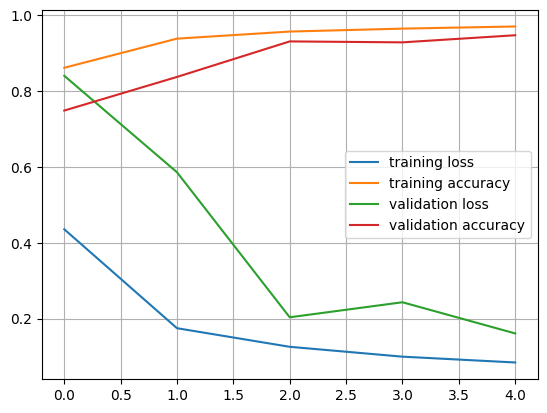

In [24]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [25]:
model.save('plantdd_image.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model.save('/content/drive/MyDrive/PlantVillage/my_model.keras')


In [ ]:
def preprocess_image(file):
  path = '/content/drive/MyDrive/PlantVillage/random_tests/'
  img = image.load_img(path + file, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)


In [ ]:
def get_prediction(image, level='all'):
  preprocessed_image = preprocess_image(image)
  predictions = model.predict(preprocessed_image)

  ind = np.argpartition(predictions[0], -5)[-5:]
  result = np.argmax(predictions[0])
  top5= predictions[0][ind]

  if level == 'single':
     for k,v in labels.items():
       if v == result: return k;
  else:
    for k,v in labels.items():
      if v in np.sort(ind):
        idx = np.where(ind == v)[0]
        print(f'{top5[idx]} ~> {k}')





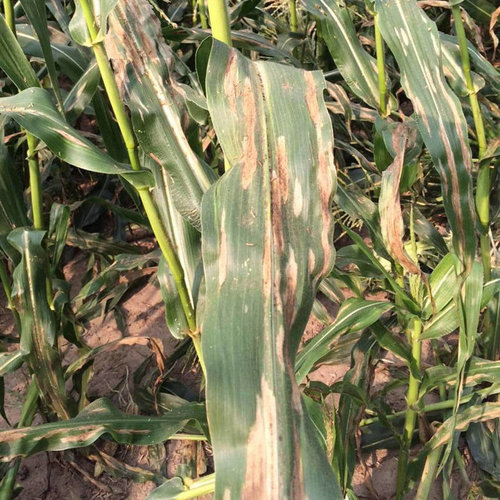

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Digitalfarmer/random_tests/corn_scorch.jpg', width=300, height=200)

In [ ]:
ans = get_prediction('corn_scorch.jpg')
ans

[0.1449509] ~> Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
[0.41161817] ~> Corn_(maize)___Northern_Leaf_Blight
[0.10924993] ~> Strawberry___Leaf_scorch
[0.29565668] ~> Tomato___Early_blight
[0.0247179] ~> Tomato___Target_Spot
